In [1]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit, njit

# Astronomy Specific Imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

# Image Analysis Specific Imports
from skimage.measure import perimeter, euler_number

import porespy as ps
ps.visualization.set_mpl_style()

def remove_region(data, wcs, longitude_min, longitude_max, latitude_min, latitude_max):
    
    min_coord_remove = SkyCoord(longitude_min, latitude_min, frame='galactic', unit=u.deg)
    max_coord_remove = SkyCoord(longitude_max, latitude_max, frame='galactic', unit=u.deg)

    min_pixel_remove = wcs[:][:][0].world_to_pixel(min_coord_remove)
    max_pixel_remove = wcs[:][:][0].world_to_pixel(max_coord_remove)

    # Create a mask based on these galactic coordinates
    remove_mask = np.zeros(data.shape, dtype=bool)

    # Set True in the mask for the specified region based on pixel indices
    y_min, x_min = int(np.floor(min_pixel_remove[1])), int(np.floor(min_pixel_remove[0]))
    y_max, x_max = int(np.ceil(max_pixel_remove[1])), int(np.ceil(max_pixel_remove[0]))

    # Apply the mask to the region within the pixel boundaries
    remove_mask[y_min:y_max, x_max:x_min] = True
    
    # Apply the mask to the original data to set the region to NaN or another value
    data[remove_mask] = np.nan  # Replace with np.nan to exclude the data

    return data

def derive_density_maps():
    # Get the current working directory
    curr_folder = os.getcwd()

    # Find the index of 'notebooks' in the current path
    notebooks_index = curr_folder.rfind('notebooks')

    # Check if 'notebooks' is found in the path
    if notebooks_index != -1:
        # Set the directory to the parent of 'notebooks'
        src_path = os.path.dirname(curr_folder[:notebooks_index])
        os.chdir(src_path)  # Change the current working directory to the source path
        sys.path.insert(0, src_path)  # Insert the source path into sys.path for module imports

    # Construct the path to the FITS file
    planck_herschel_fits_file = os.path.join(curr_folder, "Lombardi", "planck_herschel.fits.gz")

    hdu_herschel_fits = fits.open(planck_herschel_fits_file)[0]
    
    # Constructt WCS and image data
    wcs = WCS(hdu_herschel_fits.header)

    image_data = hdu_herschel_fits.data[0]

    # Replace NaNs and Infs with some valid value, e.g., zero or the median
    tau = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 1: Define constants
    # TO-DO: differentiate between Orion A and B 

    # Orion A: 206 ≤ l ≤ 217, −21 ≤ b ≤ −17
    # Orion B: 203 ≤ l ≤ 210, −17 ≤ b ≤ −12

    # Step 3: Apply the formula to calculate A_k (Lomabrdi et al)
    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    # Making it smaller cause of computation time
    # l_min_A, l_max_A = 210, 212
    # b_min_A, b_max_A = -21, -20

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    gamma_orion_A = 2640  # mag
    delta_orion_A = 0.012  # mag, Offset for Orion A

    A_k = gamma_orion_A * tau + delta_orion_A

    A_k[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] = gamma_orion_A * tau[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])] + delta_orion_A

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    gamma_orion_B = 3460  # mag
    delta_orion_B = -0.001  # mag, Offset for Orion B

    A_k[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] = gamma_orion_B * tau[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])] + delta_orion_B

    # A_k to A_V
    A_V = A_k/0.112

    # N(H2)
    N_H2 = 0.93e21 * np.array(A_V , dtype=np.float64)

    # Define regions to remove as a list of dictionaries
    regions_to_remove = [
        # Orion A regions
        {"longitude_min": 208, "longitude_max": 211, "latitude_min": -17.9, "latitude_max": -16.9},
        {"longitude_min": 214.5, "longitude_max": 216.5, "latitude_min": -18, "latitude_max": -17},
        {"longitude_min": 206, "longitude_max": 206.5, "latitude_min": -19.5, "latitude_max": -19},

        # Orion B regions
        {"longitude_min": 208, "longitude_max": 210, "latitude_min": -15, "latitude_max": -12},
        {"longitude_min": 209, "longitude_max": 210, "latitude_min": -16.4, "latitude_max": -15.5},
        {"longitude_min": 203, "longitude_max": 205, "latitude_min": -12.3, "latitude_max": -11.5},
        {"longitude_min": 204.5, "longitude_max": 205.5, "latitude_min": -12.2, "latitude_max": -11.5},
        {"longitude_min": 205.8, "longitude_max": 207, "latitude_min": -13.5, "latitude_max": -12.5},
    ]

    # Loop through each region and remove it from N_H2
    for region in regions_to_remove:
        N_H2 = remove_region(
            N_H2,
            wcs,
            region["longitude_min"],
            region["longitude_max"],
            region["latitude_min"],
            region["latitude_max"]
        )
    
    N_H2_OA = N_H2[int(min_pixel_A[1]): int(max_pixel_A[1]), int(max_pixel_A[0]): int(min_pixel_A[0])]
    N_H2_OB = N_H2[int(min_pixel_B[1]): int(max_pixel_B[1]), int(max_pixel_B[0]): int(min_pixel_B[0])]

    N_H2 = np.nan_to_num(N_H2, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OA = np.nan_to_num(N_H2_OA, nan=0.0, posinf=0.0, neginf=0.0)
    N_H2_OB = np.nan_to_num(N_H2_OB, nan=0.0, posinf=0.0, neginf=0.0)
    
    return N_H2, N_H2_OA, N_H2_OB, wcs

# @njit
def box_counting(img, visualize=False):
    """
    Calculate the fractal dimension of a 2D binary image using the box-counting method.

    Parameters:
        img (numpy.ndarray): A 2D binary image where 1 represents the object and 0 represents the background.
        visualize (bool): If True, shows how the image is divided into boxes at each scale.

    Returns:
        float: The fractal dimension of the image.
    """
    # Sizes of boxes to use (powers of 2)
    sizes = 2 ** np.arange(1, int(np.log2(min(img.shape))) + 1)
    
    # Count the number of boxes that contain at least one pixel of the object
    box_counts = []
    
    for size in sizes:
        # Count the number of boxes that contain at least one pixel of the object
        box_count = 0
        for i in range(0, img.shape[0], size):
            for j in range(0, img.shape[1], size):
                if np.any(img[i:i+size, j:j+size]):
                    box_count += 1
        box_counts.append(box_count)
        
        # if visualize:
        #     # Visualize the grid overlay
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(img, cmap='gray', origin='upper')
            
        #     # Draw grid lines
        #     for x in range(0, img.shape[1], size):
        #         plt.axvline(x, color='red', linestyle='--', linewidth=0.5)
        #     for y in range(0, img.shape[0], size):
        #         plt.axhline(y, color='red', linestyle='--', linewidth=0.5)
            
        #     plt.title(f'Box size: {size}x{size}')
        #     plt.axis('off')
        #     plt.show()

    # Log-log plot (log(sizes) vs log(box_counts))
    log_sizes = np.log(1/sizes)
    log_counts = np.log(box_counts)

    # Fit a line to find the slope (fractal dimension)
    slope, _ = np.polyfit(log_sizes, log_counts, 1)

    return slope

# @njit
def standard_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        mask_perim = perimeter(mask)
        perimeters.append(mask_perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)


    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(np.array(perimeters))

    D = (2* log_perimeters)/(log_areas)

    return {
        "thresholds": thresholds,
        "areas": areas,
        "perimeters": perimeters,
        "euler_chars": euler_chars,
        "fractal_dimension":  D
    }

    # Kolmogorov turbulence predicts 
    # D = 5/3 (1.7) for turbulent isobar models
    # D = 4/3 (1.3) for turbulent isothermal models

N_H2, N_H2_OA, N_H2_OB, wcs = derive_density_maps()

[14:52:33] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=765920;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=664199;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

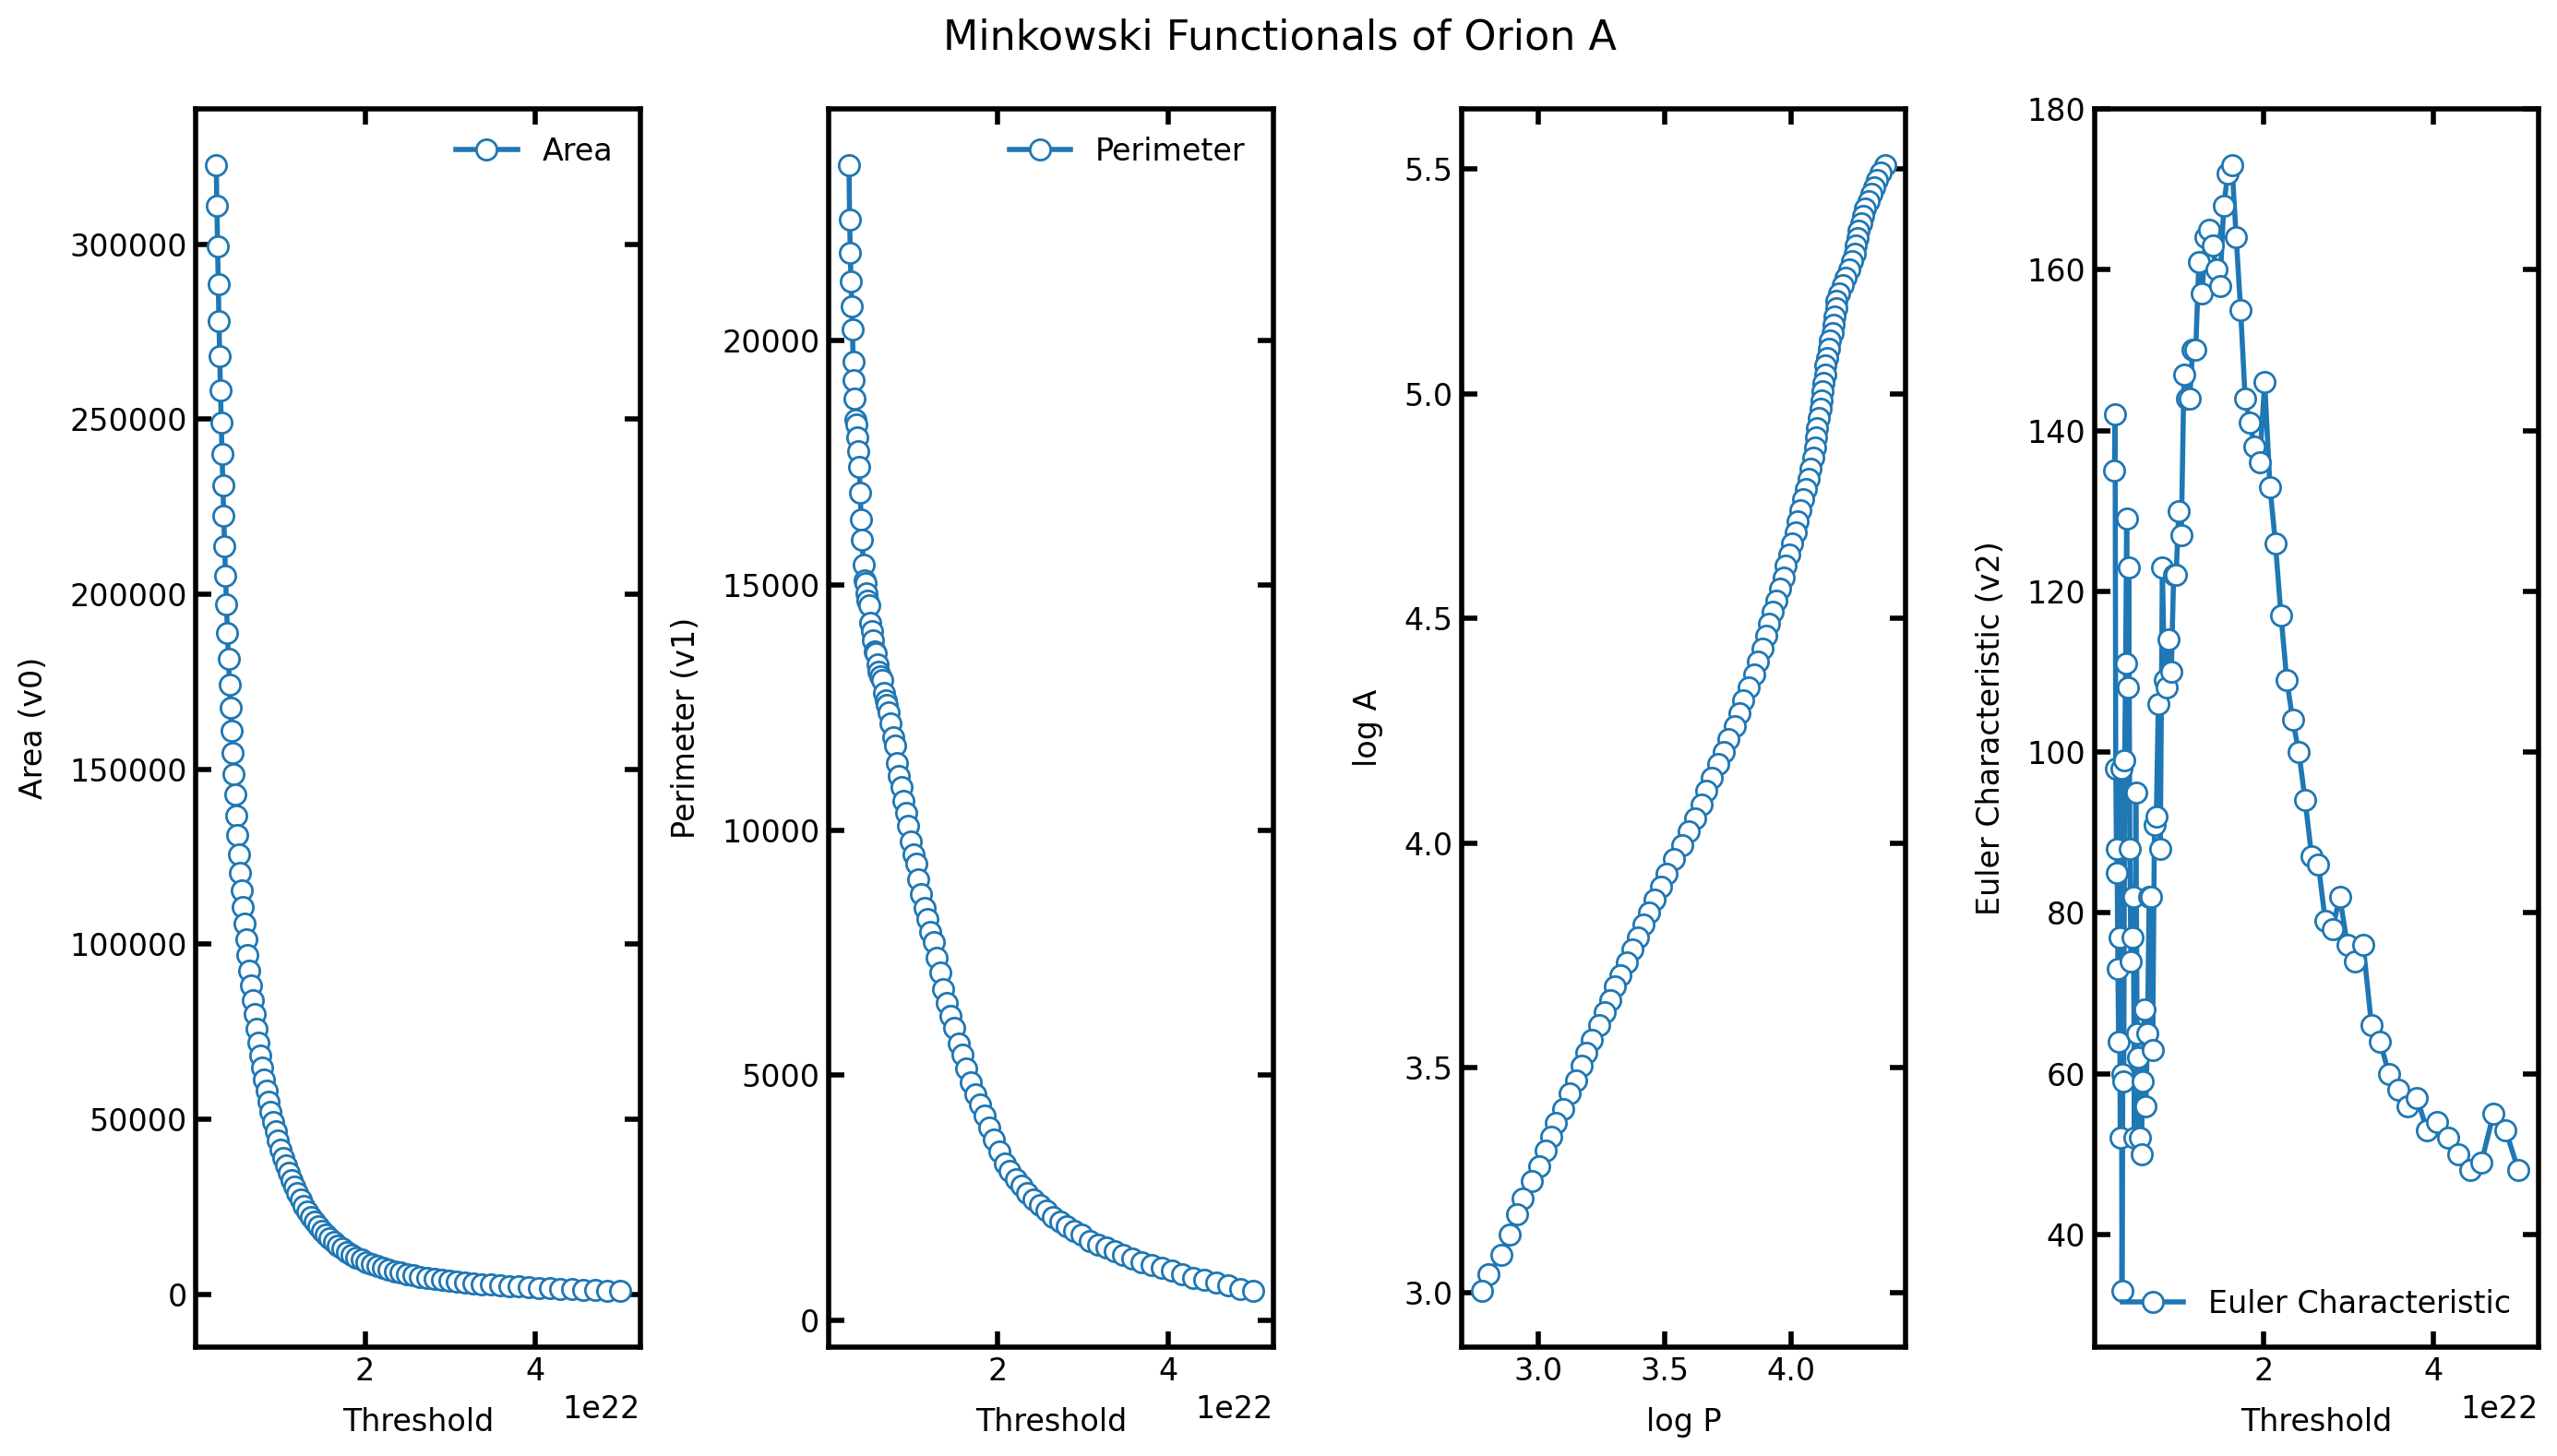

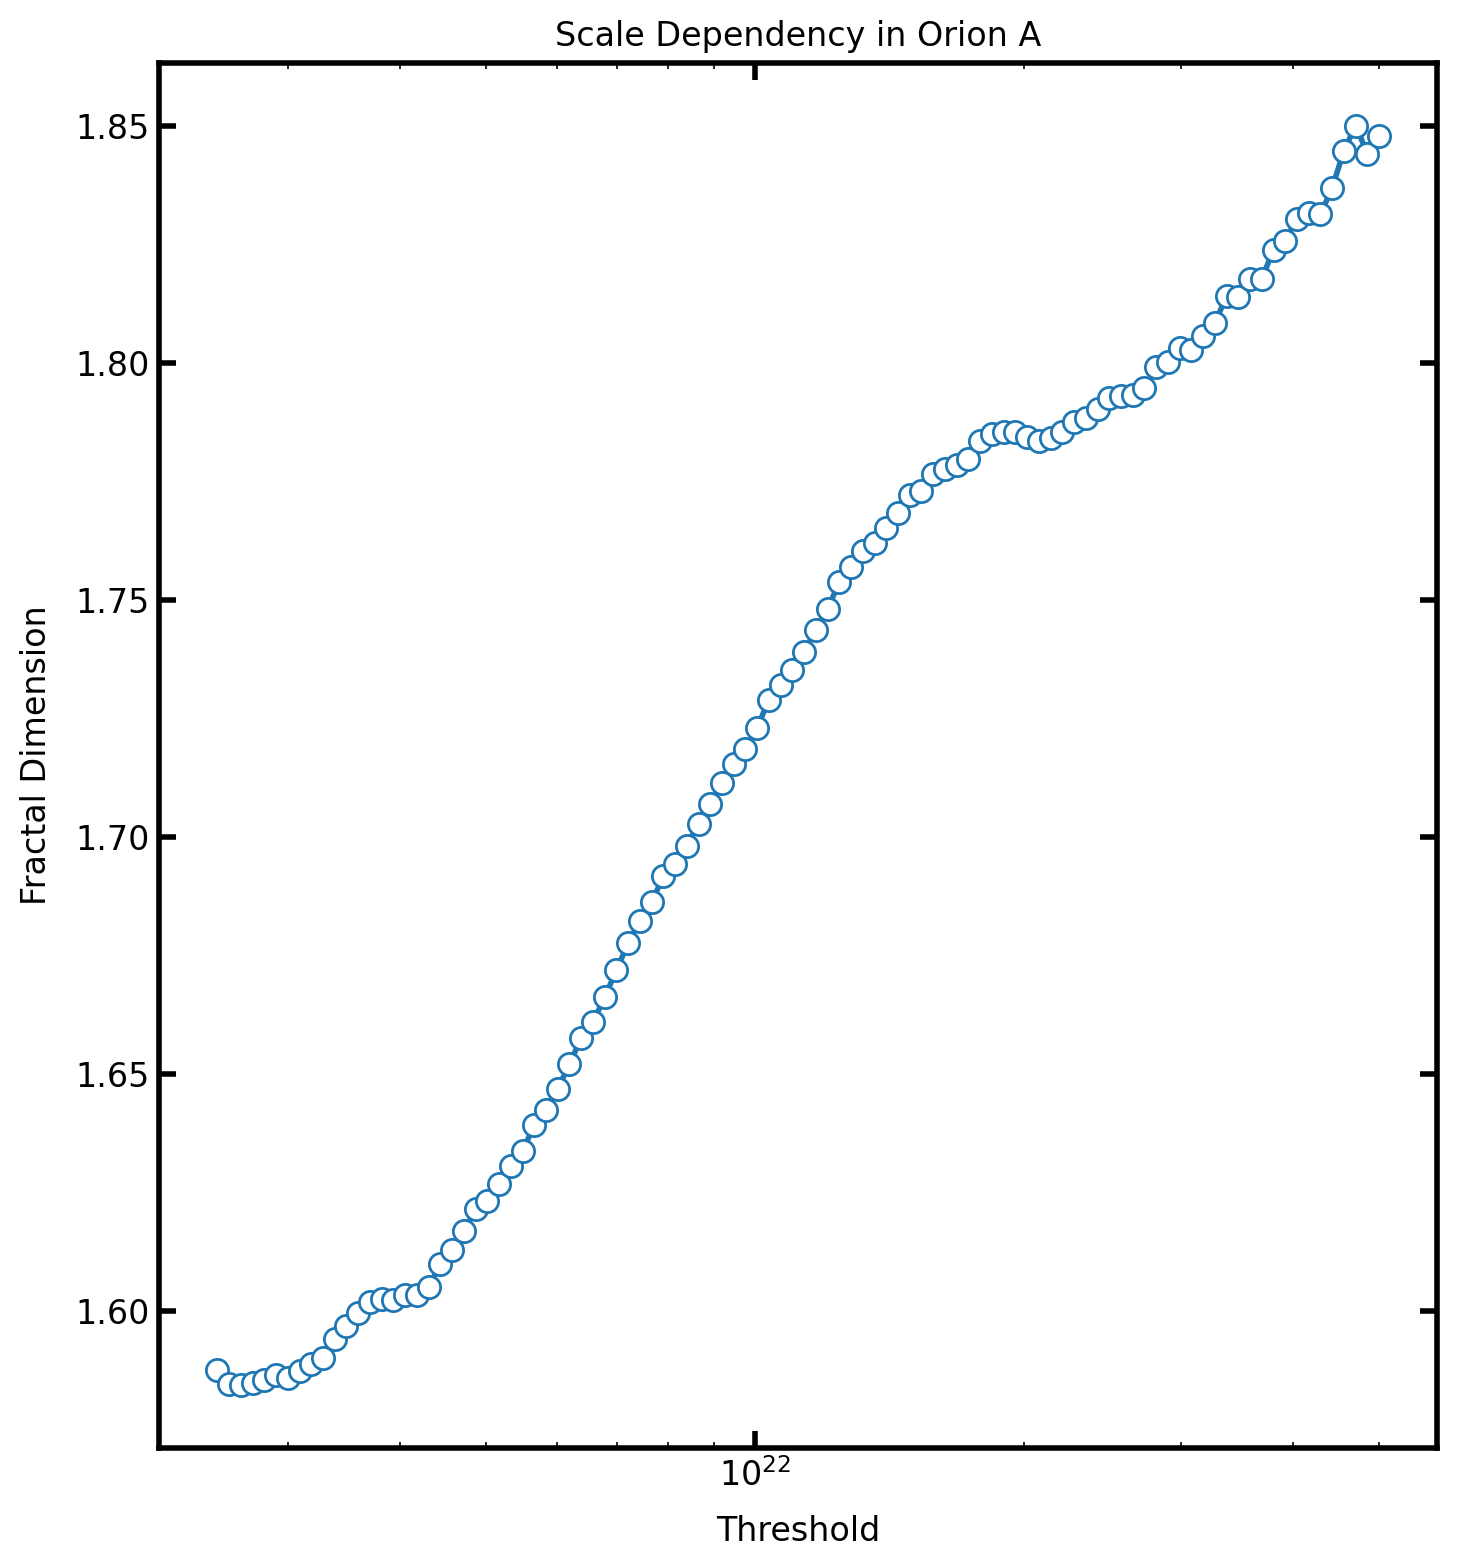

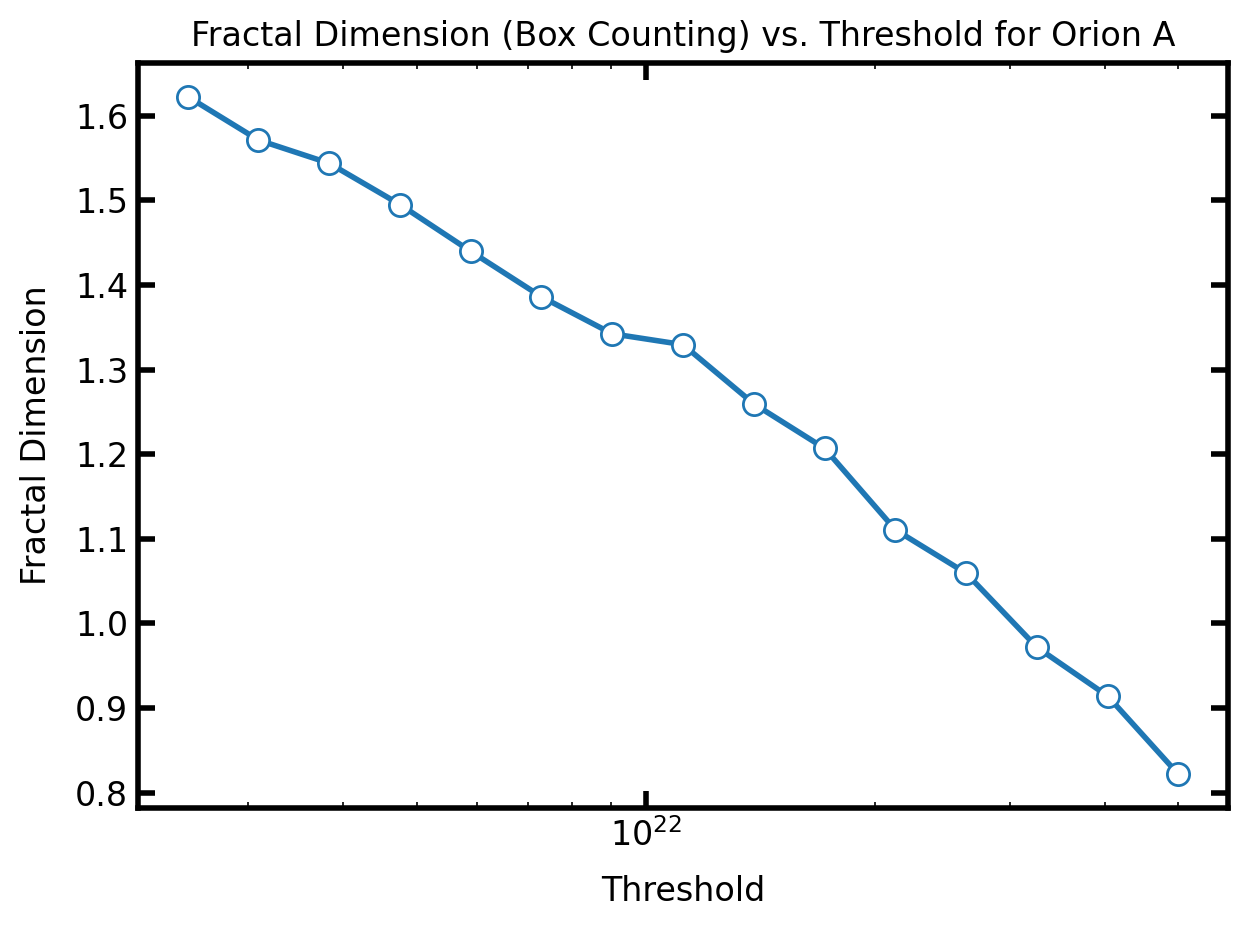

In [2]:
# Minkowski
region_name = "Orion A"
results_OA = standard_minkowski_functionals(N_H2_OA, threshold_min = 2.5e21, threshold_max = 5e22)

# Box-Counting
fractal_dimensions_OA_BC = []

thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 15)

for threshold in thresholds:
    mask = N_H2_OA >= threshold

    fractal_dim = box_counting(mask, visualize=False)
    fractal_dimensions_OA_BC.append(fractal_dim)

# Plot the results
plt.figure(figsize=(14, 8))
plt.suptitle("Minkowski Functionals of "+region_name, fontsize=16)

plt.subplot(1, 4, 1)
plt.plot(results_OA["thresholds"], results_OA["areas"], 'o-', label='Area')
plt.xlabel('Threshold')
plt.ylabel('Area (v0)')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(results_OA["thresholds"], results_OA["perimeters"], 'o-', label='Perimeter')
plt.xlabel('Threshold')
plt.ylabel('Perimeter (v1)')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(np.log10(results_OA["perimeters"]), np.log10(results_OA["areas"]), 'o-')
plt.xlabel('log P')
plt.ylabel('log A')

plt.subplot(1, 4, 4)
plt.plot(results_OA["thresholds"], results_OA["euler_chars"], 'o-', label='Euler Characteristic')
plt.xlabel('Threshold')
plt.ylabel('Euler Characteristic (v2)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the scale dependency
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(results_OA["thresholds"], results_OA["fractal_dimension"], 'o-')
plt.title("Scale Dependency in "+region_name)
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")

# plt.subplot(1, 2, 2)
# plt.plot(results_OA["thresholds"], D_2, 'o-')
# plt.title("Scale Dependency in "+region_name)
# plt.xlabel('Threshold')
# plt.ylabel('Fractal Dimension')
# plt.xscale("log")

plt.tight_layout()
plt.show()

plt.plot(thresholds, fractal_dimensions_OA_BC, 'o-')
plt.title("Fractal Dimension (Box Counting) vs. Threshold for Orion A")
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.show()

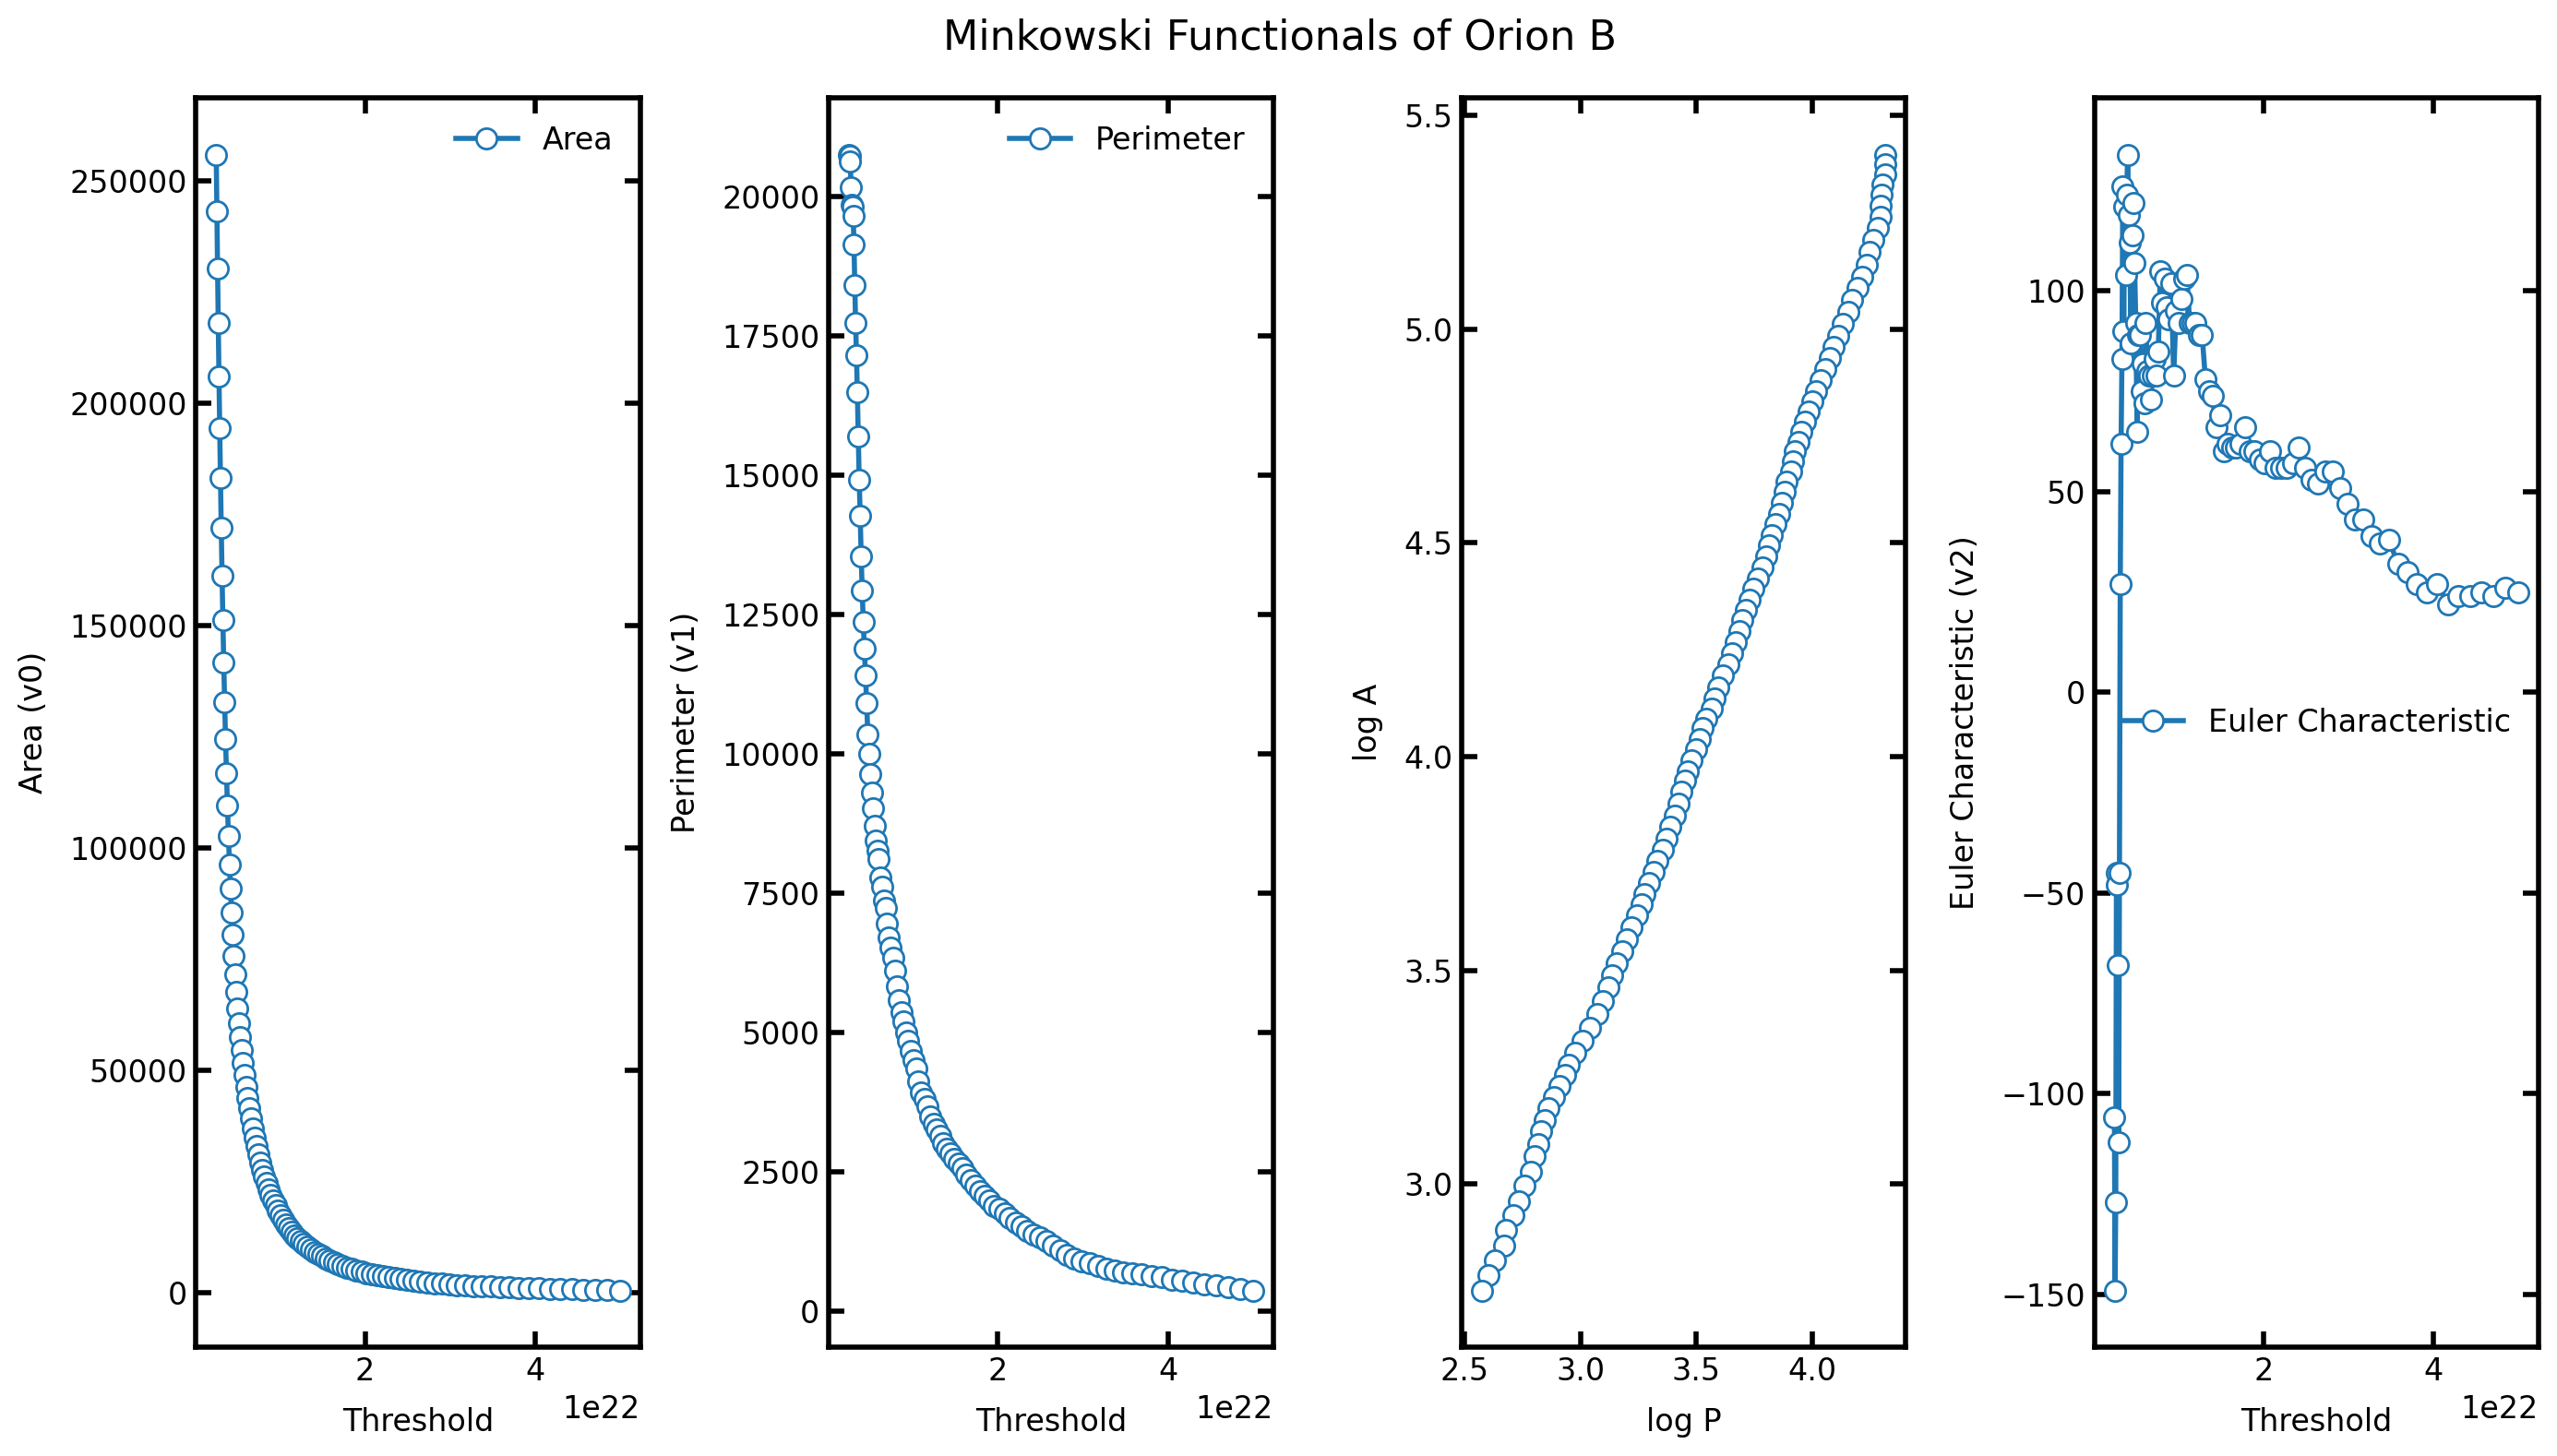

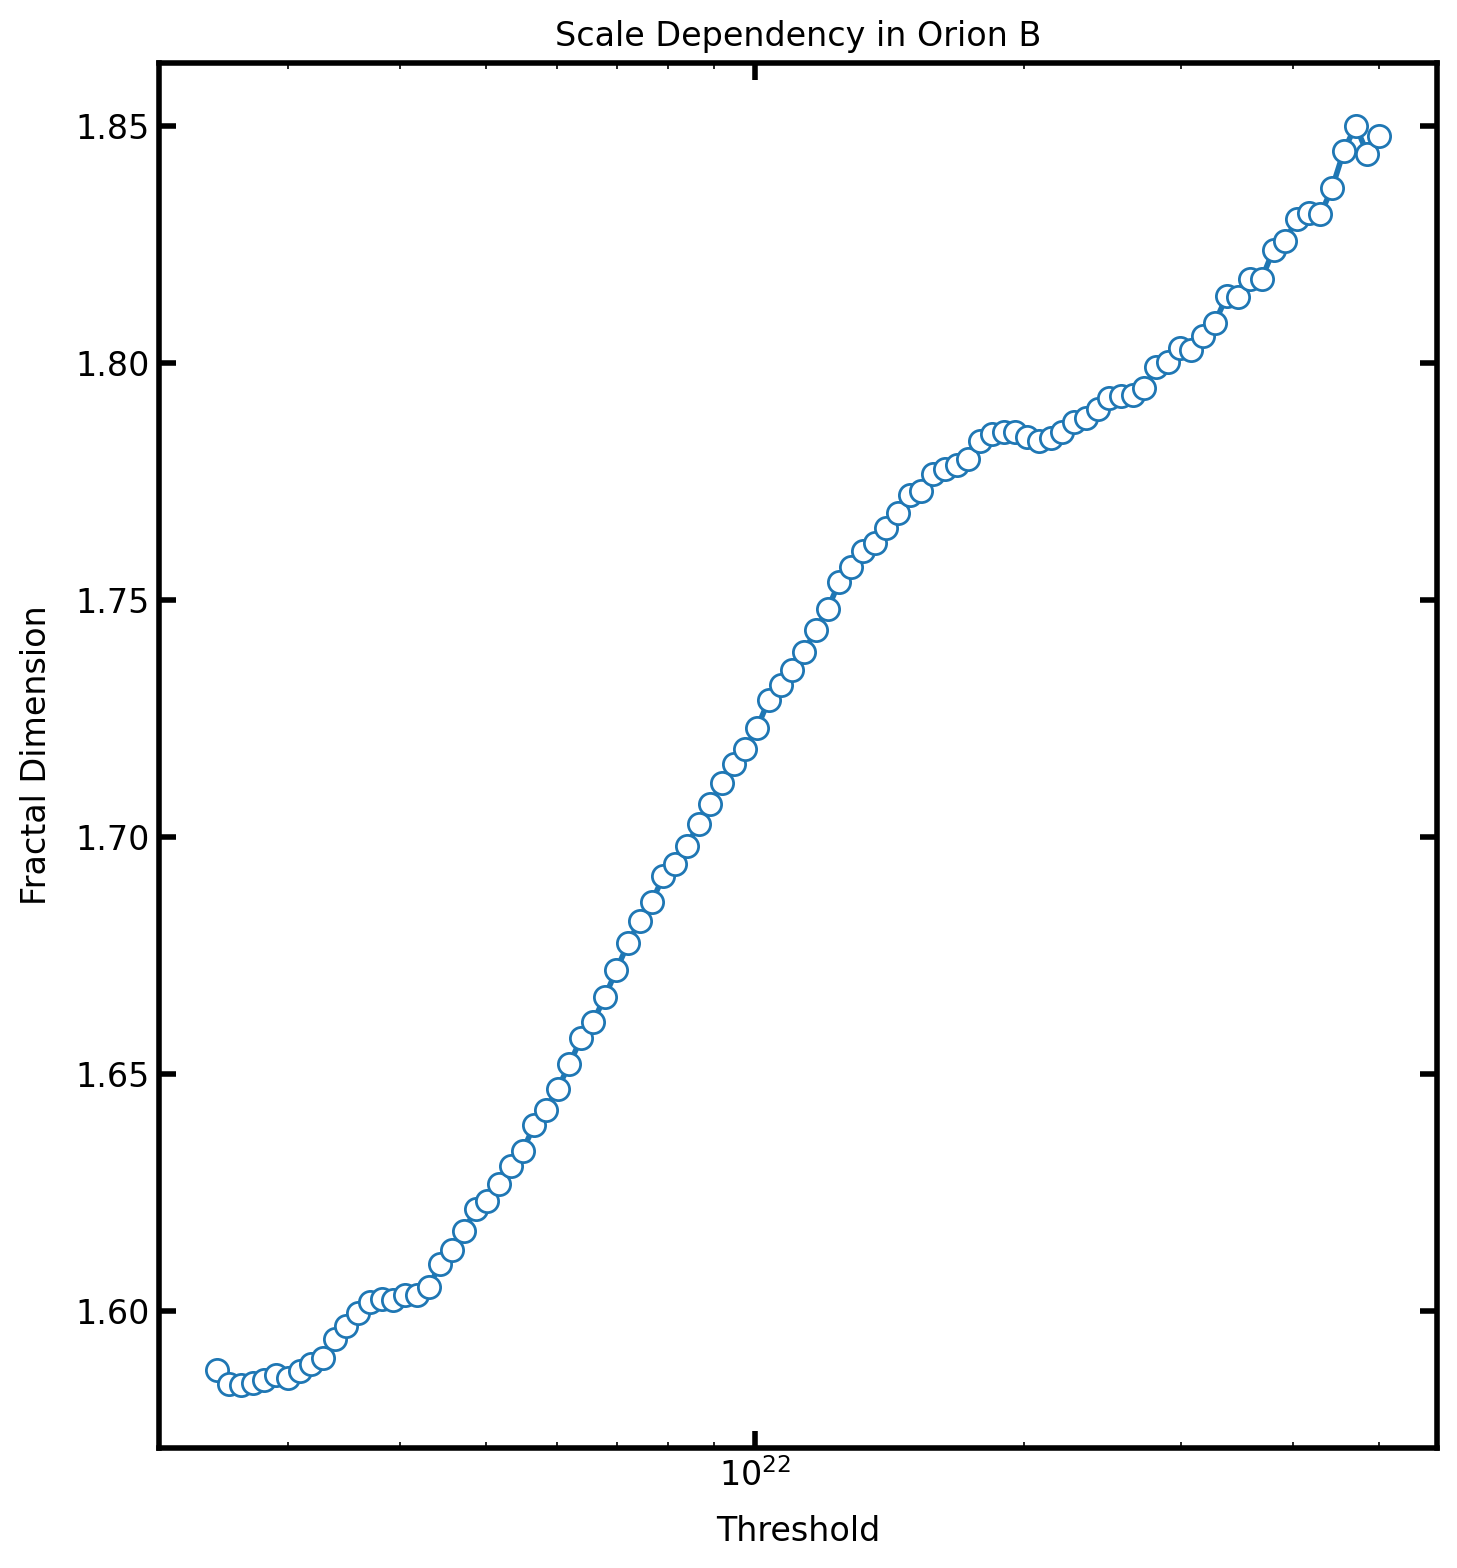

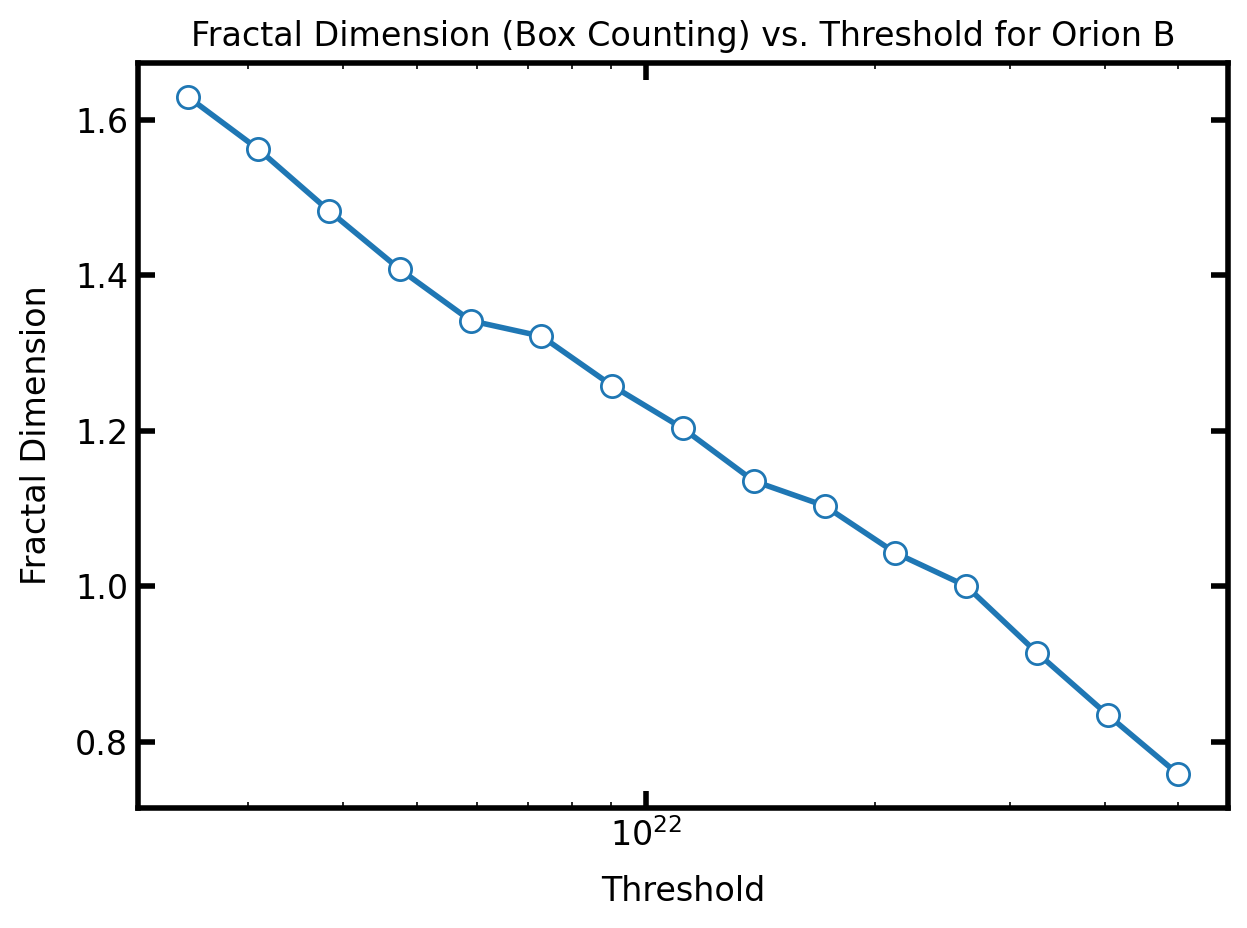

In [3]:
# Minkowski
region_name = "Orion B"
results_OB = standard_minkowski_functionals(N_H2_OB, threshold_min = 2.5e21, threshold_max = 5e22)

# Box-Counting
fractal_dimensions_OB_BC = []

thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 15)

for threshold in thresholds:
    mask = N_H2_OB >= threshold

    fractal_dim = box_counting(mask, visualize=False)
    fractal_dimensions_OB_BC.append(fractal_dim)

# Plot the results
plt.figure(figsize=(14, 8))
plt.suptitle("Minkowski Functionals of "+region_name, fontsize=16)

plt.subplot(1, 4, 1)
plt.plot(results_OB["thresholds"], results_OB["areas"], 'o-', label='Area')
plt.xlabel('Threshold')
plt.ylabel('Area (v0)')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(results_OB["thresholds"], results_OB["perimeters"], 'o-', label='Perimeter')
plt.xlabel('Threshold')
plt.ylabel('Perimeter (v1)')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(np.log10(results_OB["perimeters"]), np.log10(results_OB["areas"]), 'o-')
plt.xlabel('log P')
plt.ylabel('log A')

plt.subplot(1, 4, 4)
plt.plot(results_OB["thresholds"], results_OB["euler_chars"], 'o-', label='Euler Characteristic')
plt.xlabel('Threshold')
plt.ylabel('Euler Characteristic (v2)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the scale dependency
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(results_OB["thresholds"], results_OA["fractal_dimension"], 'o-')
plt.title("Scale Dependency in "+region_name)
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")

# plt.subplot(1, 2, 2)
# plt.plot(results_OB["thresholds"], D_2, 'o-')
# plt.title("Scale Dependency in "+region_name)
# plt.xlabel('Threshold')
# plt.ylabel('Fractal Dimension')
# plt.xscale("log")

plt.tight_layout()
plt.show()

plt.plot(thresholds, fractal_dimensions_OB_BC, 'o-')
plt.title("Fractal Dimension (Box Counting) vs. Threshold for Orion B")
plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.show()

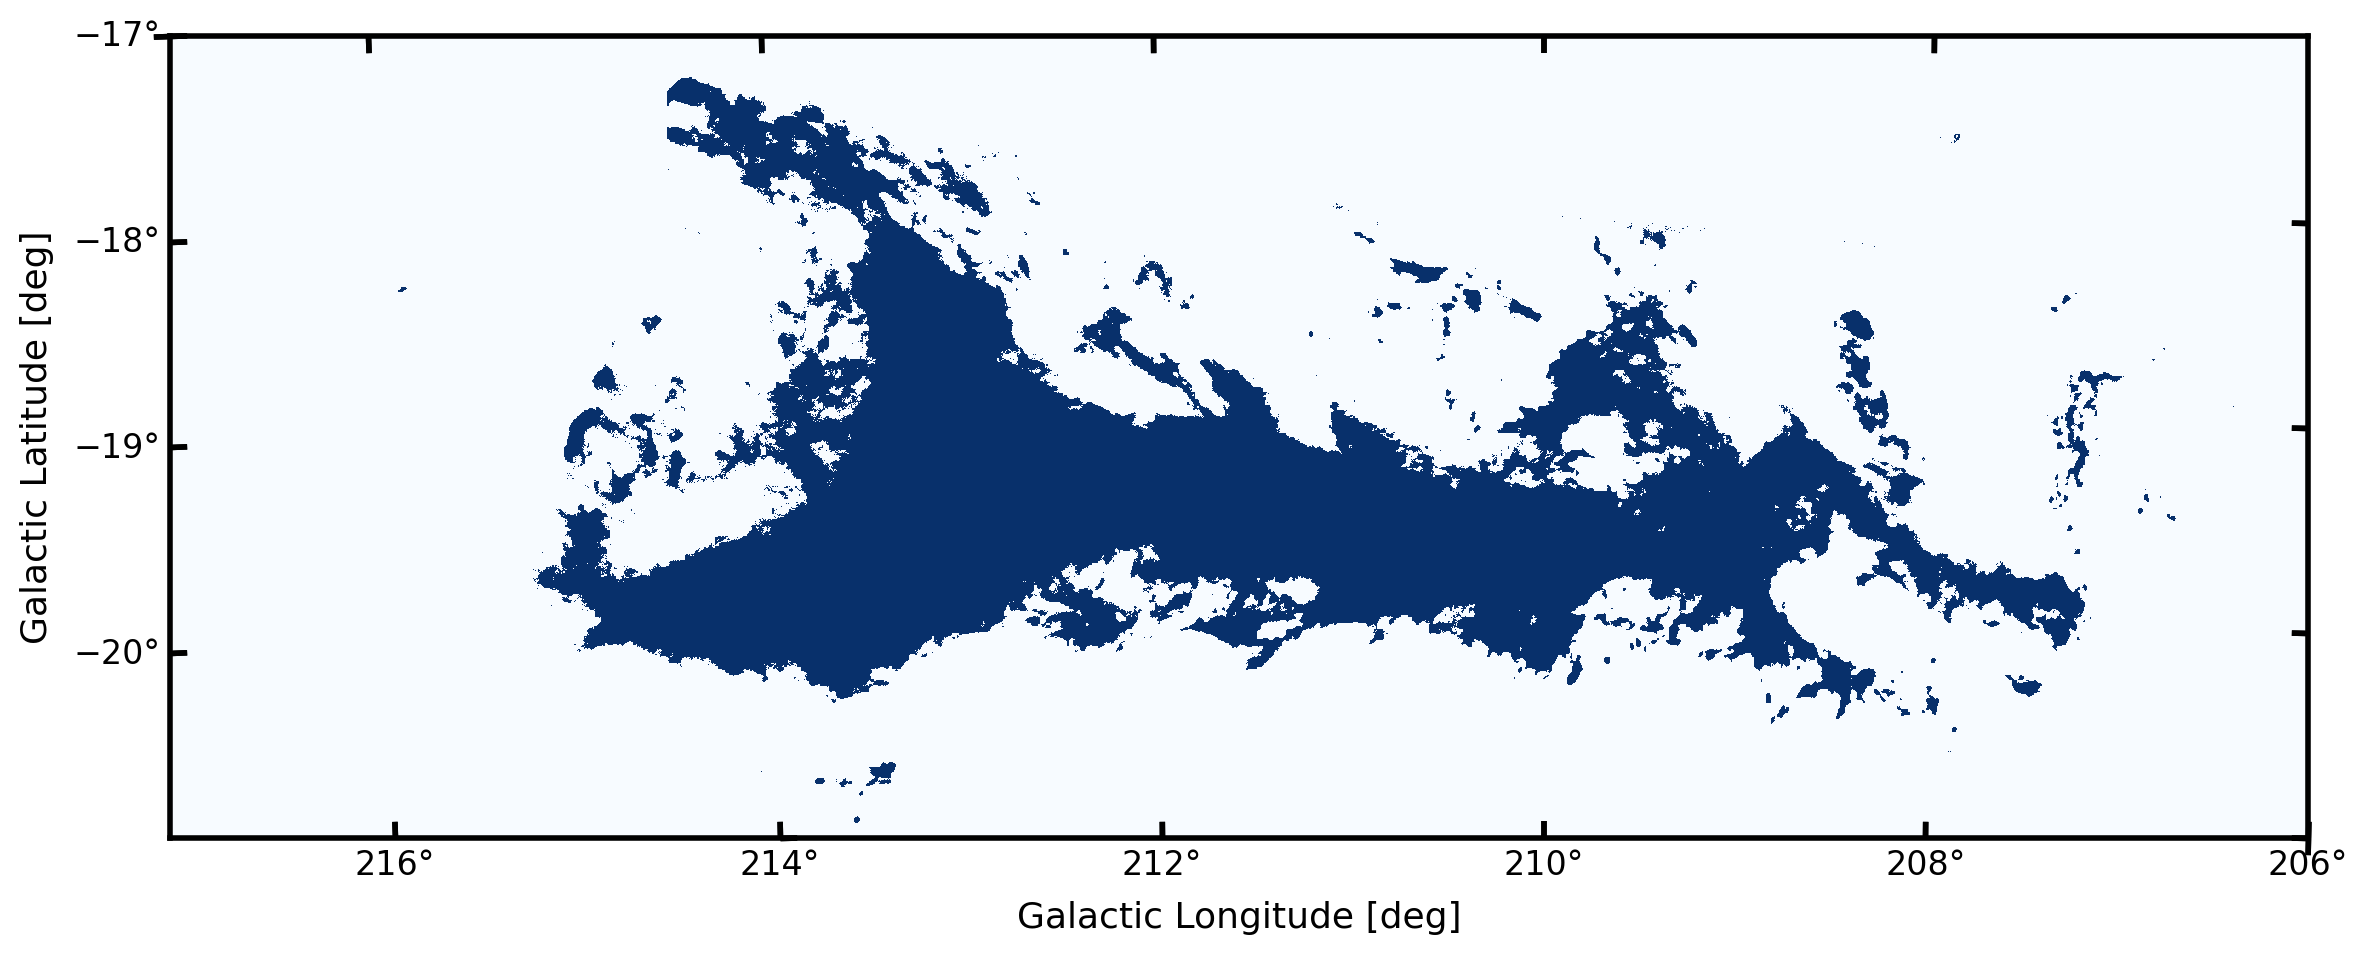

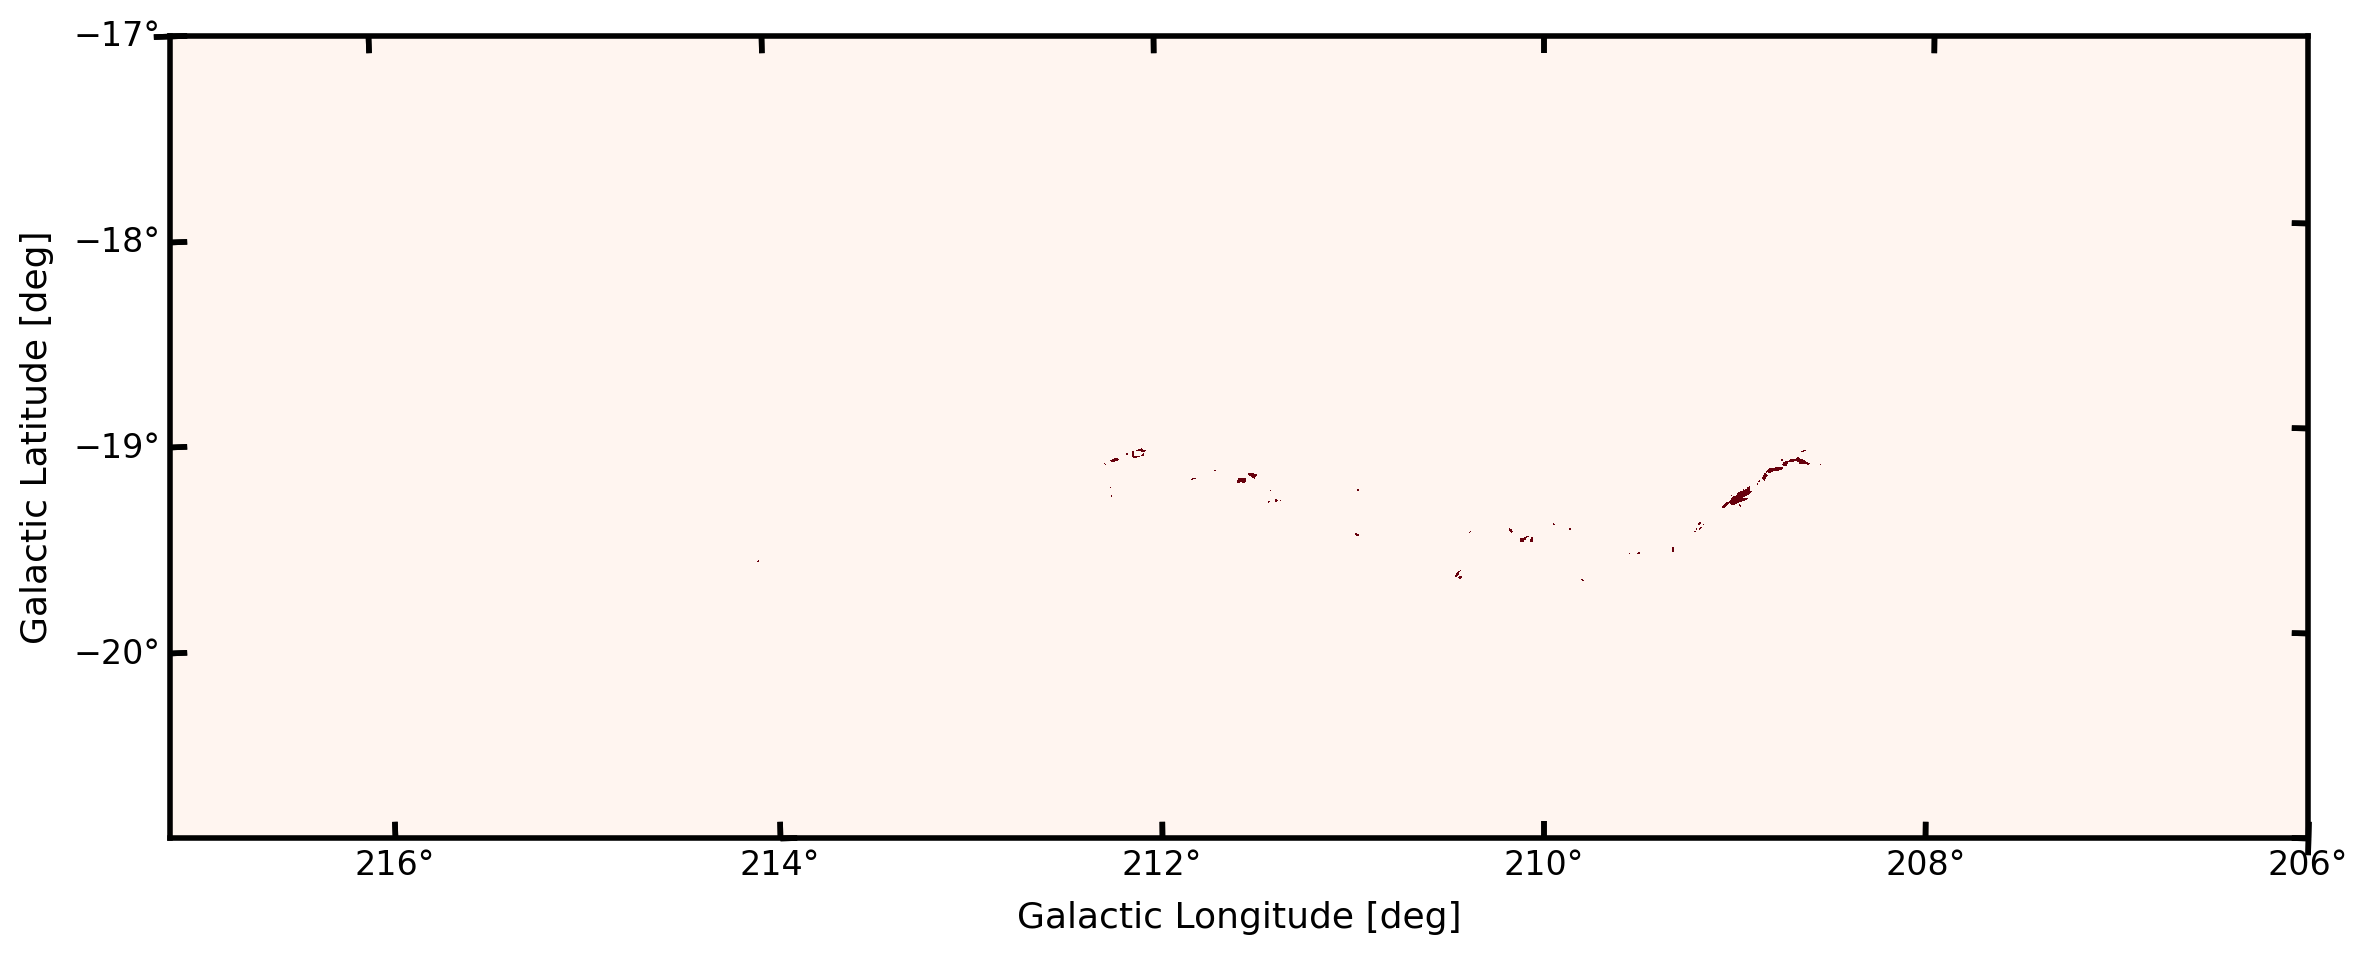

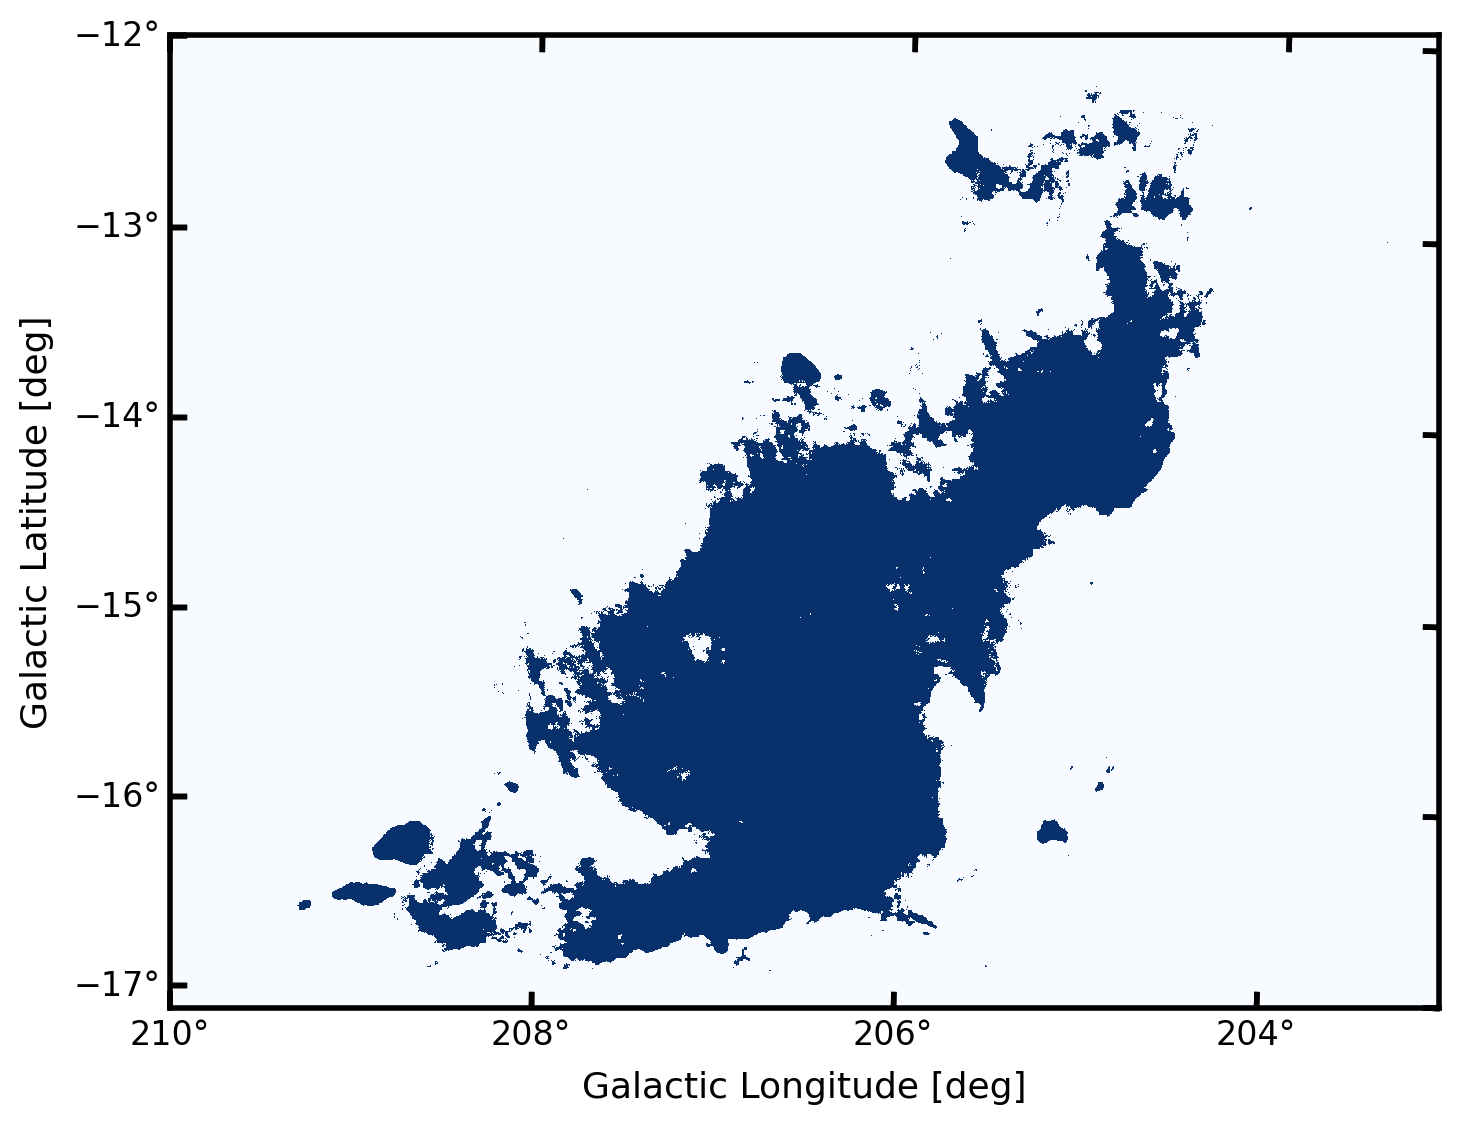

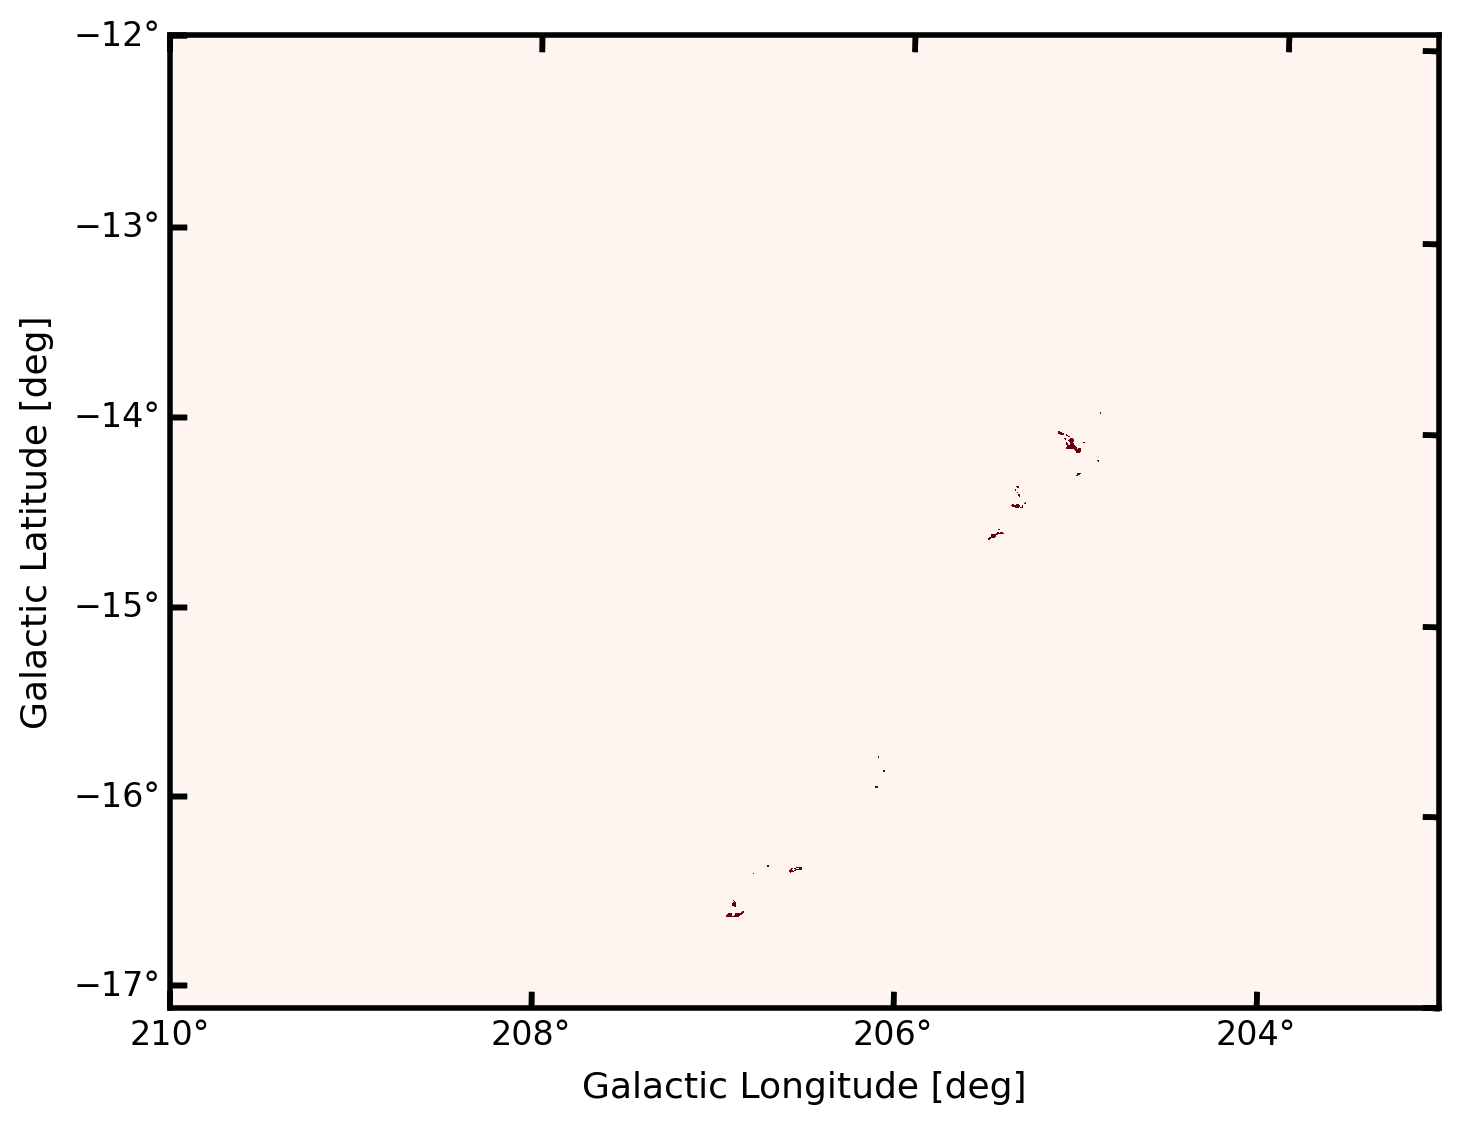

In [4]:
def plot_example_region(data, wcs, low_threshold = 2e21, high_threshold = 5e22):
    # Create binary masks
    low_mask = data >= low_threshold
    high_mask = data >= high_threshold

    l_min_A, l_max_A = 206, 217
    b_min_A, b_max_A = -21, -17

    min_coord_A = SkyCoord(l_min_A, b_min_A, frame='galactic', unit=u.deg)
    max_coord_A = SkyCoord(l_max_A, b_max_A, frame='galactic', unit=u.deg)

    min_pixel_A = wcs[:][:][0].world_to_pixel(min_coord_A)
    max_pixel_A = wcs[:][:][0].world_to_pixel(max_coord_A)

    l_min_B, l_max_B = 203, 210
    b_min_B, b_max_B = -17, -12

    min_coord_B = SkyCoord(l_min_B, b_min_B, frame='galactic', unit=u.deg)
    max_coord_B = SkyCoord(l_max_B, b_max_B, frame='galactic', unit=u.deg)

    min_pixel_B = wcs[:][:][0].world_to_pixel(min_coord_B)
    max_pixel_B = wcs[:][:][0].world_to_pixel(max_coord_B)

    # Visualize the low-threshold mask (A)
    plt.figure(figsize=(12, 10))
    ax_low = plt.subplot(111, projection=wcs[0])
    sp_low = ax_low.imshow(low_mask, origin='lower', interpolation=None, cmap='Blues')

    ax_low.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_low.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_low.set(xlim=[max_pixel_A[0], min_pixel_A[0]], ylim=[min_pixel_A[1], max_pixel_A[1]])
    plt.show()

    # Visualize the high-threshold mask (A)
    plt.figure(figsize=(12, 10))
    ax_high = plt.subplot(111, projection=wcs[0])
    sp_high = ax_high.imshow(high_mask, origin='lower', cmap='Reds', interpolation=None)

    ax_high.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_high.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_high.set(xlim=[max_pixel_A[0], min_pixel_A[0]], ylim=[min_pixel_A[1], max_pixel_A[1]])
    plt.show()

    # Visualize the low-threshold mask (B)
    plt.figure(figsize=(40, 40))
    ax_low = plt.subplot(111, projection=wcs[0])
    sp_low = ax_low.imshow(low_mask, origin='lower', interpolation=None, cmap='Blues')

    ax_low.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_low.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_low.set(xlim=[max_pixel_B[0], min_pixel_B[0]], ylim=[min_pixel_B[1], max_pixel_B[1]])
    plt.show()

    # Visualize the high-threshold mask (B)
    plt.figure(figsize=(40, 40))
    ax_high = plt.subplot(111, projection=wcs[0])
    sp_high = ax_high.imshow(high_mask, origin='lower', cmap='Reds', interpolation=None)

    ax_high.set_xlabel("Galactic Longitude [deg]", fontsize=13)
    ax_high.set_ylabel("Galactic Latitude [deg]", fontsize=13)

    ax_high.set(xlim=[max_pixel_B[0], min_pixel_B[0]], ylim=[min_pixel_B[1], max_pixel_B[1]])
    plt.show()

plot_example_region(N_H2, wcs)

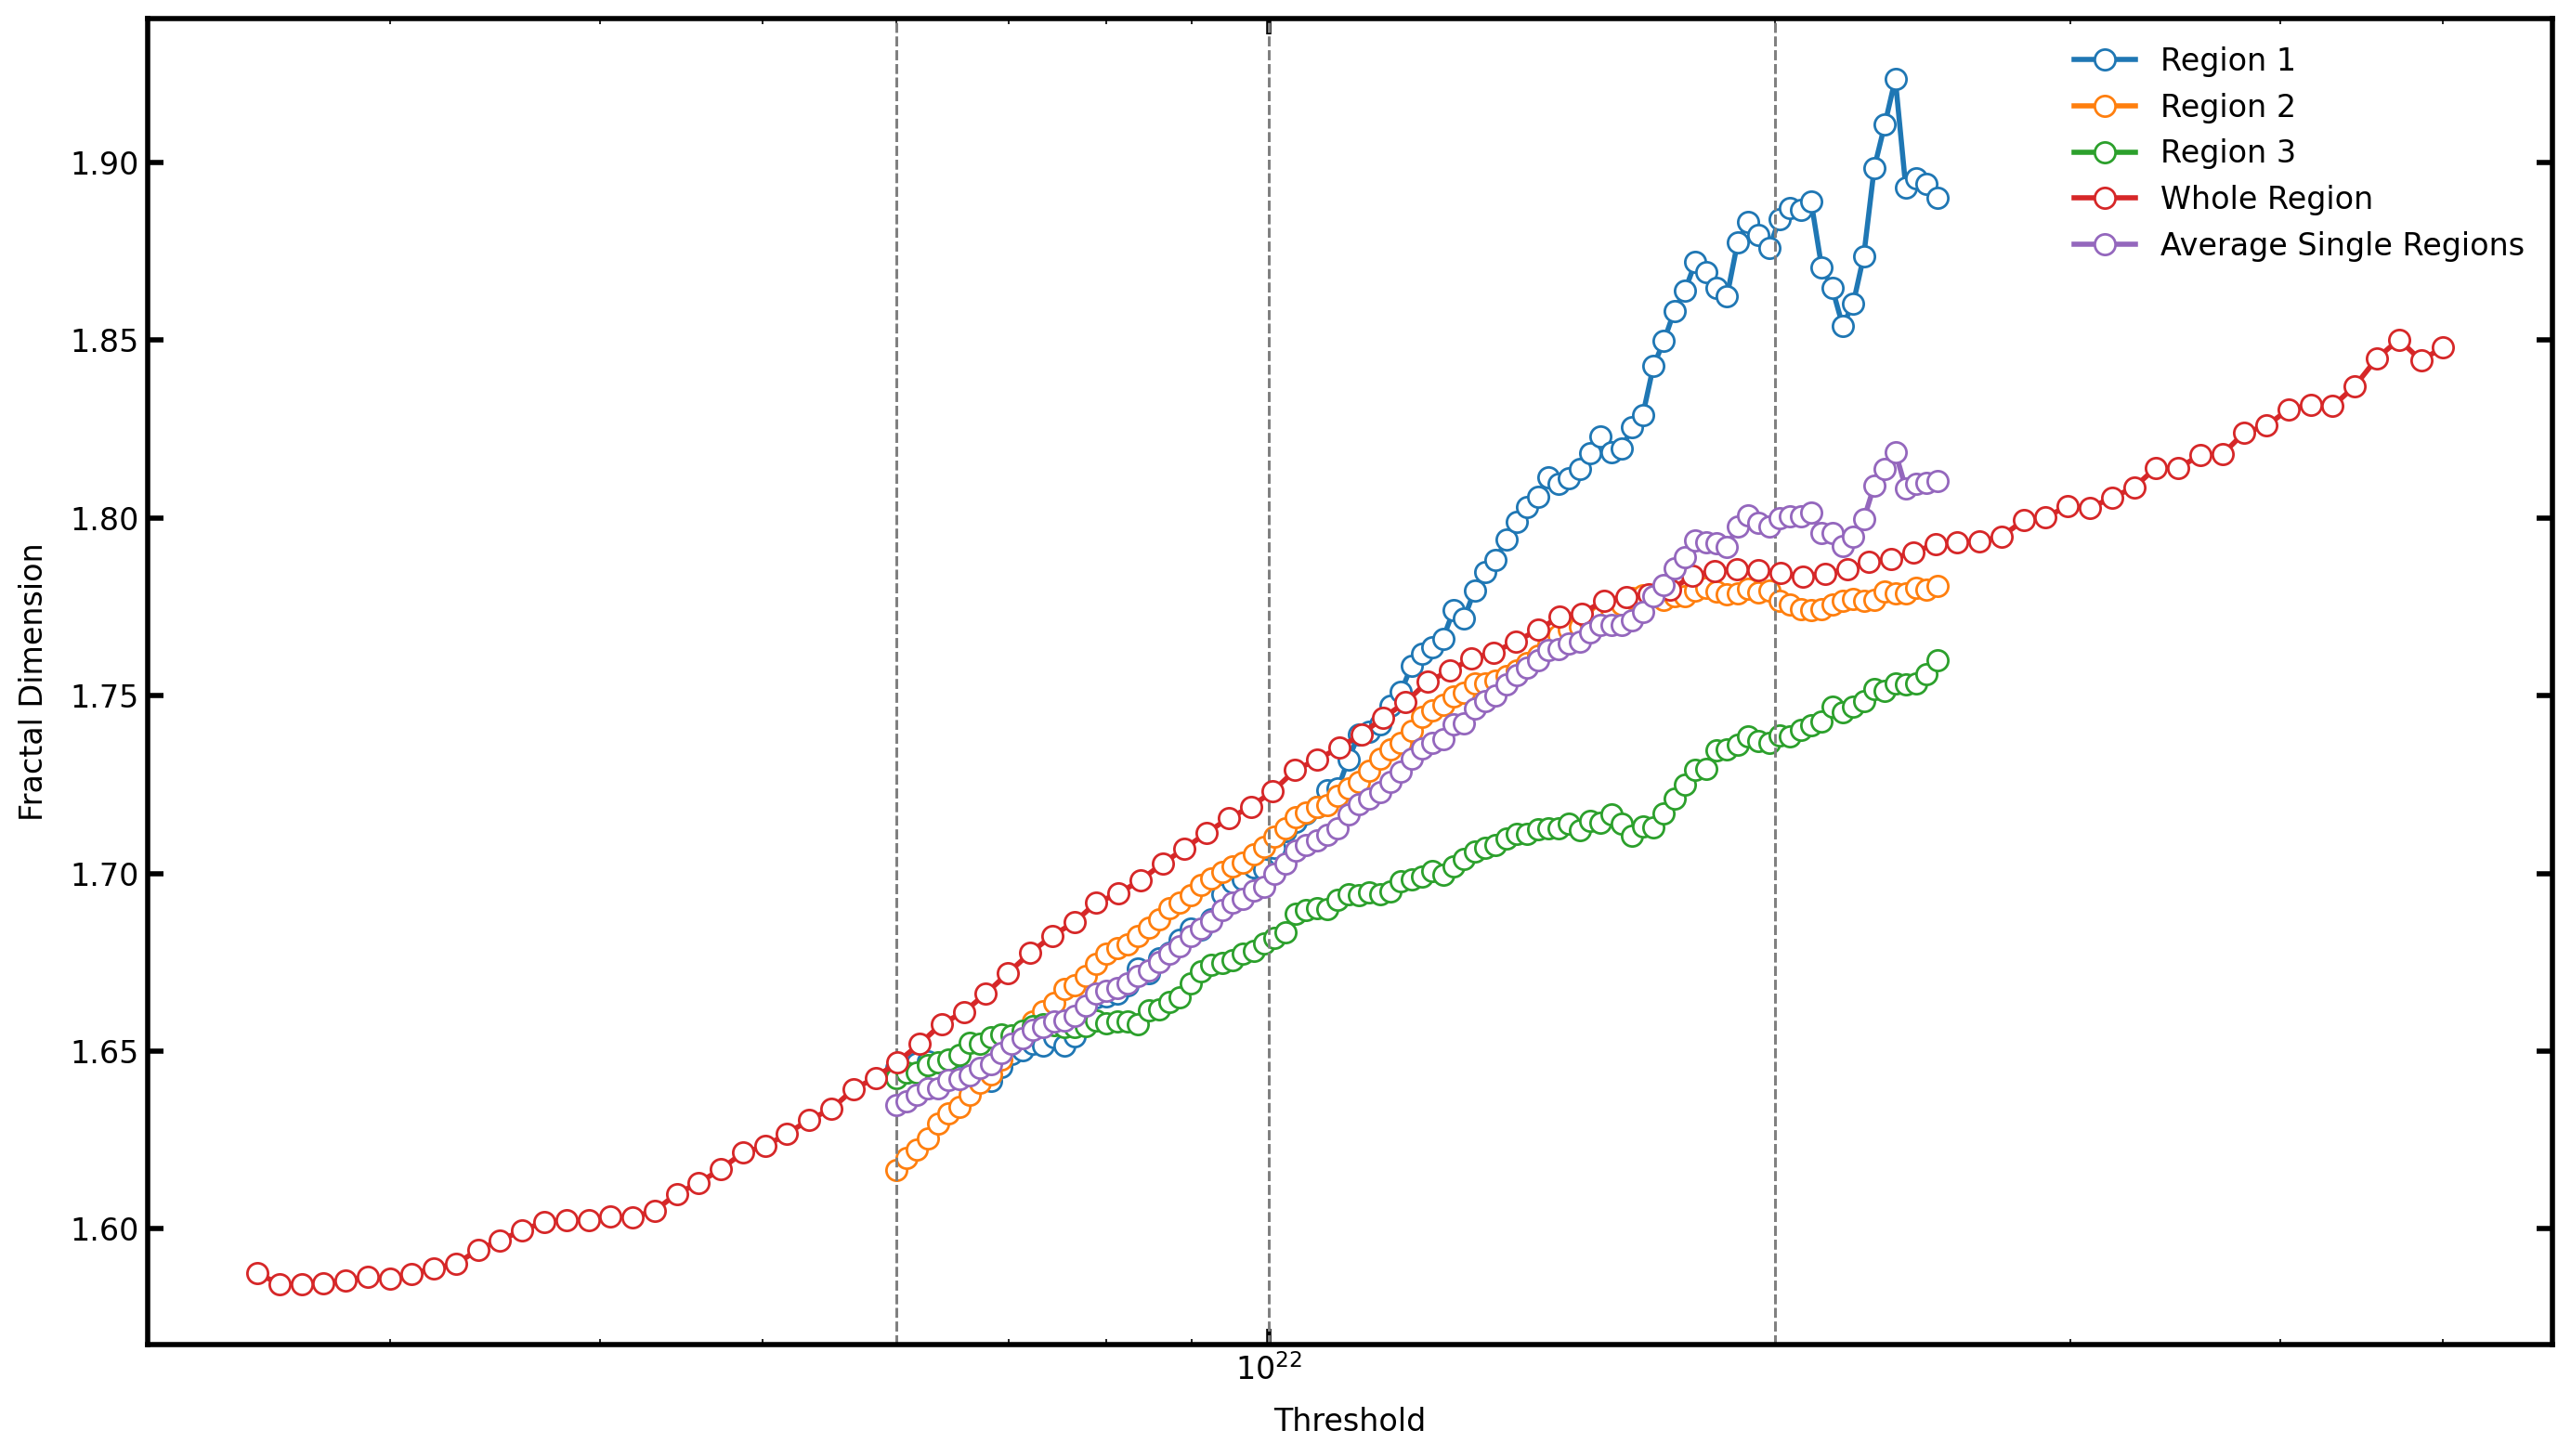

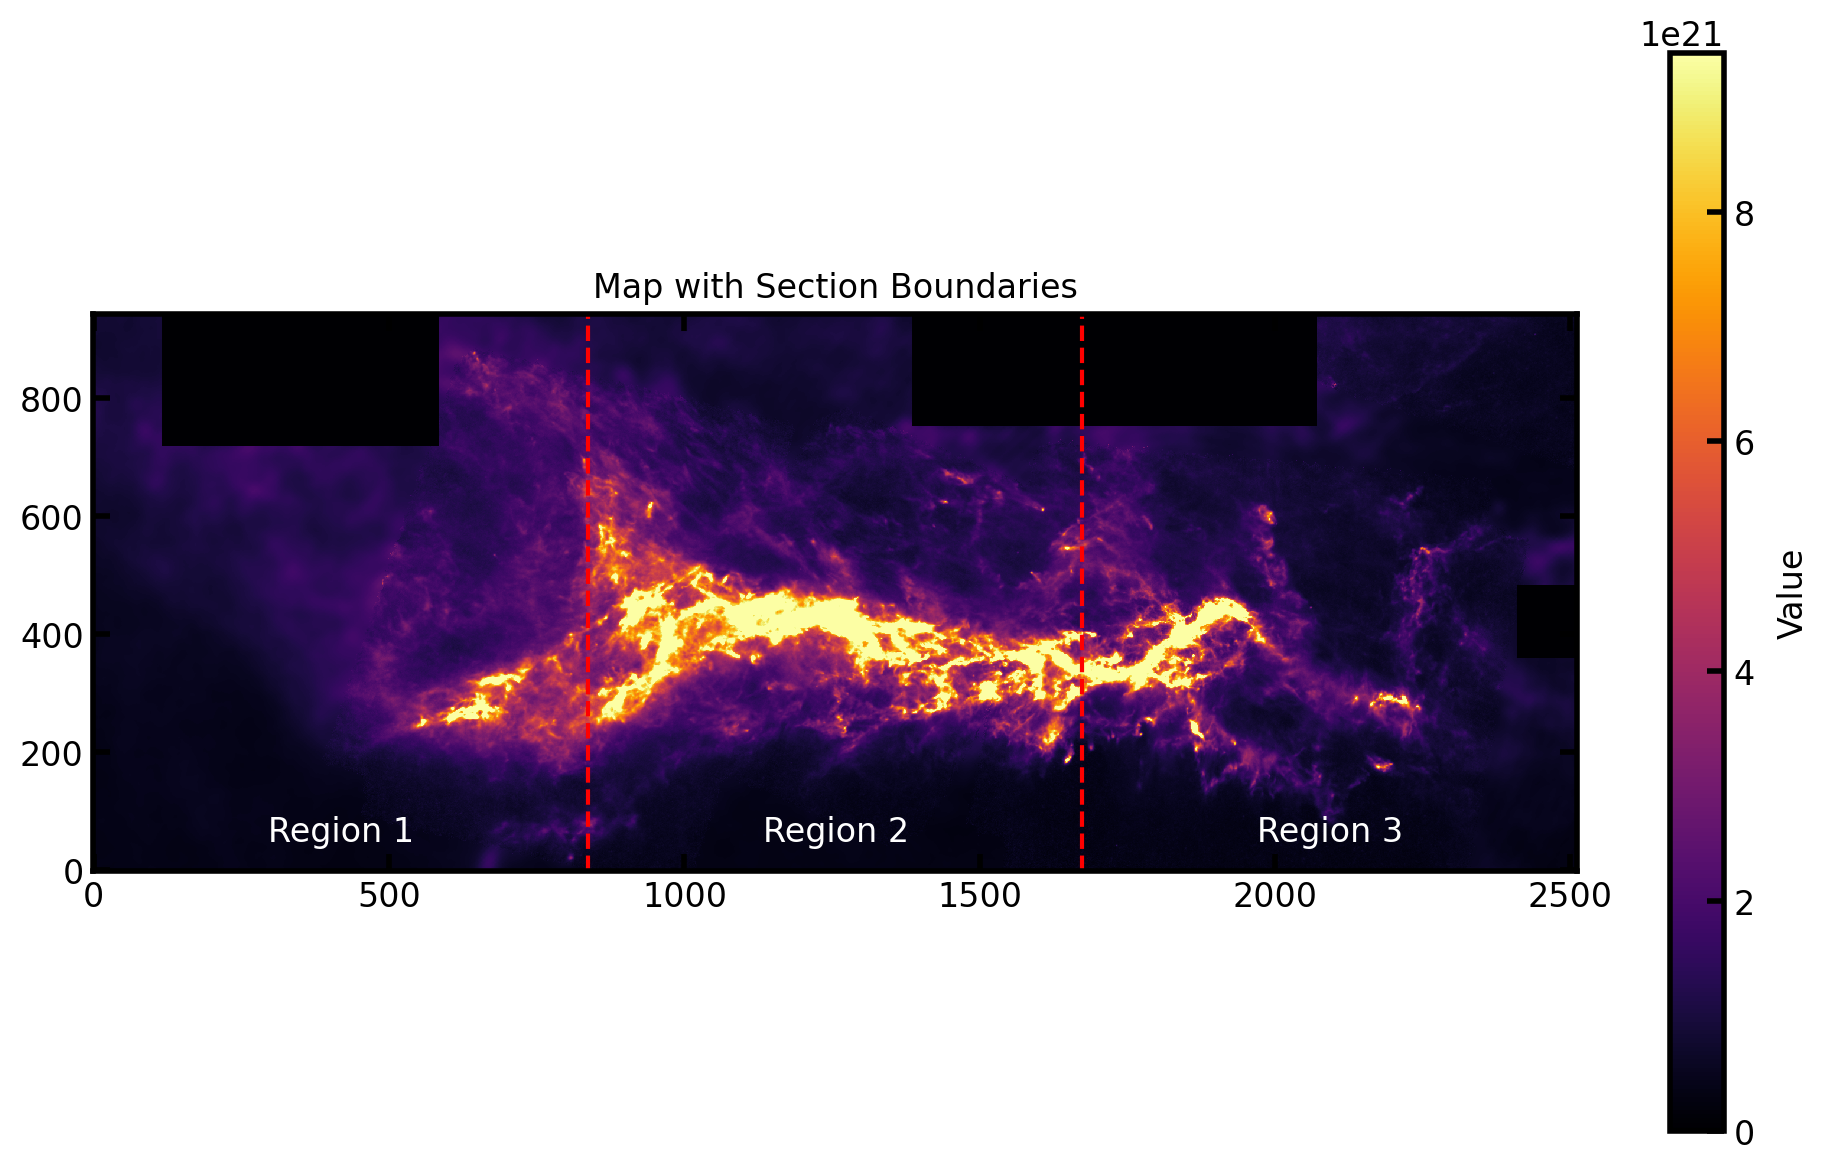

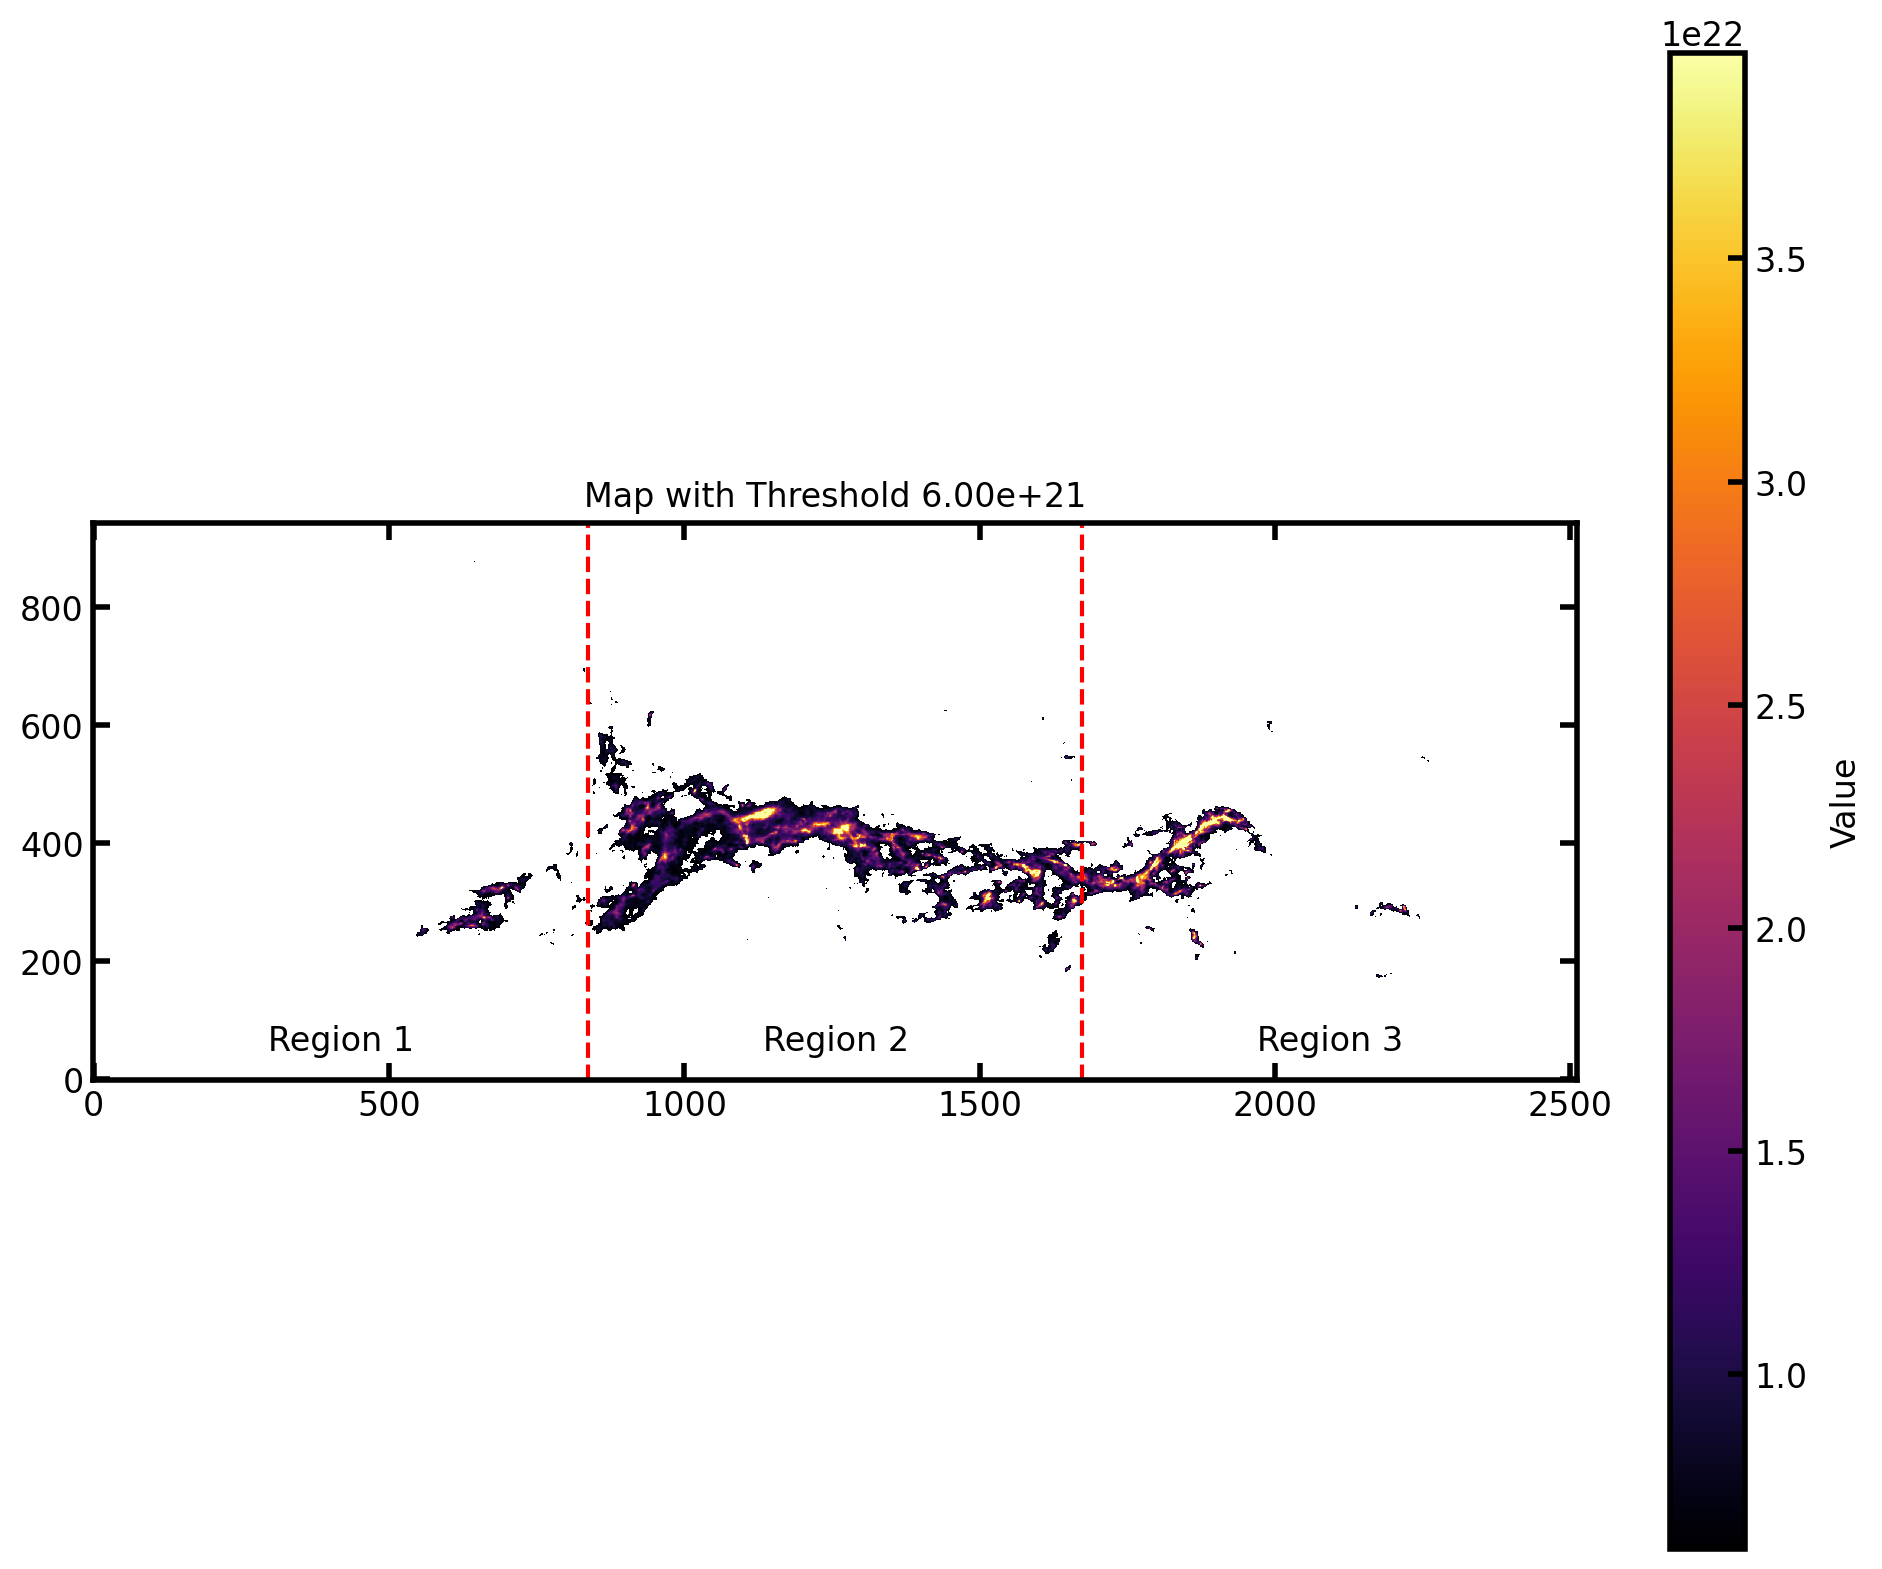

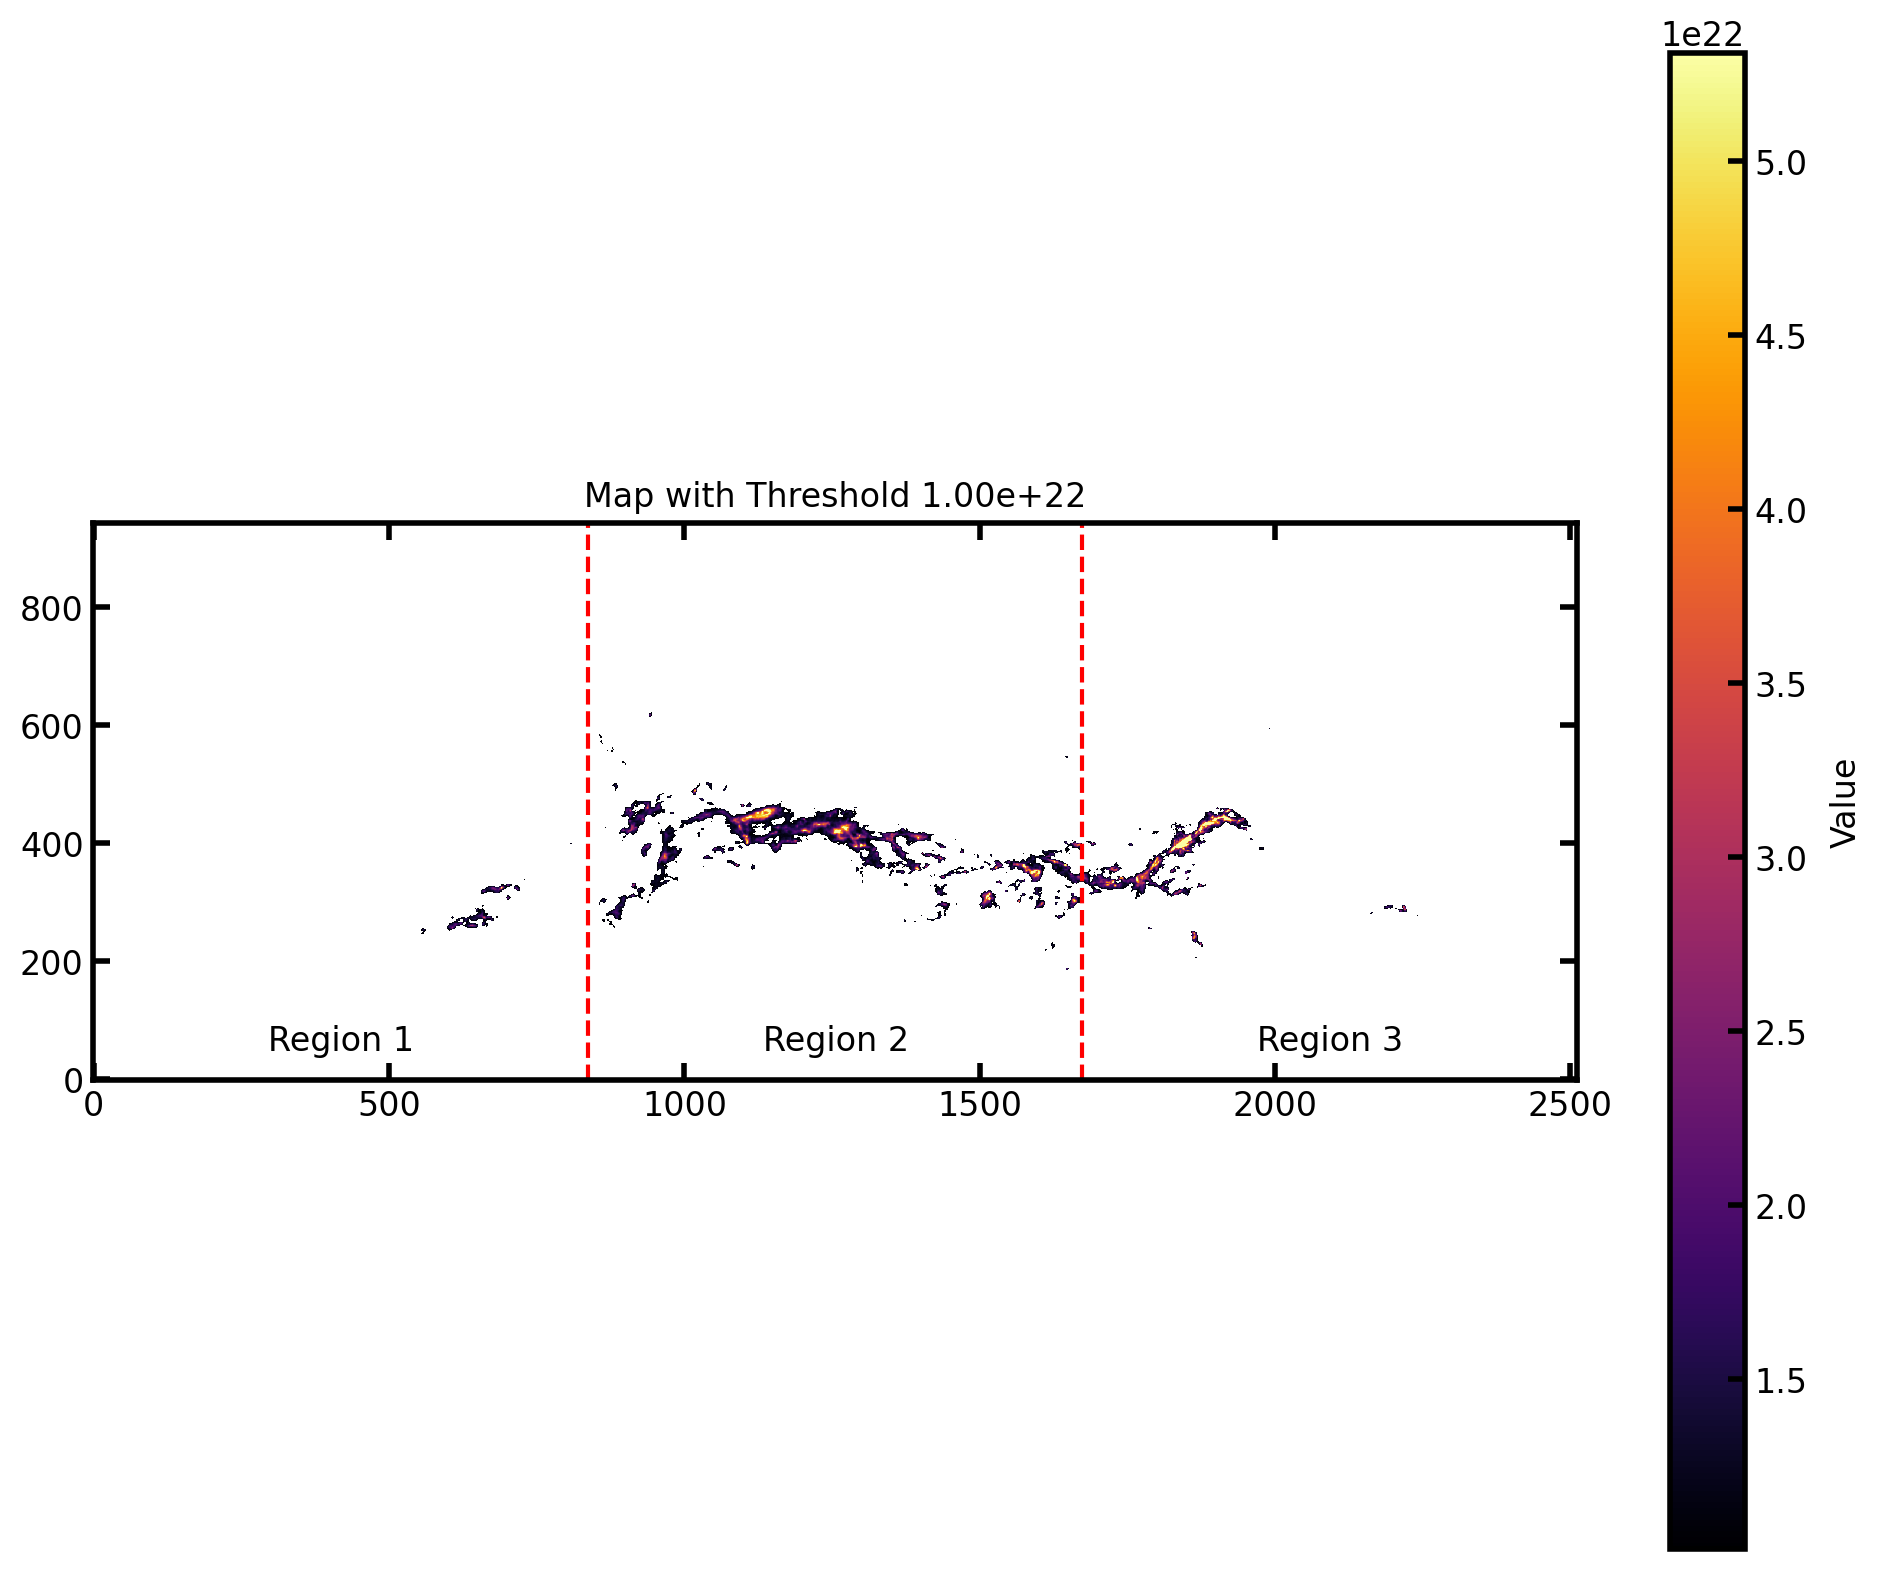

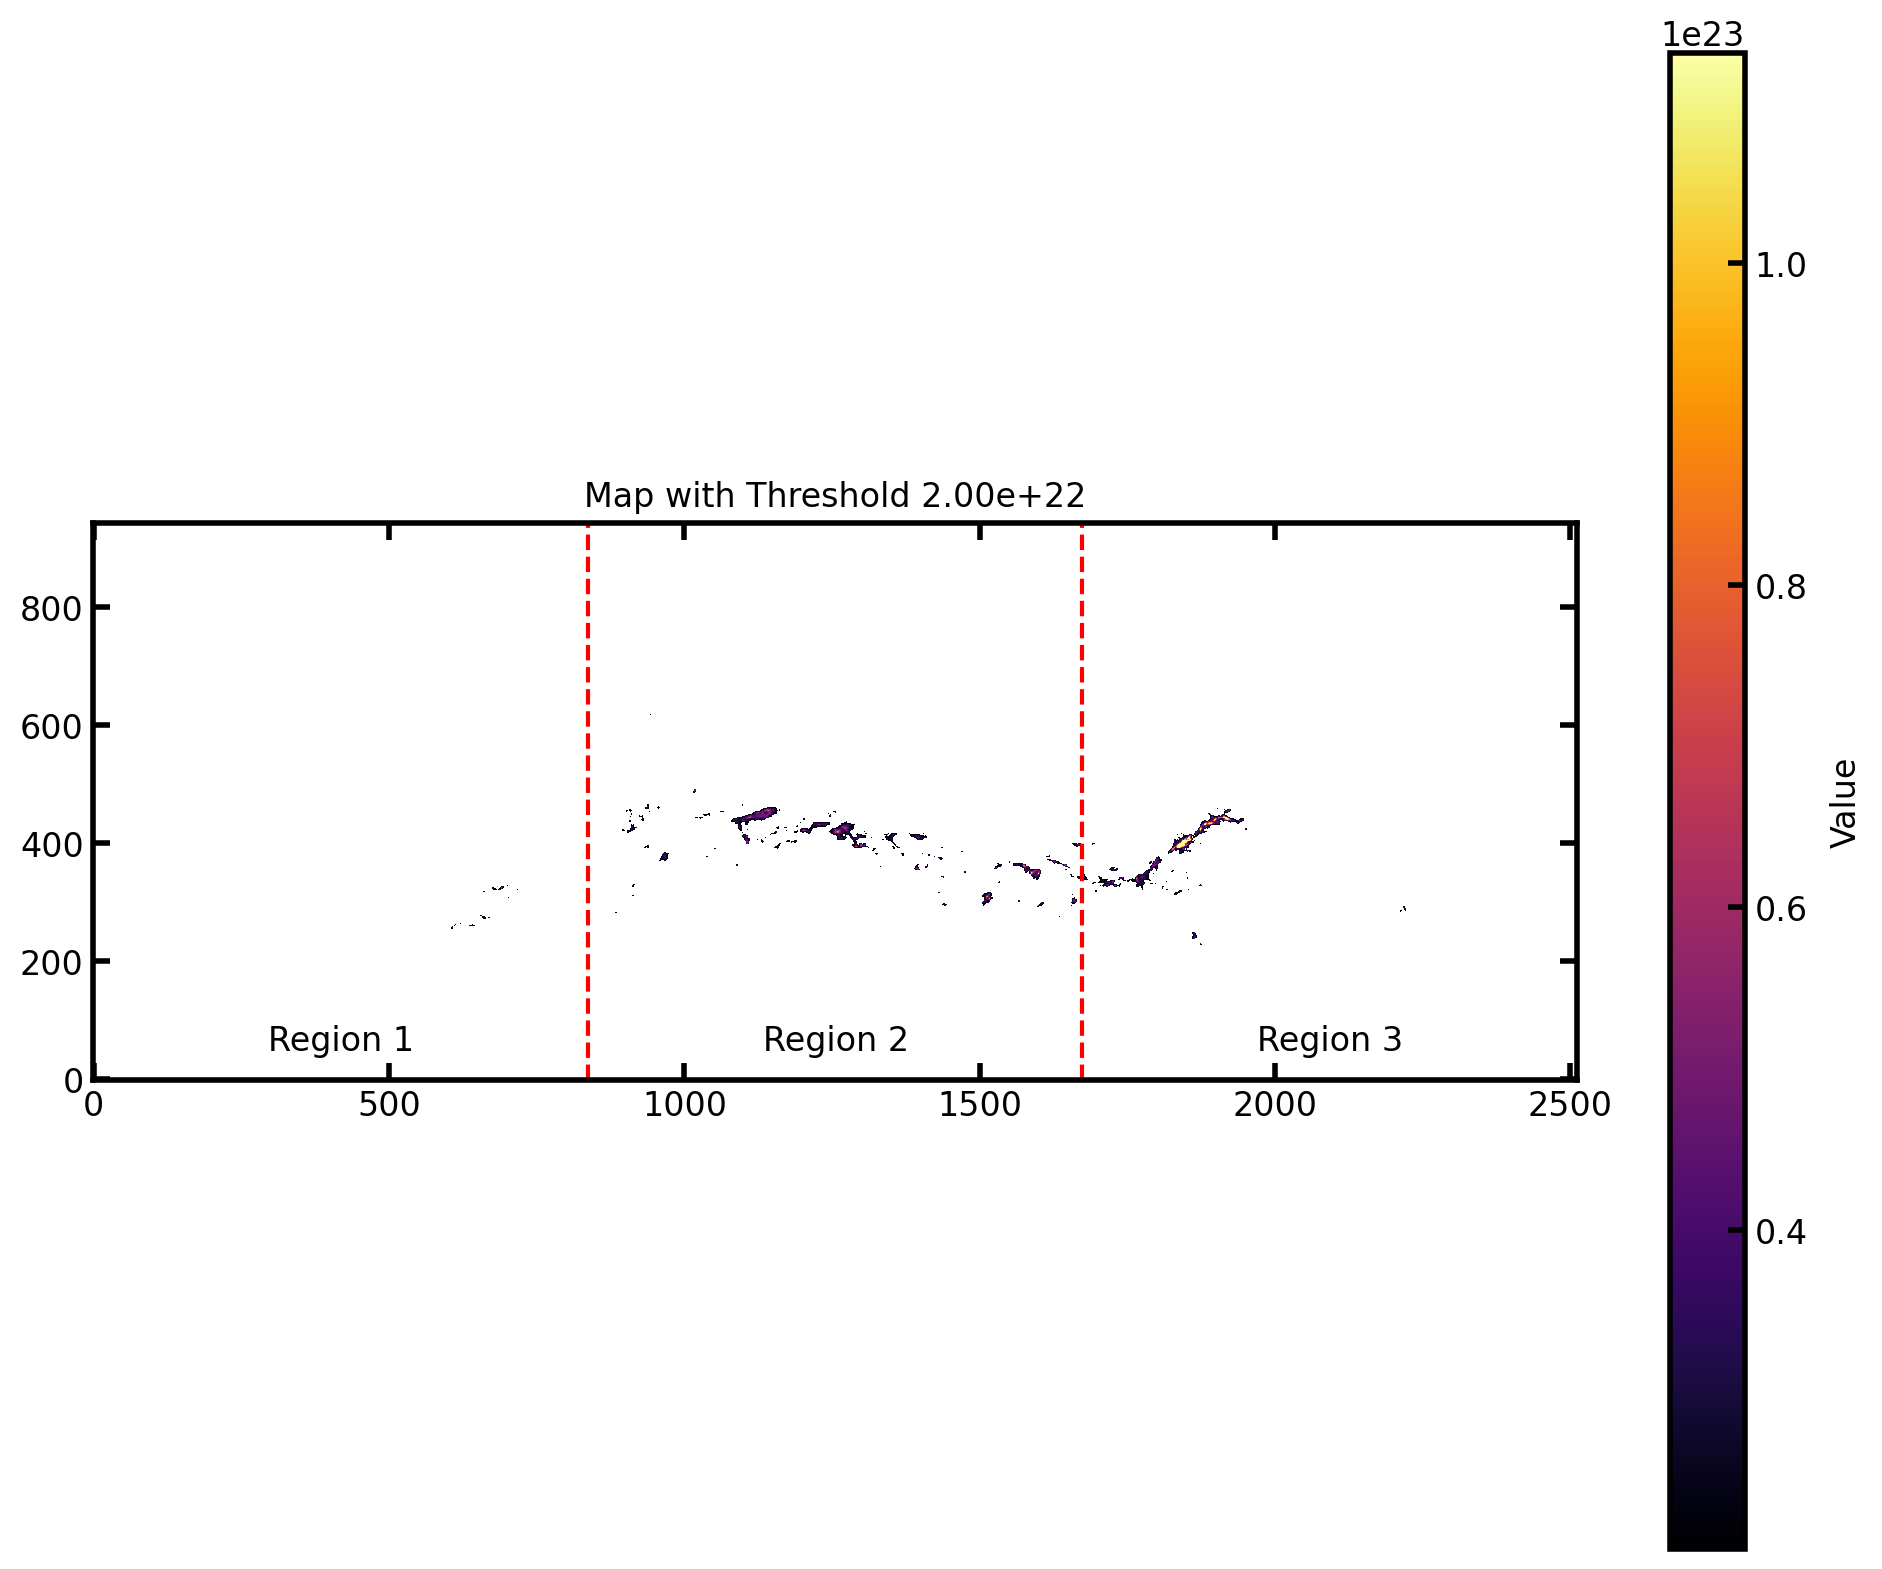

In [5]:
# like above, just divided into N sections
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def show_sections(data, n_regions=3, thresholds = None):
    height, width = data.shape
    # Determine step size for slicing along the y-axis
    w_step = width // n_regions

    # Define the color limits based on percentiles
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    min_value = np.percentile(data, 2)  # 2nd percentile
    max_value = np.percentile(data, 98)  # 98th percentile

    # Plot the entire data map
    plt.figure(figsize=(10, 6))
    plt.imshow(data, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap='inferno')

    # Draw vertical lines to indicate section boundaries and add region labels
    for i in range(1, n_regions):
        plt.axvline(x=i * w_step, color="red", linestyle="--", linewidth=1.5)
        plt.text(i * w_step - w_step // 2, height // 10, f'Region {i}', color='white', fontsize=12, ha='center', va='top')

    # Add label for the last region
    plt.text(width - w_step // 2, height // 10, f'Region {n_regions}', color='white', fontsize=12, ha='center', va='top')

    plt.title("Map with Section Boundaries")
    plt.colorbar(label="Value")
    plt.tight_layout()
    plt.show()

    if thresholds:
        for threshold in thresholds:
            # Create mask for the given threshold
            mask = data >= threshold
            masked_data = np.where(mask, data, np.nan)

            # Define the color limits based on percentiles
            min_value = np.percentile(masked_data[np.isfinite(masked_data)], 2)  # 2nd percentile
            max_value = np.percentile(masked_data[np.isfinite(masked_data)], 98)  # 98th percentile

            # Plot the mask
            plt.figure(figsize=(10, 8))
            plt.imshow(masked_data, vmin=min_value, vmax=max_value, origin='lower', cmap='inferno', interpolation=None)

            # Draw vertical lines to indicate section boundaries and add region labels
            for i in range(1, n_regions):
                plt.axvline(x=i * w_step, color="red", linestyle="--", linewidth=1.5)
                plt.text(i * w_step - w_step // 2, height // 10, f'Region {i}', color='black', fontsize=12, ha='center', va='top')

            # Add label for the last region
            plt.text(width - w_step // 2, height // 10, f'Region {n_regions}', color='black', fontsize=12, ha='center', va='top')

            plt.title(f"Map with Threshold {threshold:.2e}")
            plt.colorbar(label="Value")
            plt.tight_layout()
            plt.show()


def marching_minkowski_functionals(data, n_regions, region_name="Orion A", threshold_min=6e21, threshold_max=2.5e22):
    """
    Calculates the Minkowski functionals for the map divided along the y-axis.

    Parameters:
        data (ndarray): 2D array of the map data.
        region_name (str): Name of the region (for labeling purposes).
        threshold_min (float): Minimum threshold value.
        threshold_max (float): Maximum threshold value.
        n_regions (int): Number of sections to divide into along the y-axis.

    Returns:
        avg_log_areas (ndarray): Averaged log areas over all regions.
        avg_log_perimeters (ndarray): Averaged log perimeters over all regions.
    """
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Get the shape of the data
    height, width = data.shape

    # Determine step size for slicing along the y-axis
    w_step = width // n_regions

    # Storage for results
    all_log_areas = []
    all_log_perimeters = []

    fractal_dimensions = []

    for i in range(n_regions):
        # Slice the region along the y-axis
        region = data[:, i * w_step:(i + 1) * w_step]

        # Store Minkowski Functional values
        areas = []
        perimeters = []

        # Process each threshold
        for threshold in thresholds:
            # Create binary mask
            mask = region >= threshold

            # Compute Area (v0)
            area = np.sum(mask)
            areas.append(area)

            # Compute Perimeter (v1)
            perim = perimeter(mask)  # Assume `perimeter` is defined elsewhere
            perimeters.append(perim)

        # Convert to log scale
        log_areas = np.log10(areas)
        log_perimeters = np.log10(perimeters)

        # Append for averaging
        all_log_areas.append(log_areas)
        all_log_perimeters.append(log_perimeters)

        fractal_dimensions.append([2*log_perimeters/log_areas])

    return fractal_dimensions, thresholds

n_regions = 3 # 2 or 3
thresholds_to_plot = [6e21, 1e22, 2e22]
fractal_dimensions, thresholds = marching_minkowski_functionals(N_H2_OA, n_regions)

plt.figure(figsize=(14, 8))

for i in range(0, n_regions):
    plt.plot(thresholds, fractal_dimensions[i][0], '-o', label="Region "+str(i+1))
    for threshold in thresholds_to_plot:
        plt.axvline(x=threshold, color='gray', linestyle='--', linewidth=1)


thresholds_full = np.logspace(np.log10(2.5e21), np.log10(5e22), 100)
plt.plot(thresholds_full, results_OA["fractal_dimension"], '-o', label="Whole Region")
plt.plot(thresholds, np.mean(fractal_dimensions, axis=0)[0], '-o', label="Average Single Regions")

plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.legend()

show_sections(N_H2_OA, n_regions, thresholds_to_plot)

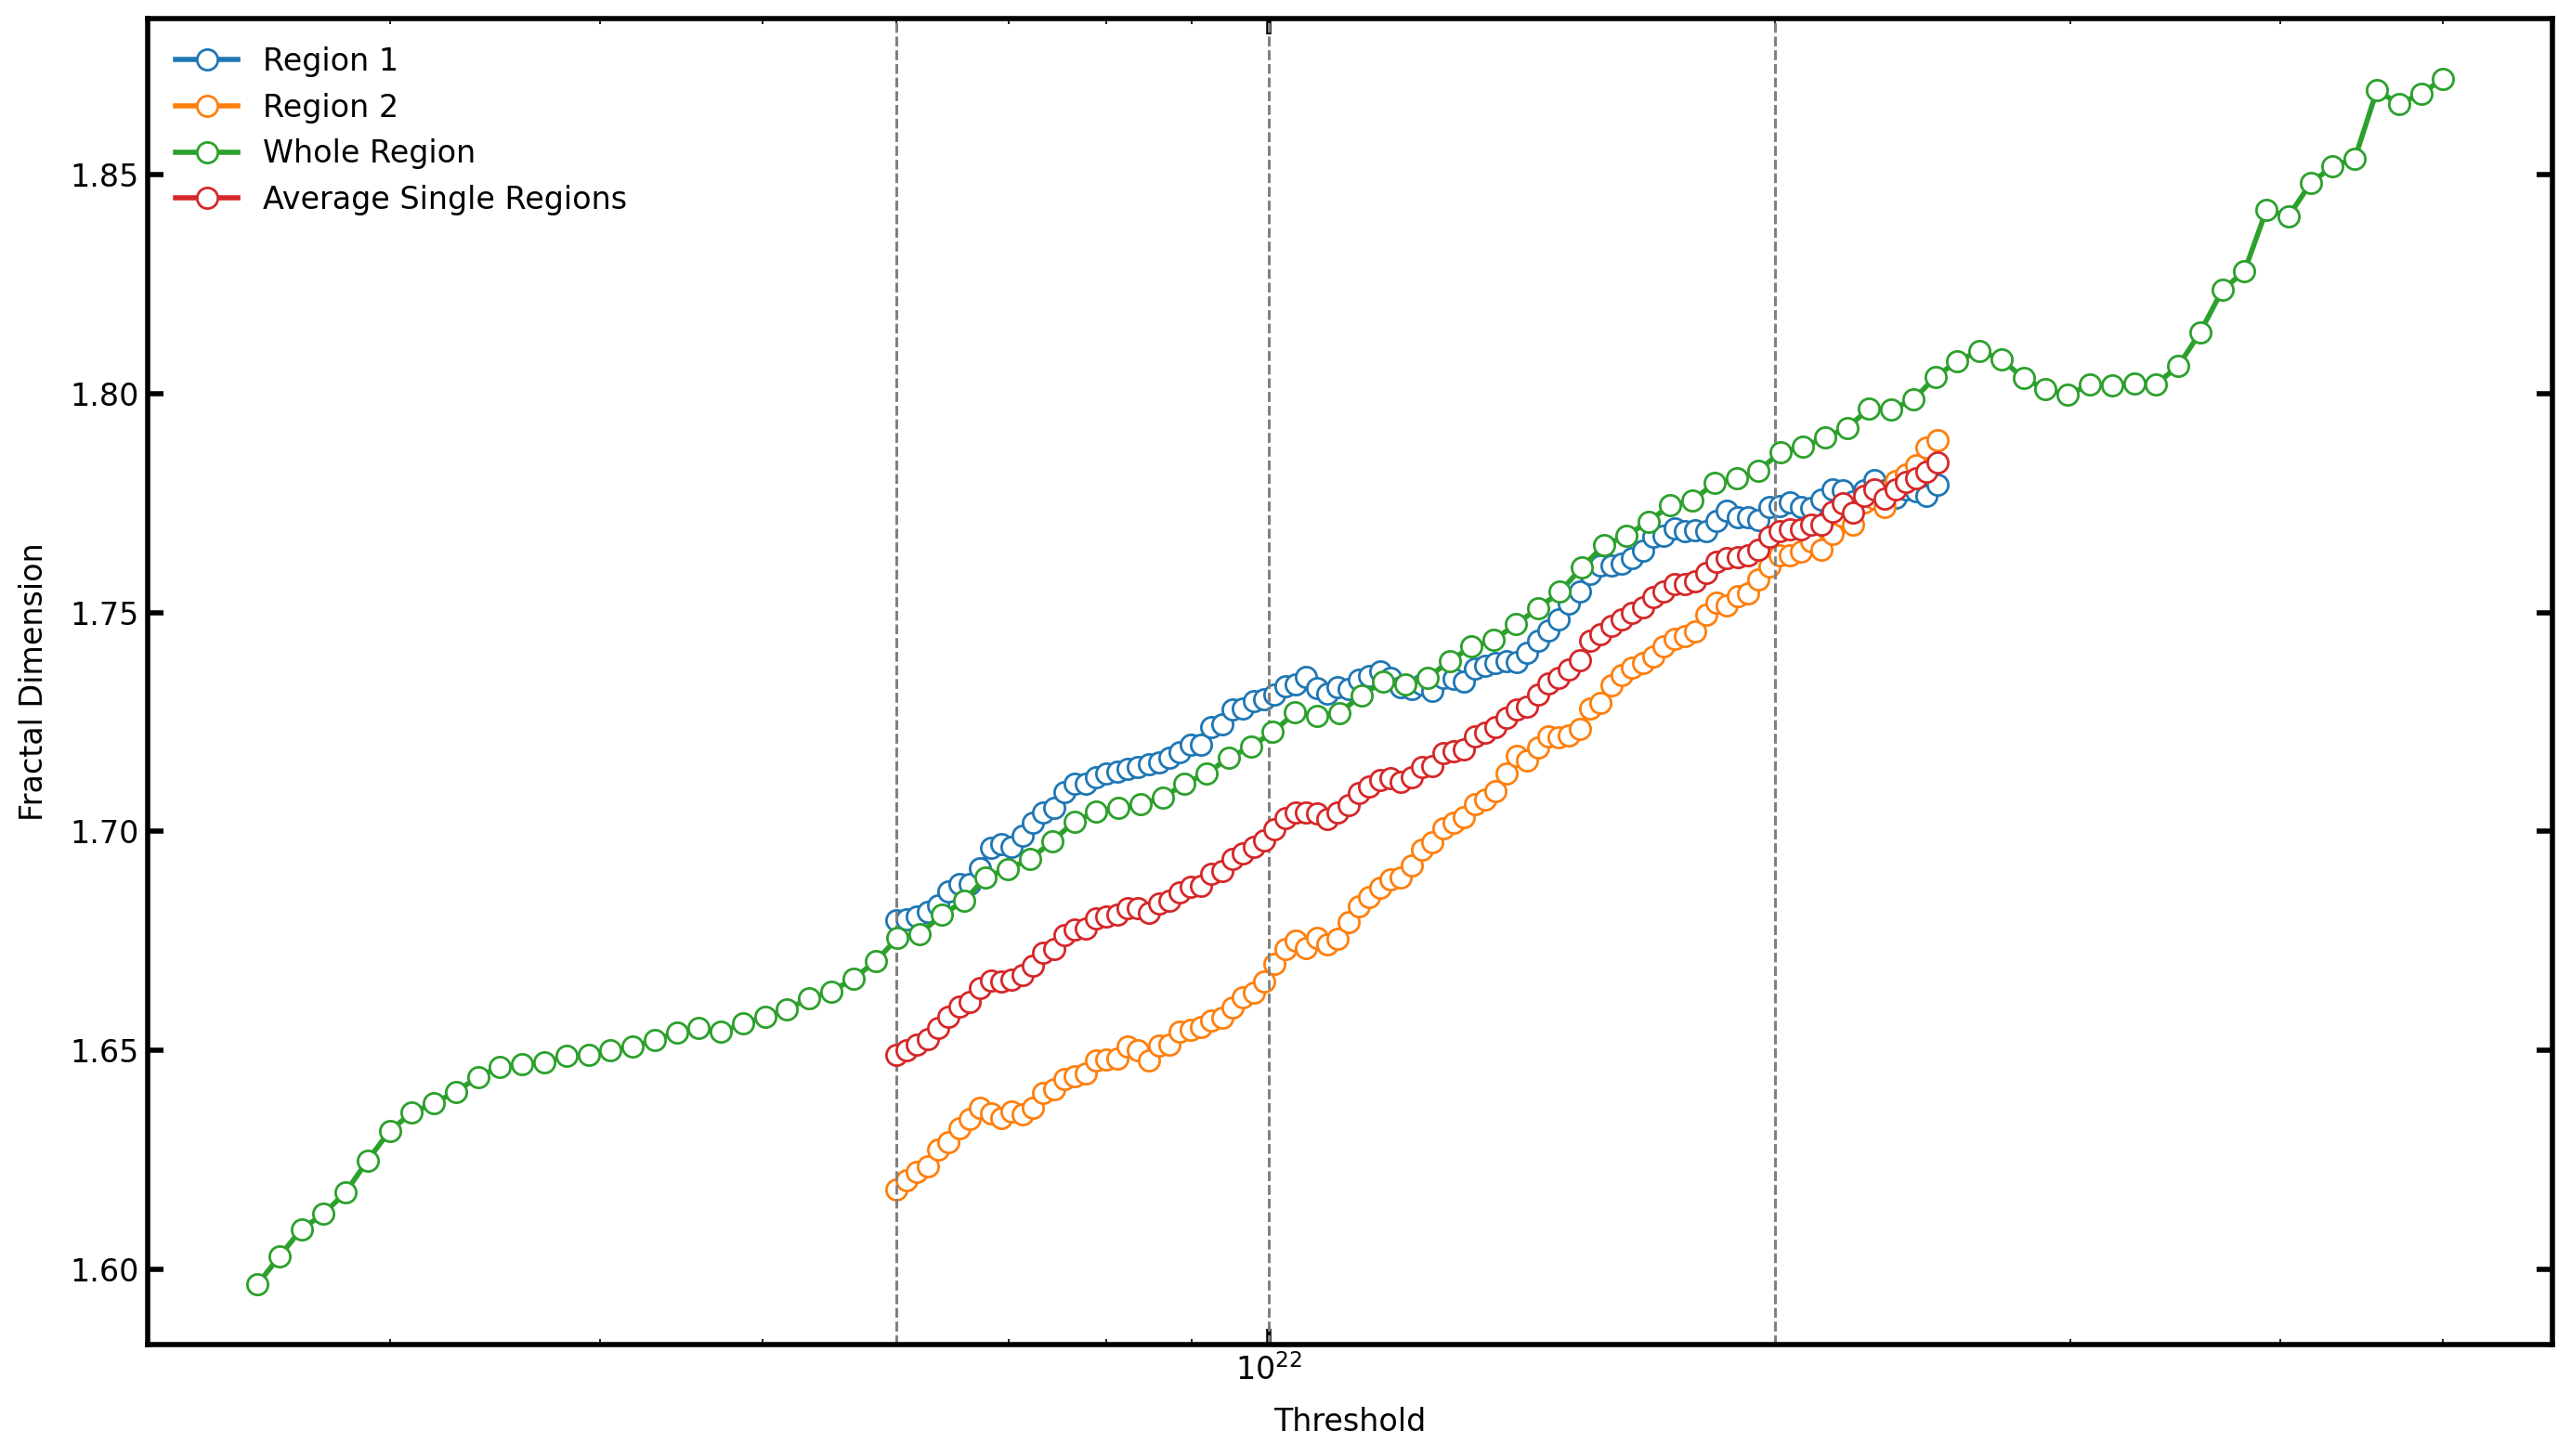

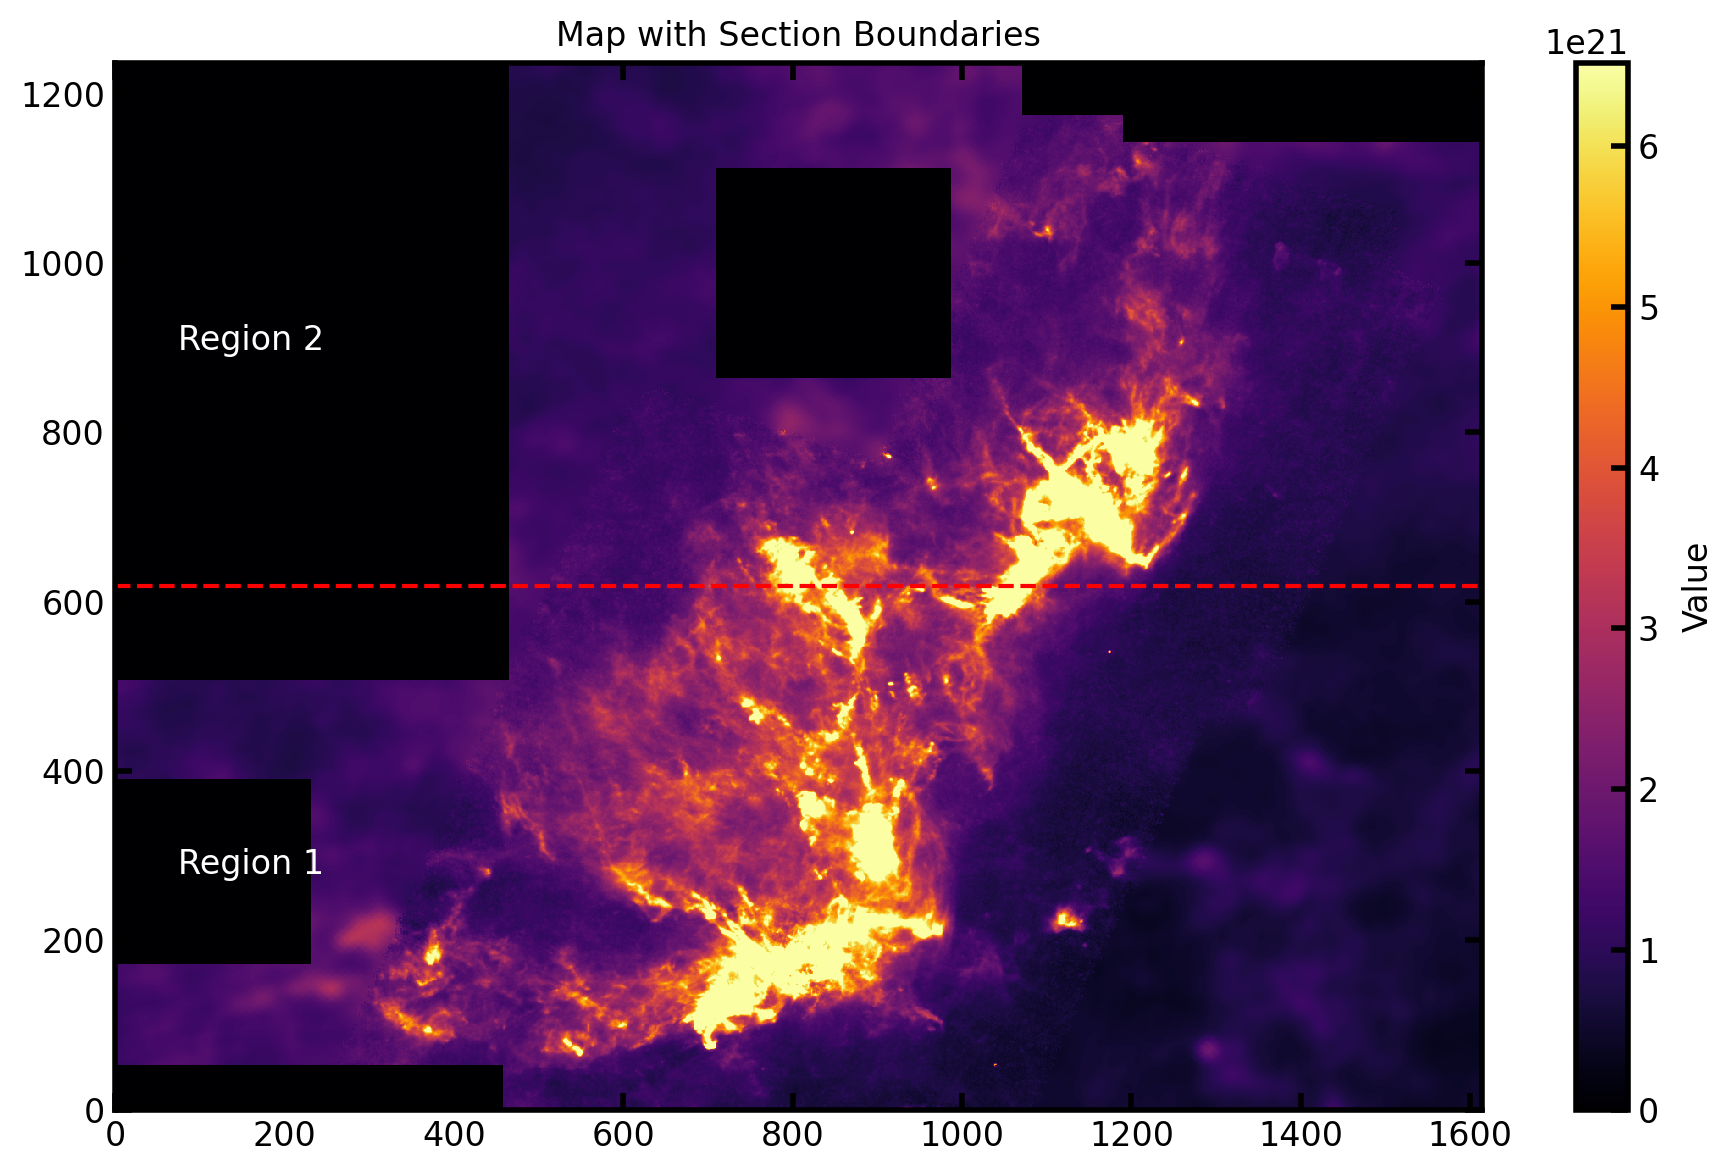

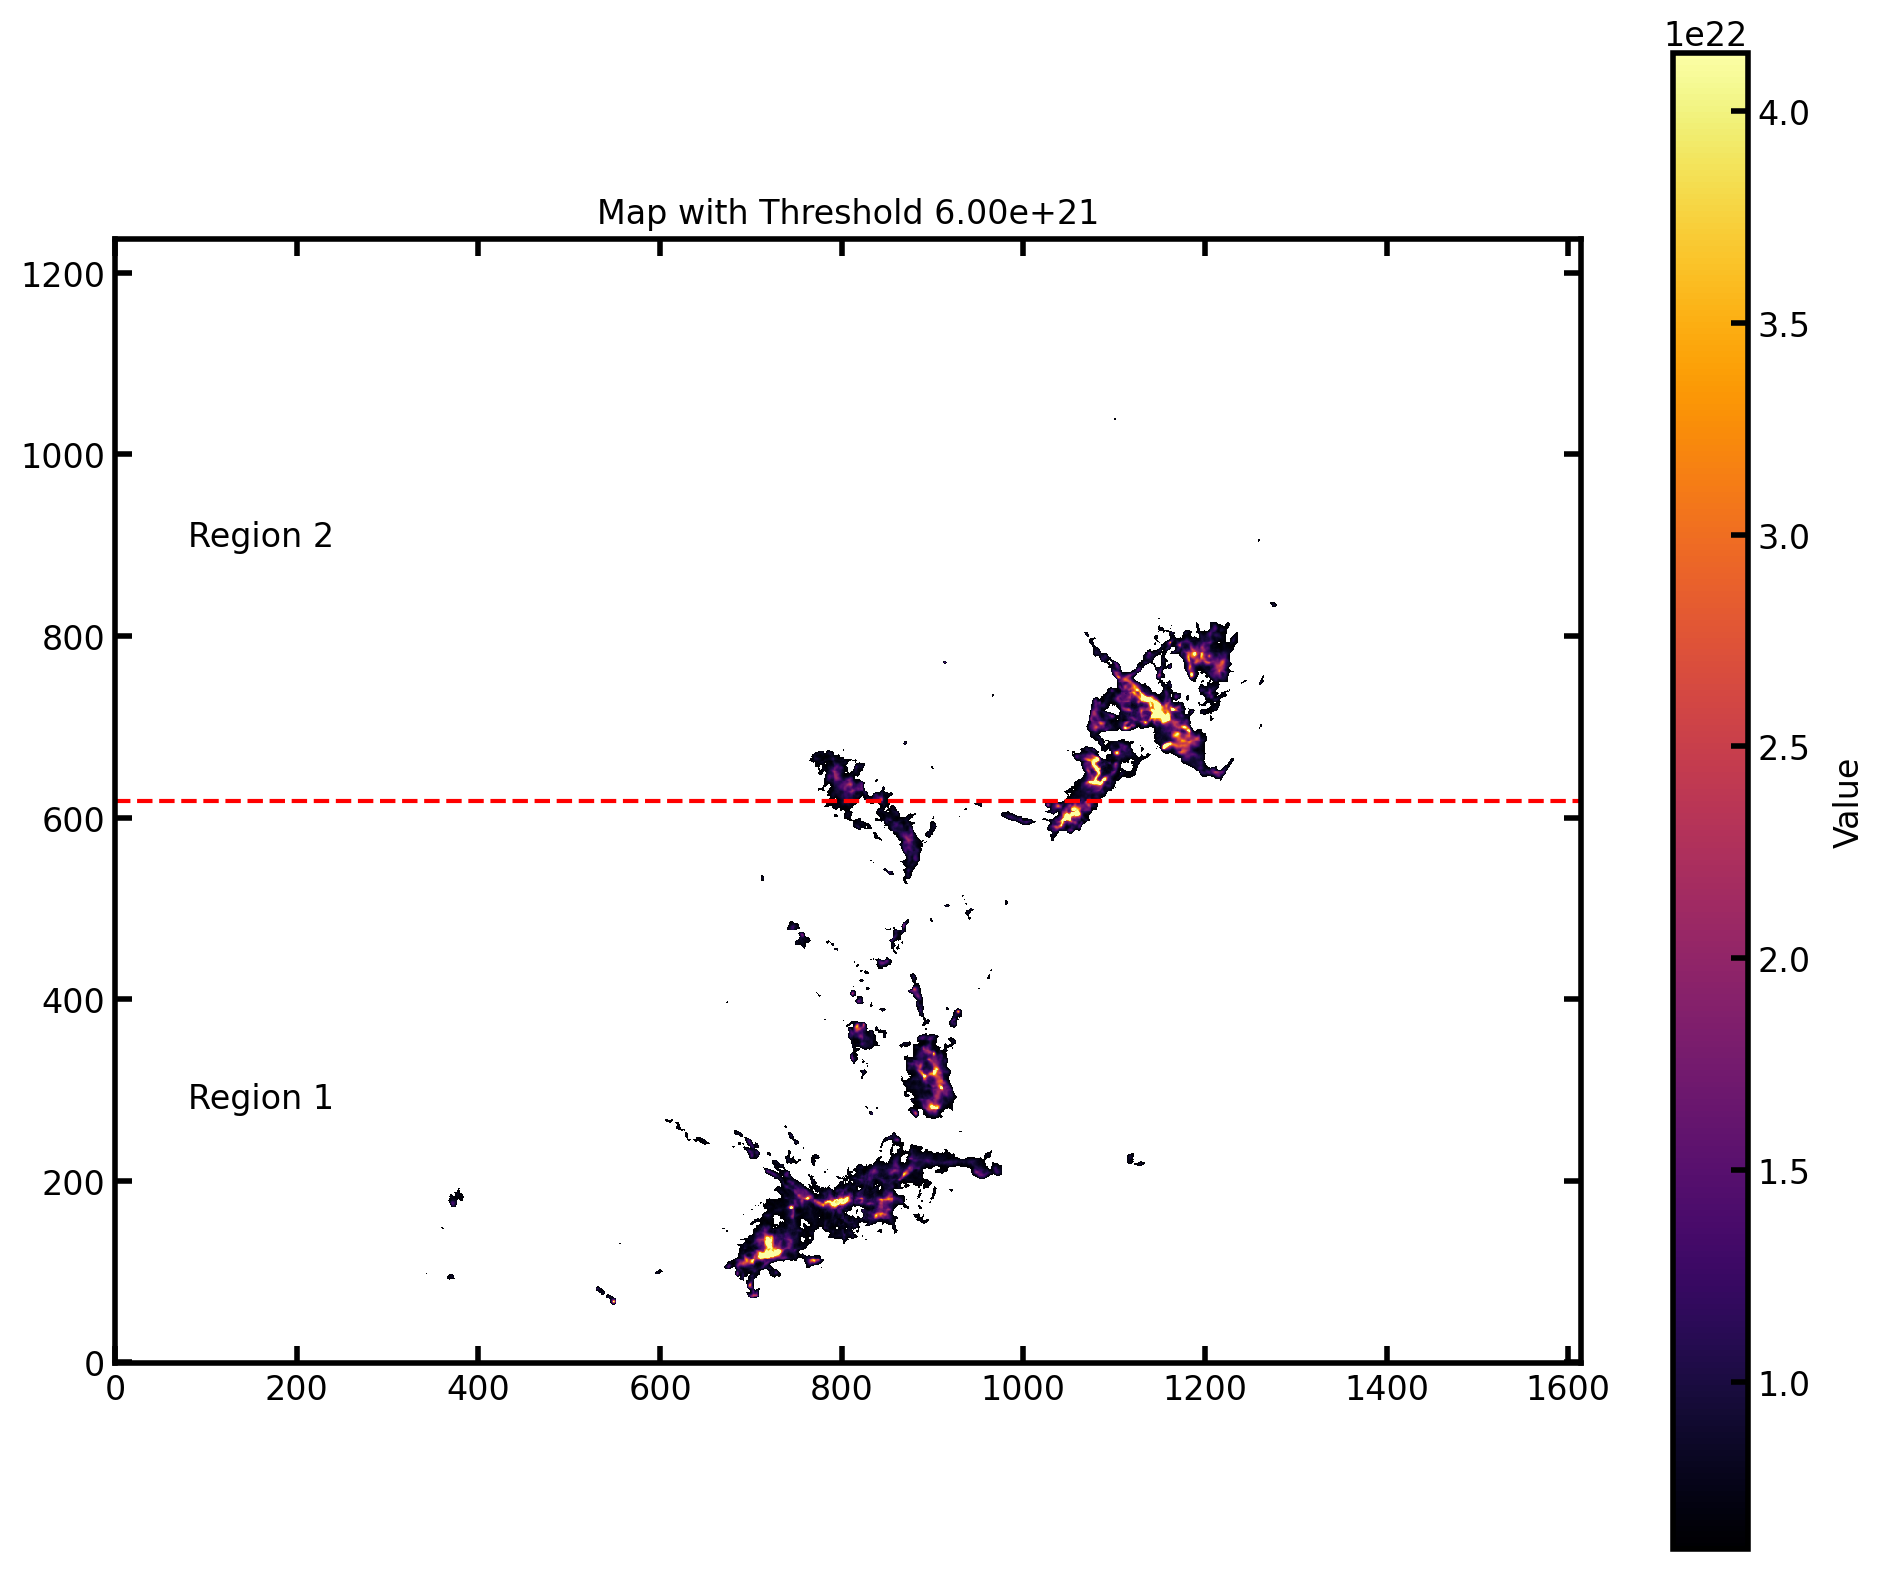

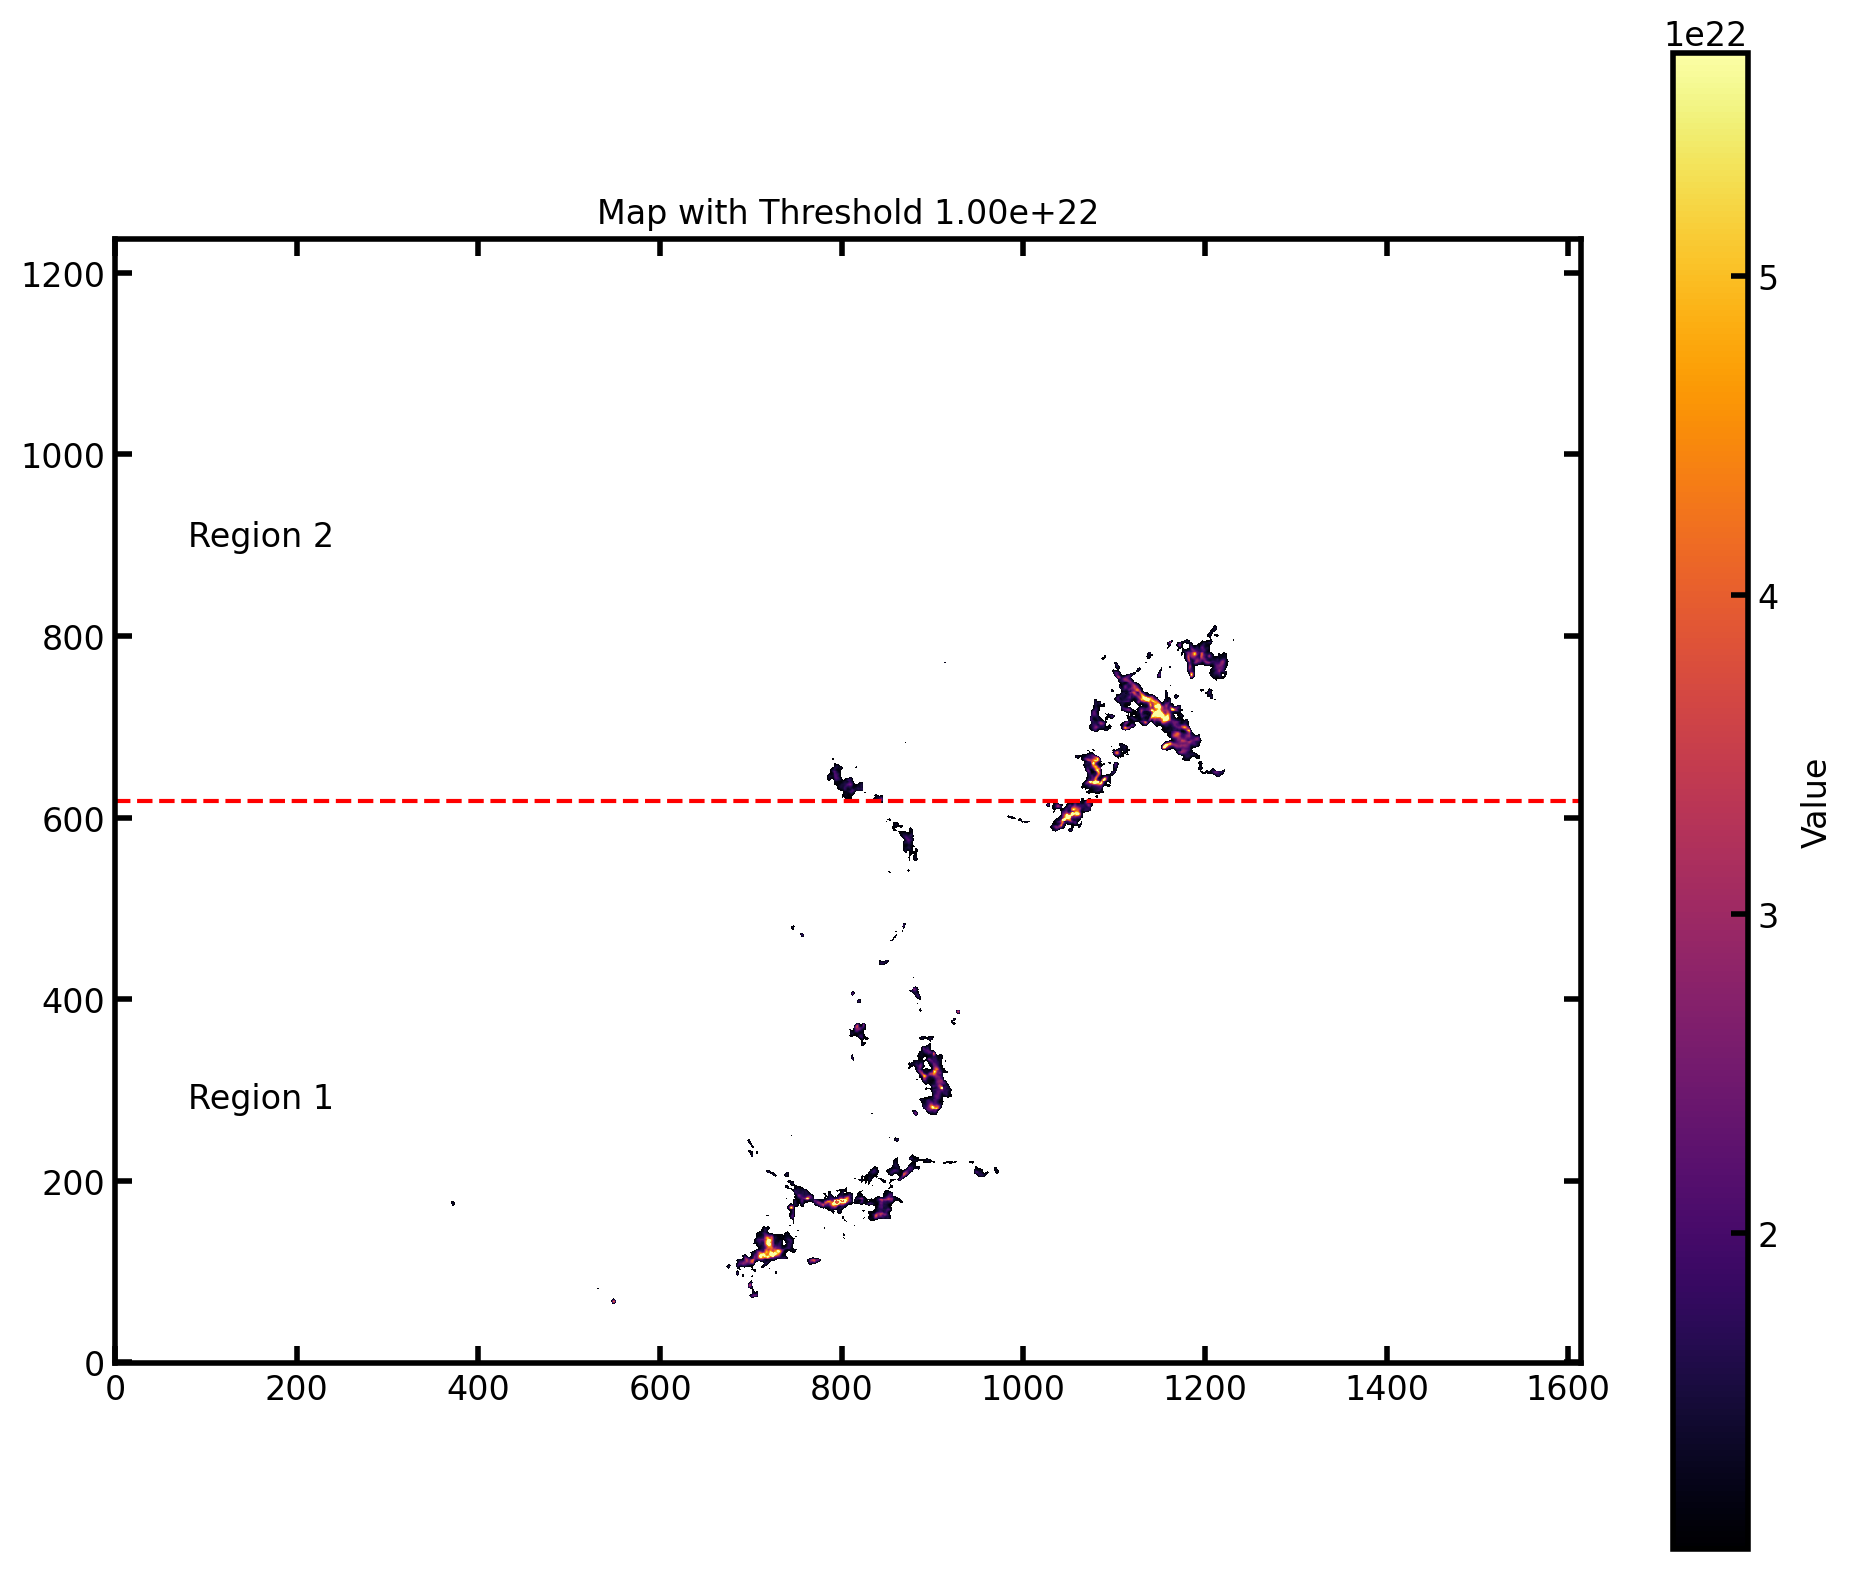

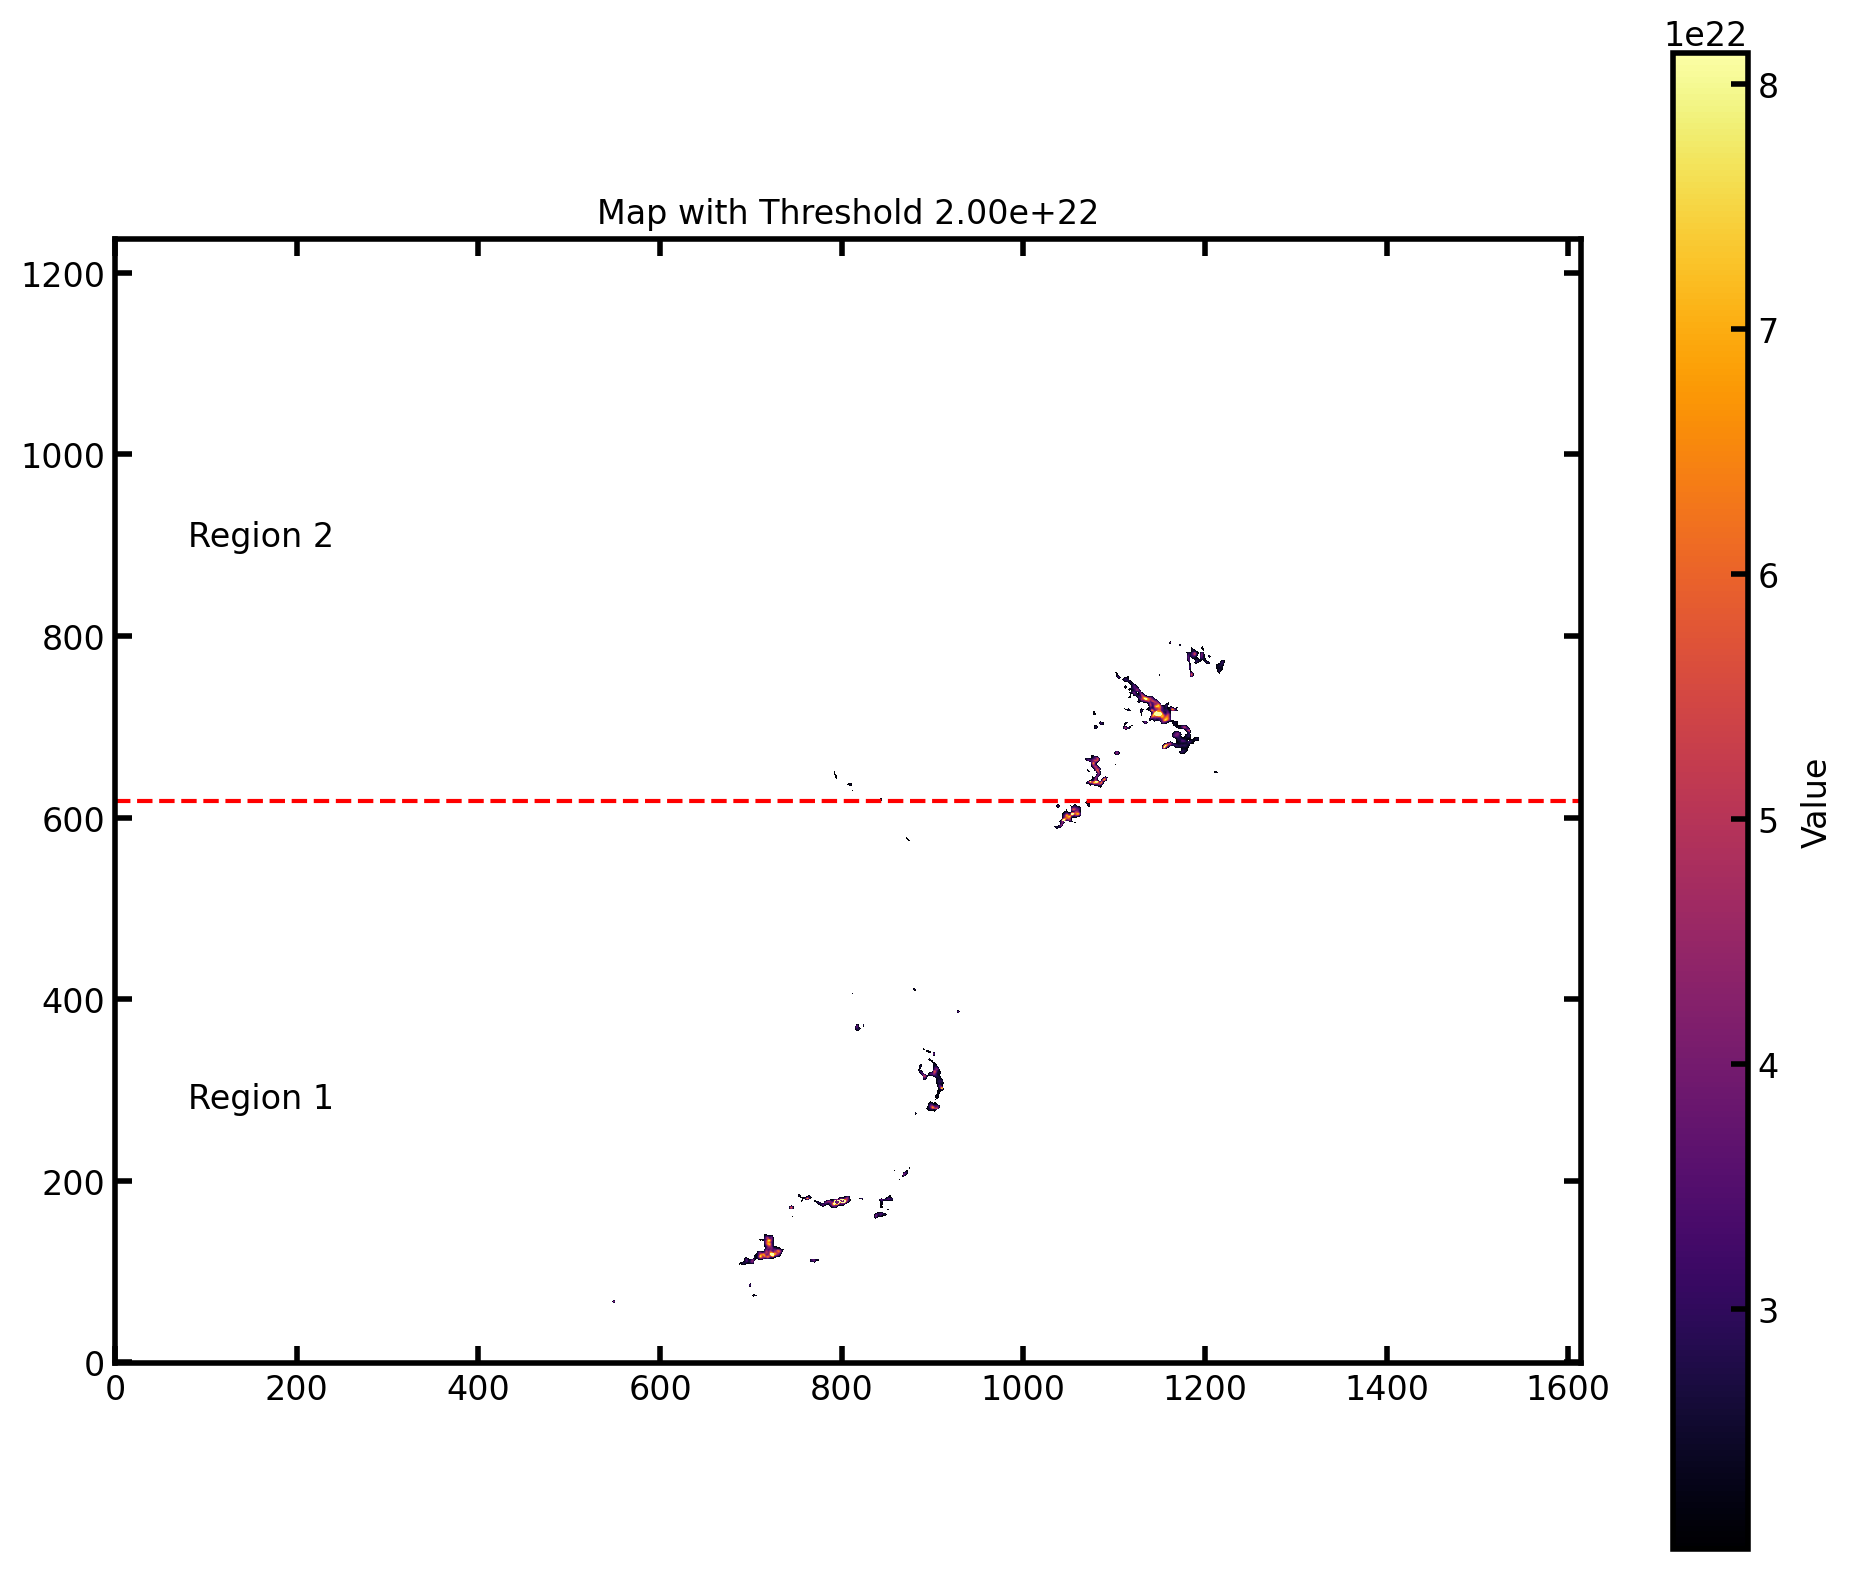

In [6]:
def show_sections(data, n_regions=3, thresholds=None):
    height, width = data.shape
    # Determine step size for slicing along the y-axis
    h_step = height // n_regions

    # Define the color limits based on percentiles
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    min_value = np.percentile(data, 2)  # 2nd percentile
    max_value = np.percentile(data, 98)  # 98th percentile

    # Plot the entire data map
    plt.figure(figsize=(10, 6))
    plt.imshow(data, vmin=min_value, vmax=max_value, interpolation=None, origin='lower', cmap='inferno')

    # Draw horizontal lines to indicate section boundaries and add region labels
    for i in range(1, n_regions):
        plt.axhline(y=i * h_step, color="red", linestyle="--", linewidth=1.5)
        plt.text(width // 10, i * h_step - h_step // 2, f'Region {i}', color='white', fontsize=12, ha='center', va='top')

    # Add label for the last region
    plt.text(width // 10, height - h_step // 2, f'Region {n_regions}', color='white', fontsize=12, ha='center', va='top')

    plt.title("Map with Section Boundaries")
    plt.colorbar(label="Value")
    plt.tight_layout()
    plt.show()

    if thresholds:
        for threshold in thresholds:
            # Create mask for the given threshold
            mask = data >= threshold
            masked_data = np.where(mask, data, np.nan)

            # Define the color limits based on percentiles
            min_value = np.percentile(masked_data[np.isfinite(masked_data)], 2)  # 2nd percentile
            max_value = np.percentile(masked_data[np.isfinite(masked_data)], 98)  # 98th percentile

            # Plot the mask
            plt.figure(figsize=(10, 8))
            plt.imshow(masked_data, vmin=min_value, vmax=max_value, origin='lower', cmap='inferno', interpolation=None)

            # Draw horizontal lines to indicate section boundaries and add region labels
            for i in range(1, n_regions):
                plt.axhline(y=i * h_step, color="red", linestyle="--", linewidth=1.5)
                plt.text(width // 10, i * h_step - h_step // 2, f'Region {i}', color='black', fontsize=12, ha='center', va='top')

            # Add label for the last region
            plt.text(width // 10, height - h_step // 2, f'Region {n_regions}', color='black', fontsize=12, ha='center', va='top')

            plt.title(f"Map with Threshold {threshold:.2e}")
            plt.colorbar(label="Value")
            plt.tight_layout()
            plt.show()

    

def marching_minkowski_functionals(data, n_regions, region_name="Orion A", threshold_min=6e21, threshold_max=2.5e22):
    """
    Calculates the Minkowski functionals for the map divided along the y-axis.

    Parameters:
        data (ndarray): 2D array of the map data.
        region_name (str): Name of the region (for labeling purposes).
        threshold_min (float): Minimum threshold value.
        threshold_max (float): Maximum threshold value.
        n_regions (int): Number of sections to divide into along the y-axis.

    Returns:
        avg_log_areas (ndarray): Averaged log areas over all regions.
        avg_log_perimeters (ndarray): Averaged log perimeters over all regions.
    """
    thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Get the shape of the data
    height, width = data.shape

    # Determine step size for slicing along the y-axis
    h_step = height // n_regions

    # Storage for results
    all_log_areas = []
    all_log_perimeters = []

    fractal_dimensions = []

    for i in range(n_regions):
        # Slice the region along the y-axis
        region = data[i * h_step:(i + 1) * h_step, :]

        # Store Minkowski Functional values
        areas = []
        perimeters = []

        # Process each threshold
        for threshold in thresholds:
            # Create binary mask
            mask = region >= threshold

            # Compute Area (v0)
            area = np.sum(mask)
            areas.append(area)

            # Compute Perimeter (v1)
            perim = perimeter(mask)  # Assume `perimeter` is defined elsewhere
            perimeters.append(perim)

        # Convert to log scale
        log_areas = np.log10(areas)
        log_perimeters = np.log10(perimeters)

        # Append for averaging
        all_log_areas.append(log_areas)
        all_log_perimeters.append(log_perimeters)

        fractal_dimensions.append([2*log_perimeters/log_areas])

    return fractal_dimensions, thresholds

n_regions = 2 # 2 or 3
thresholds_to_plot = [6e21, 1e22, 2e22]
fractal_dimensions, thresholds = marching_minkowski_functionals(N_H2_OB, n_regions)

plt.figure(figsize=(14, 8))

for i in range(0, n_regions):
    plt.plot(thresholds, fractal_dimensions[i][0], '-o', label="Region "+str(i+1))
    for threshold in thresholds_to_plot:
        plt.axvline(x=threshold, color='gray', linestyle='--', linewidth=1)

thresholds_full = np.logspace(np.log10(2.5e21), np.log10(5e22), 100)
plt.plot(thresholds_full, results_OB["fractal_dimension"], '-o', label="Whole Region")
plt.plot(thresholds, np.mean(fractal_dimensions, axis=0)[0], '-o', label="Average Single Regions")

plt.xlabel('Threshold')
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.legend()

show_sections(N_H2_OB, n_regions, thresholds_to_plot)

### Dendograms to retrieve regions

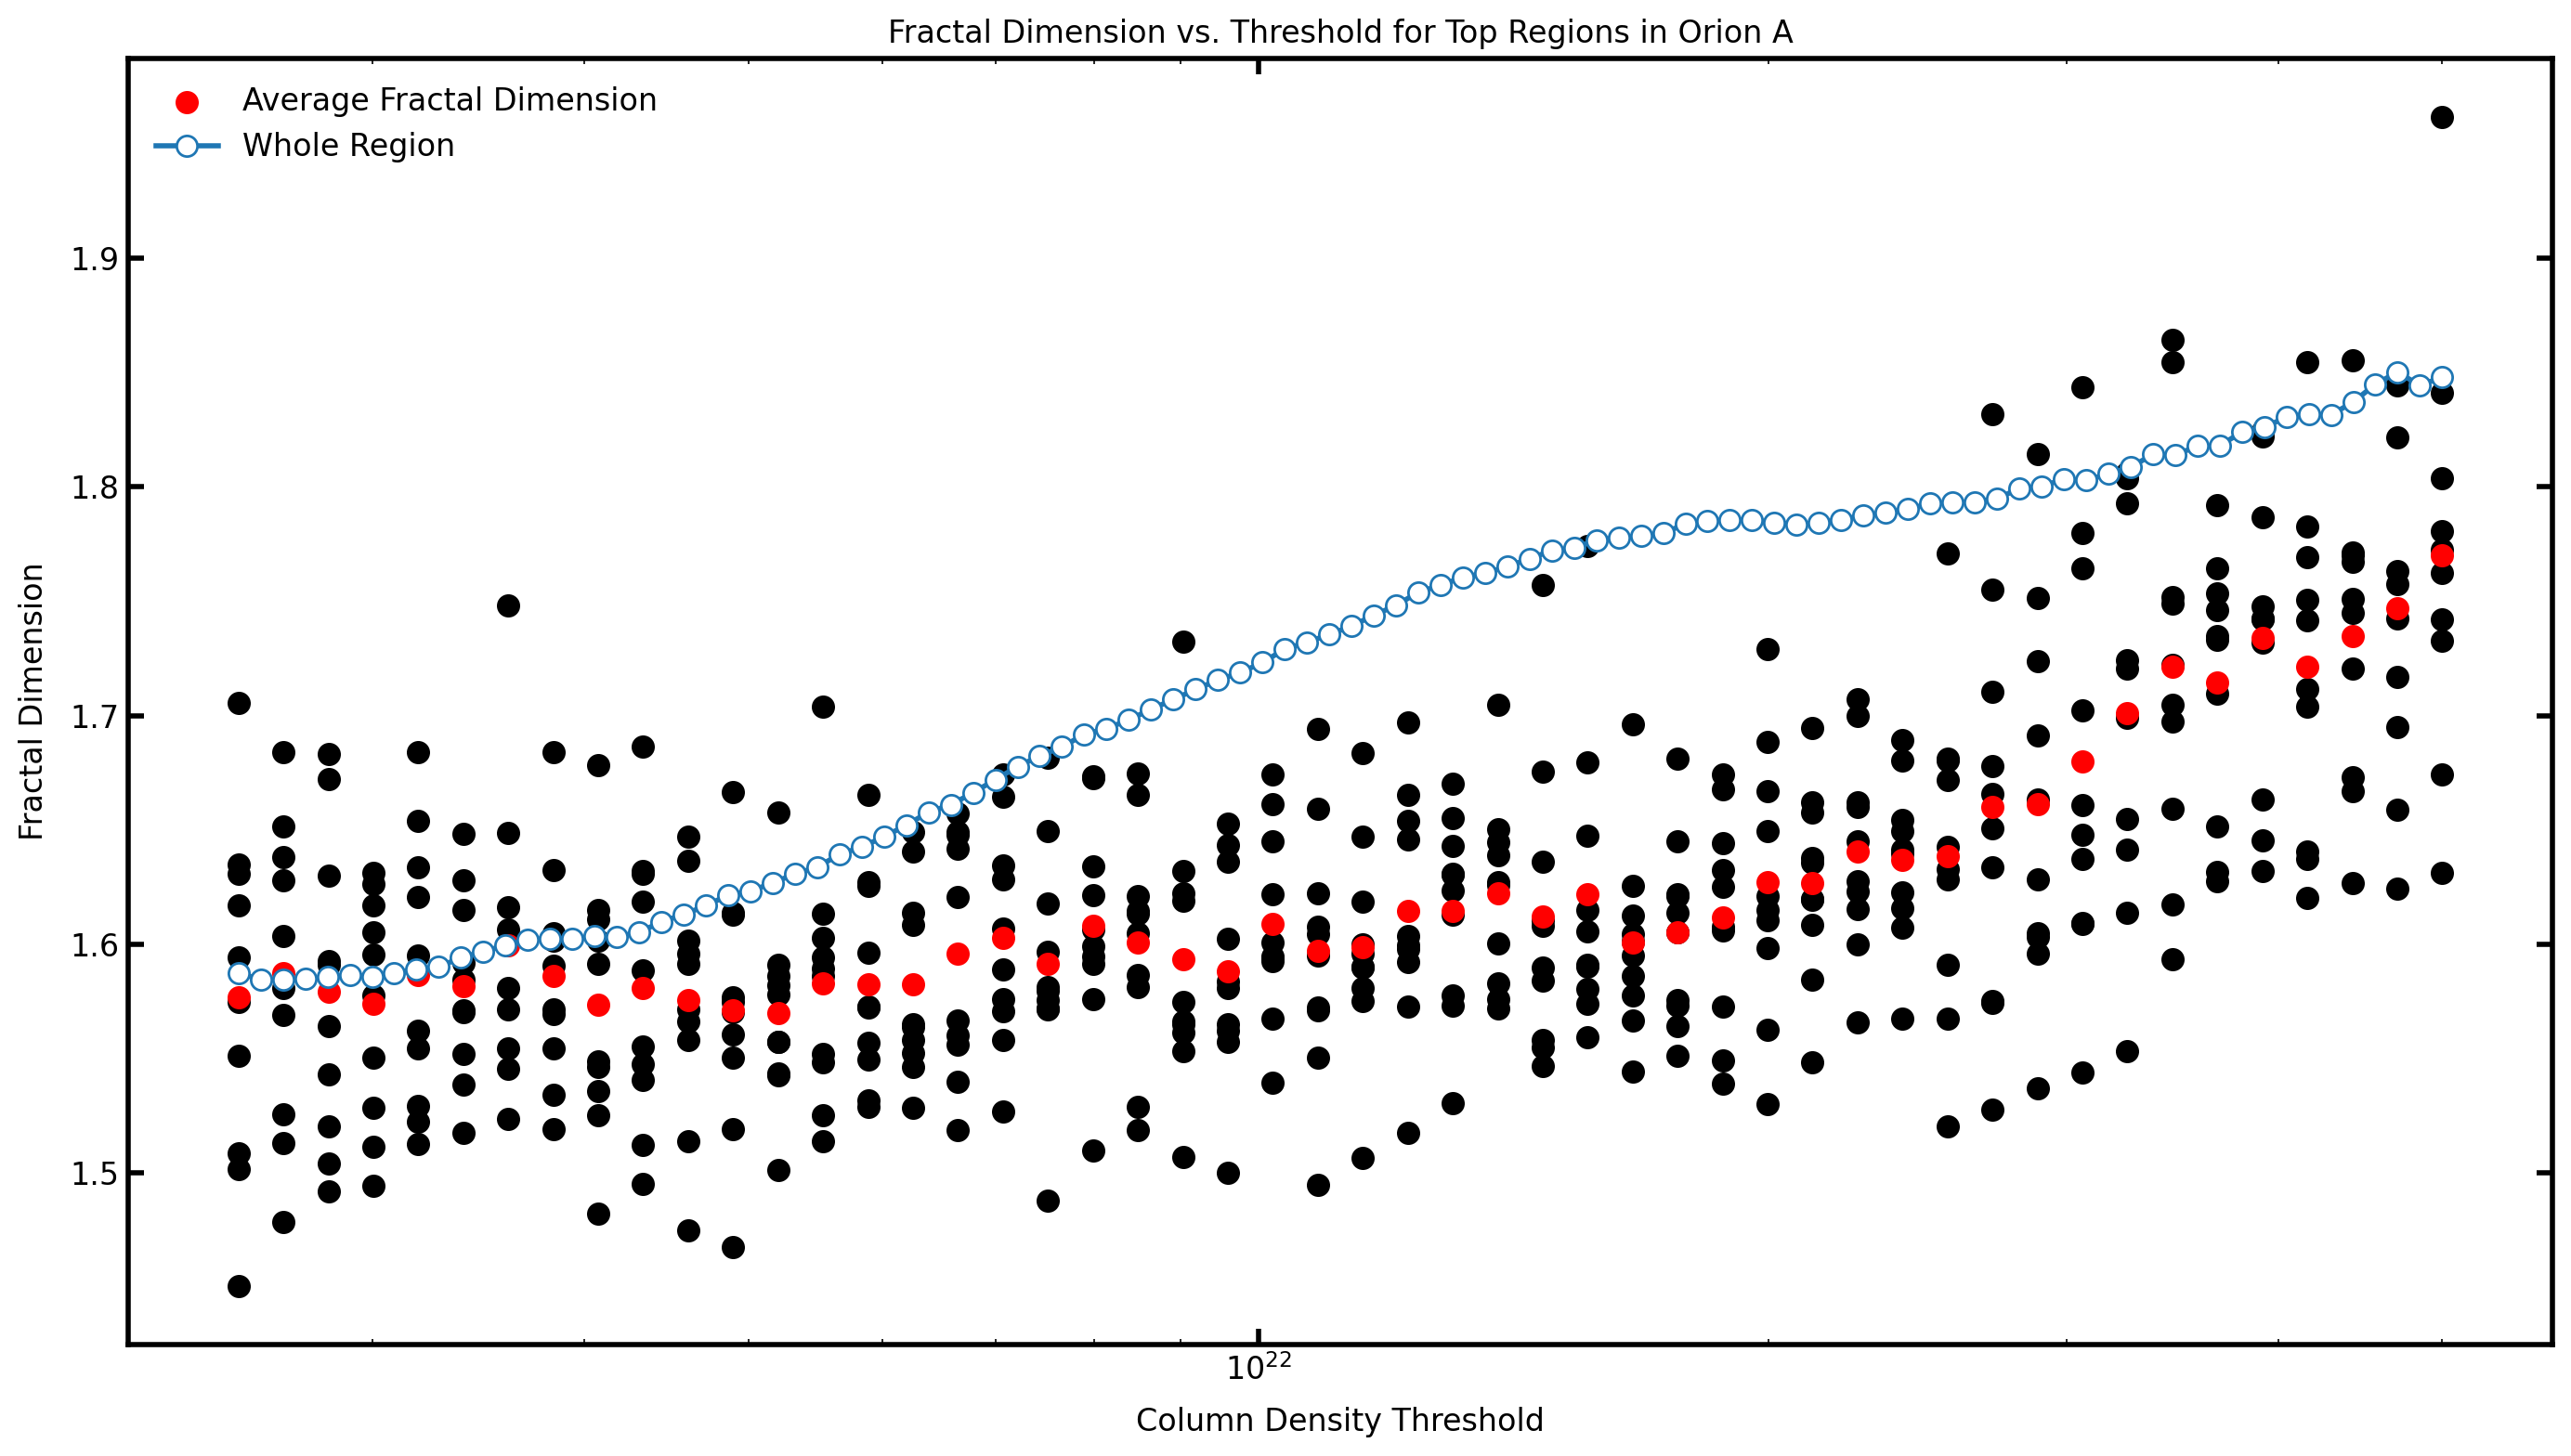

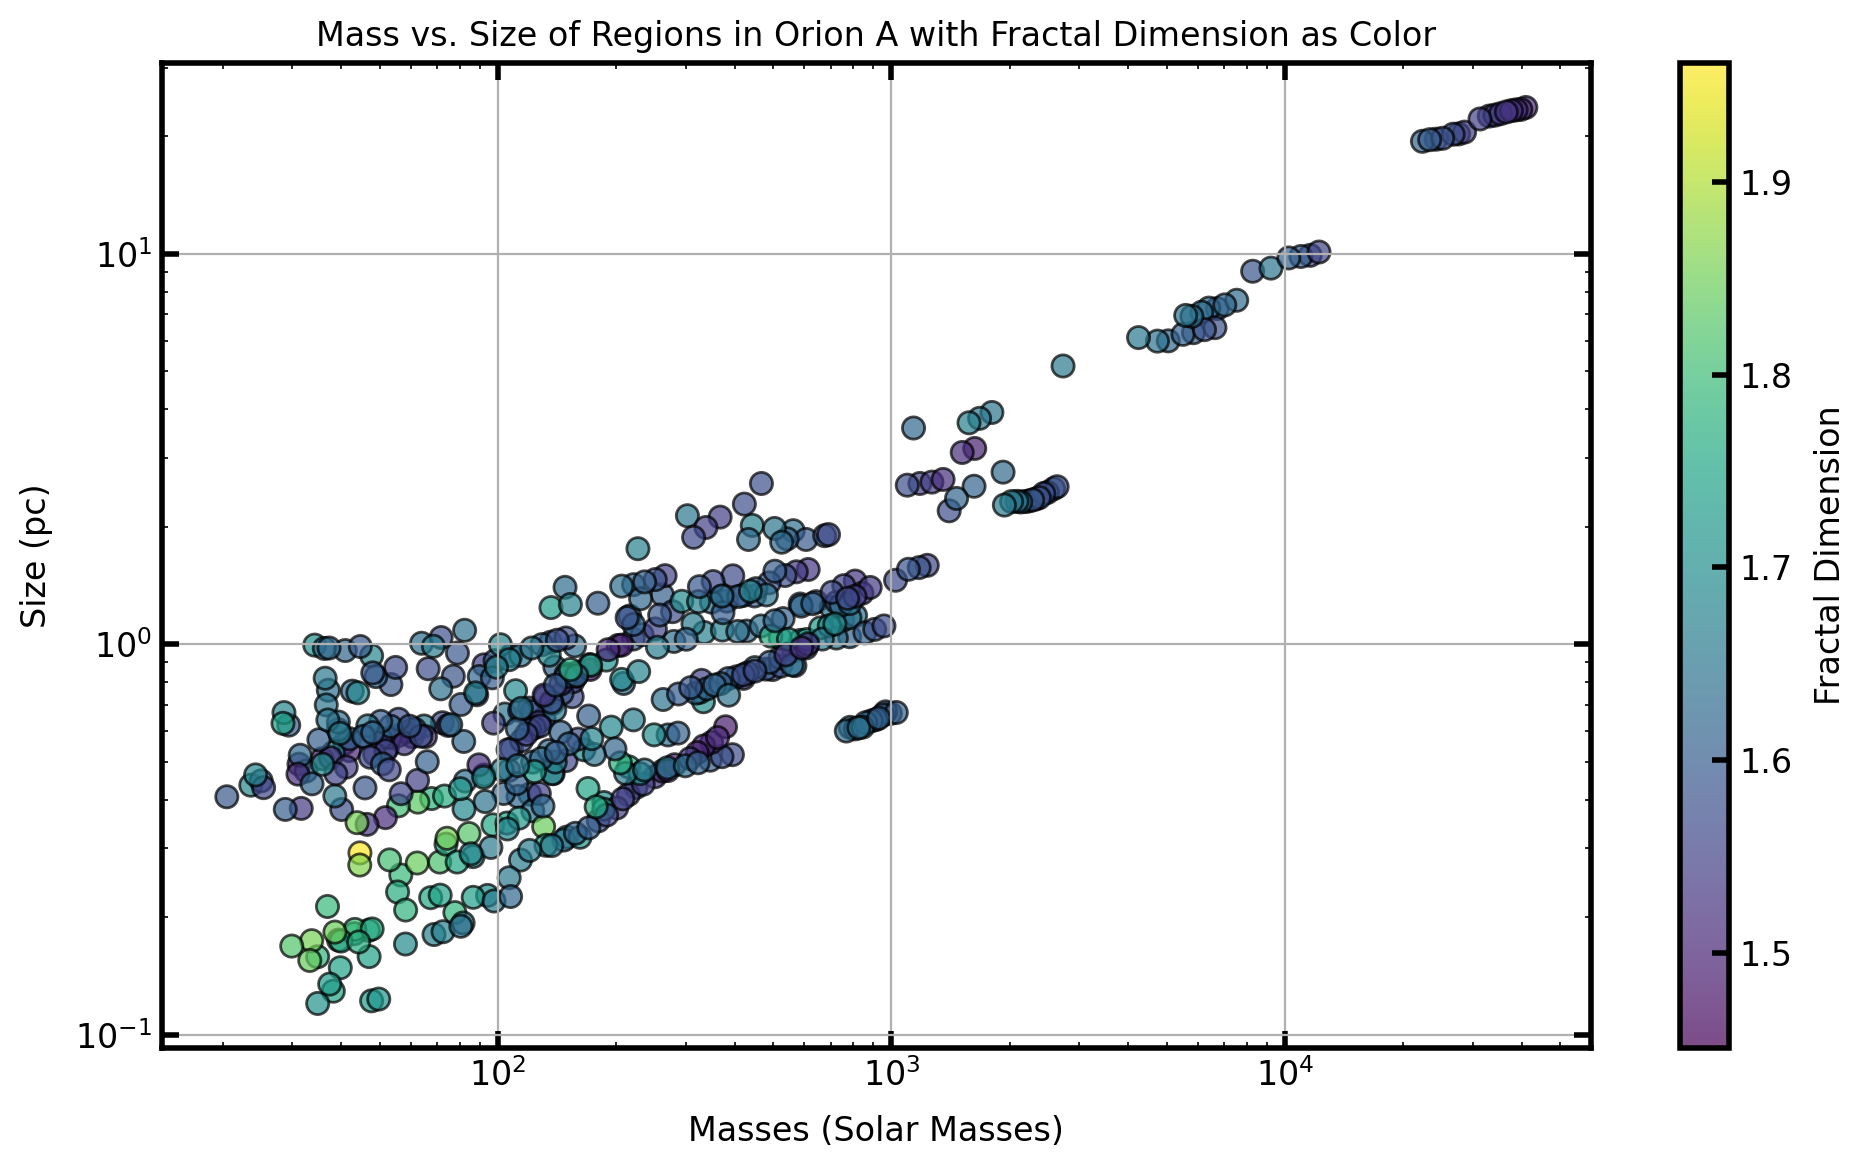

In [34]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def pca_major_axis(region_coords):
    """
    Computes the major axis length of a structure using PCA.
    The major axis is the square root of the largest eigenvalue of the covariance matrix.
    """
    if len(region_coords) < 2:
        return 0  # If only one pixel, size is zero

    # Center the coordinates
    centered_coords = region_coords - np.mean(region_coords, axis=0)

    # Compute covariance matrix and its eigenvalues
    cov_matrix = np.cov(centered_coords, rowvar=False)
    eigenvalues, _ = np.linalg.eigh(cov_matrix)

    # The largest eigenvalue corresponds to the major axis squared
    major_axis = 2 * np.sqrt(np.max(eigenvalues))  # Factor 2 to approximate full length

    return major_axis


def calculate_mass_and_size(region_mask, N_H2_OA, pixel_scale=0.00417, distance=420):
    """
    Calculate the mass and the major axis of a structure using PCA.
    - Mass: Summed pixel values converted to solar masses.
    - Size: Major axis computed from PCA eigenvalues.
    """
    radians = 180 / np.pi  # Conversion factor from degrees to radians
    rad_per_px = pixel_scale / radians
    pc_per_px = np.sin(rad_per_px) * distance  # Parsecs per pixel

    cm_per_pc = 3.086 * 10**18  # cm per parsec
    cm2_per_px = pc_per_px**2 * (cm_per_pc**2)  # cm^2 per pixel

    m_p = 1.67e-27  # Mass of proton (kg)

    # Convert column density to mass
    M_H2 = np.array(N_H2_OA, dtype=np.float64) * 2.8 * m_p / (1.98e30)  # Solar masses per pixel
    M_H2 = M_H2 * cm2_per_px  # Convert to mass per pixel in kg

    # Remove invalid values
    M_H2_clean = np.nan_to_num(M_H2, nan=0.0, posinf=0.0, neginf=0.0)
    M_H2_clean_positive = np.where(M_H2_clean > 0, M_H2_clean, 0)

    # Compute total mass
    mass = np.sum(M_H2_clean_positive[region_mask])

    # Find structure coordinates
    region_coords = np.column_stack(np.where(region_mask))

    if len(region_coords) == 0:
        return mass, 0  # If no region is found, return zero size

    # Compute the major axis length using PCA
    major_axis_length = pca_major_axis(region_coords)

    # Convert size to parsecs
    size_parsecs = major_axis_length * pc_per_px

    return mass, size_parsecs

def compute_fractal_dimension(region_mask):
    """
    Compute the fractal dimension of a binary region using the Perimeter-Area relation.
    
    Parameters:
        region_mask (ndarray): Boolean mask of the structure.
        
    Returns:
        float: Estimated fractal dimension.
    """
    area = np.sum(region_mask)
    
    # Compute perimeter using dilation technique
    mask_perimeter = perimeter(region_mask)

    if area > 0 and mask_perimeter > 0:
        return 2 * (np.log10(mask_perimeter) / np.log10(area))
    return None  # Invalid case (avoid division errors)

def track_largest_regions(N_H2_OA, thresholds, num_top_regions=10):
    """
    Track the n largest regions across multiple thresholds and compute their fractal dimensions.
    
    Parameters:
        N_H2_OA (ndarray): 2D array of the column density map.
        thresholds (list): List of threshold values.
        num_top_regions (int): Number of largest regions to track.
    
    Returns:
        dict: Dictionary mapping the largest regions to their evolution history.
    """
    regions = {}

    for threshold in thresholds:
        mask = N_H2_OA >= threshold  
        labeled_regions, num_features = ndimage.label(mask)  # Identify structures
        
        if num_features == 0:
            continue  # No structures found at this threshold

        # Compute the size of each region
        region_sizes = {region_id: np.sum(labeled_regions == region_id) for region_id in range(1, num_features + 1)}

        # Get the top N largest regions
        top_regions = sorted(region_sizes.keys(), key=lambda k: region_sizes[k], reverse=True)[:num_top_regions]

        for region_id in top_regions:
            region_mask = labeled_regions == region_id
            fractal_dim = compute_fractal_dimension(region_mask)
            mass, size = calculate_mass_and_size(region_mask, N_H2_OA)

            # Store the evolution of each tracked region
            if region_id not in regions:
                regions[region_id] = {
                    "thresholds": [], 
                    "fractal_dimensions": [],
                    "mass": [],
                    "size": []
                }

            regions[region_id]["thresholds"].append(threshold)
            regions[region_id]["fractal_dimensions"].append(fractal_dim)
            regions[region_id]["mass"].append(mass)
            regions[region_id]["size"].append(size)

    return regions

def visualize_largest_regions(N_H2_OA, thresholds, num_top_regions=5, max_cols=3):
    """
    Visualizes the 5 largest structures at different thresholds.
    """
    pass

thresholds = np.logspace(np.log10(2.5e21), np.log10(5e22), 50) 

top_regions_data_OA = track_largest_regions(N_H2_OA, thresholds)

plt.figure(figsize=(14, 8))

average_fractal_dim = np.zeros_like(thresholds)
count = np.zeros_like(thresholds)

for region_id, data in top_regions_data_OA.items():
    plt.scatter(data["thresholds"], data["fractal_dimensions"], marker='o', c="black")
    for i, threshold in enumerate(data["thresholds"]):
        idx = np.where(thresholds == threshold)[0][0]
        average_fractal_dim[idx] += data["fractal_dimensions"][i]
        count[idx] += 1

# Avoid division by zero
count[count == 0] = 1
average_fractal_dim /= count

# Plot the average fractal dimension at each threshold in red
plt.scatter(thresholds, average_fractal_dim, marker='o', color='red', label="Average Fractal Dimension")

plt.xlabel("Column Density Threshold")
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.title("Fractal Dimension vs. Threshold for Top Regions in Orion A")

thresholds_full = np.logspace(np.log10(2.5e21), np.log10(5e22), 100)
plt.plot(thresholds_full, results_OA["fractal_dimension"], '-o', label="Whole Region")

plt.legend()
plt.show()

# Retrieve mass and size for each region and plot them with fractal dimension as the color map
masses = []
sizes = []
fractal_dims = []

for region_id, data in top_regions_data_OA.items():
    for i, threshold in enumerate(data["thresholds"]):
        masses.append(data["mass"][i])
        sizes.append(data["size"][i])
        fractal_dims.append(data["fractal_dimensions"][i])

masses = np.array(masses)
sizes = np.array(sizes)
fractal_dims = np.array(fractal_dims)

plt.figure(figsize=(10, 6))
sc = plt.scatter(masses, sizes, c=fractal_dims, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Fractal Dimension')
plt.xlabel('Masses (Solar Masses)')
plt.ylabel('Size (pc)')
plt.xscale("log")
plt.yscale("log")
plt.title('Mass vs. Size of Regions in Orion A with Fractal Dimension as Color')
plt.grid(True)
plt.show()

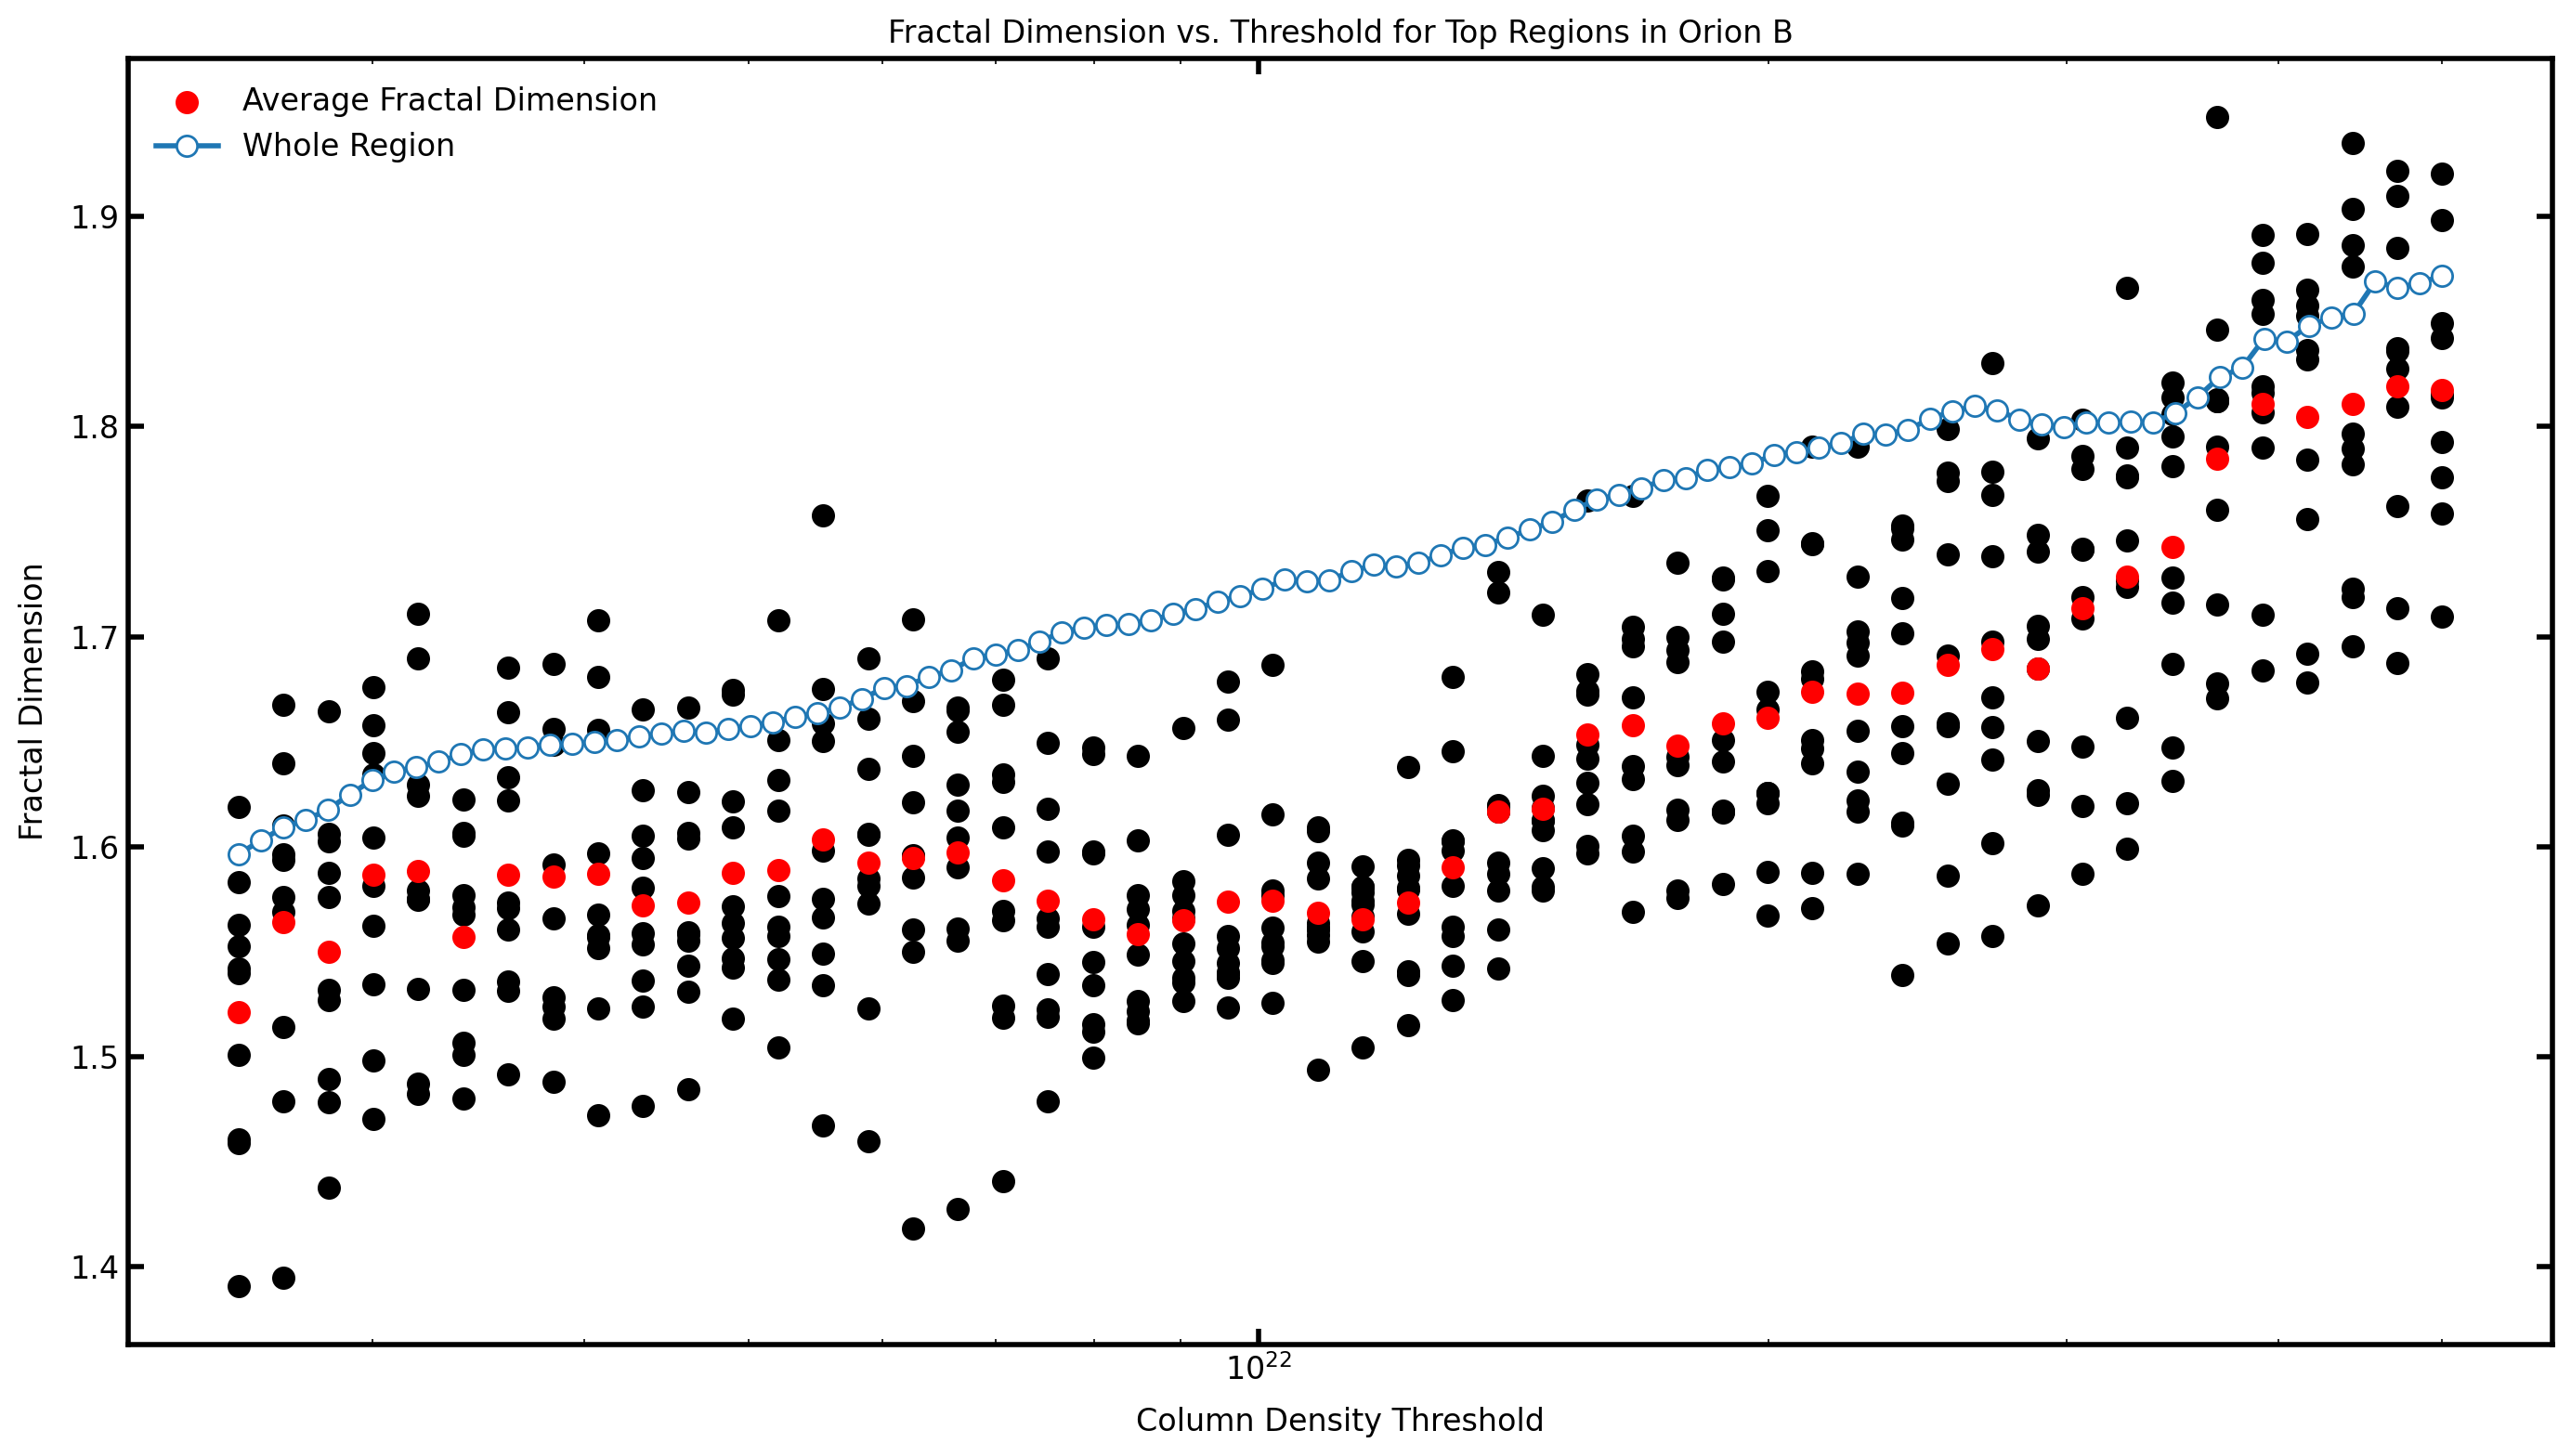

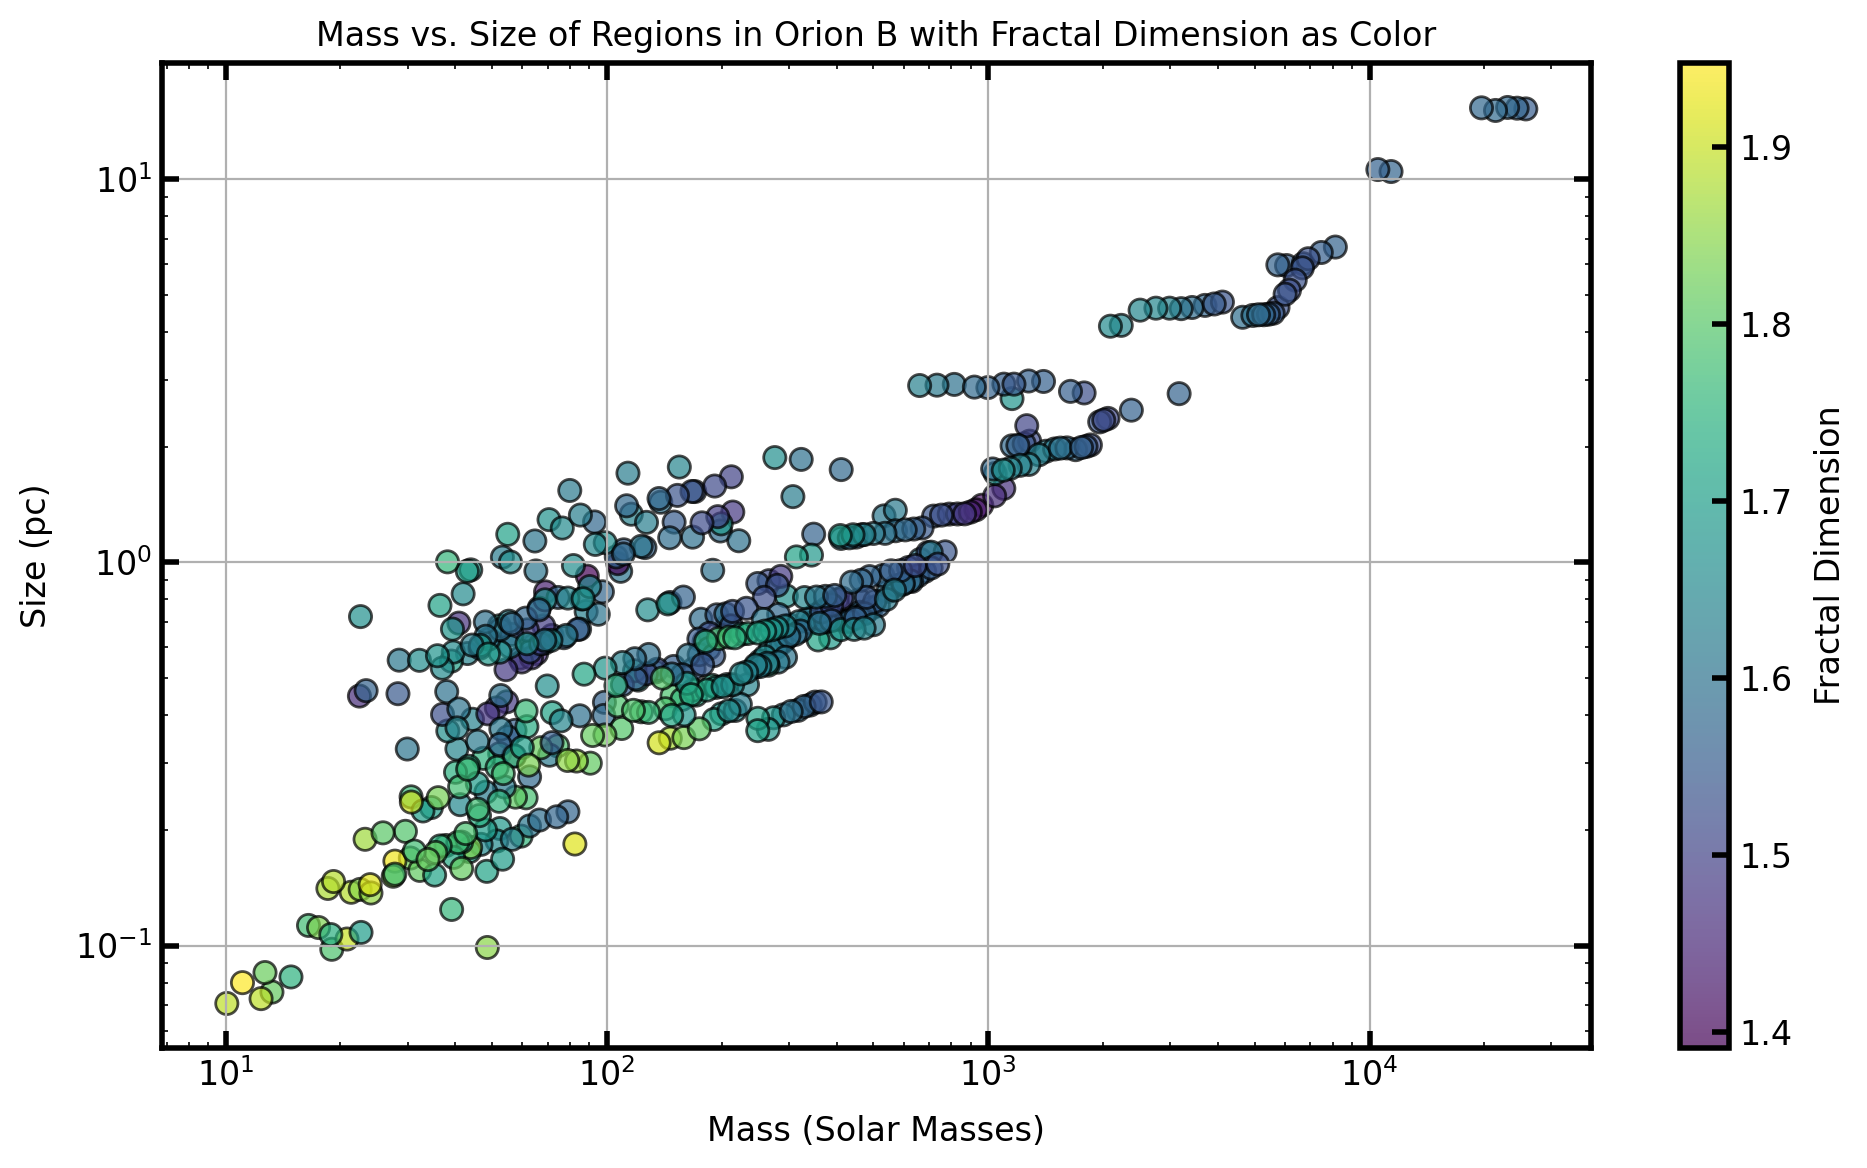

In [35]:
top_regions_data_OB = track_largest_regions(N_H2_OB, thresholds)

plt.figure(figsize=(14, 8))

average_fractal_dim = np.zeros_like(thresholds)
count = np.zeros_like(thresholds)

for region_id, data in top_regions_data_OB.items():
    plt.scatter(data["thresholds"], data["fractal_dimensions"], marker='o', c="black")
    for i, threshold in enumerate(data["thresholds"]):
        idx = np.where(thresholds == threshold)[0][0]
        average_fractal_dim[idx] += data["fractal_dimensions"][i]
        count[idx] += 1

# Avoid division by zero
count[count == 0] = 1
average_fractal_dim /= count

# Plot the average fractal dimension at each threshold in red
plt.scatter(thresholds, average_fractal_dim, marker='o', color='red', label="Average Fractal Dimension")

plt.xlabel("Column Density Threshold")
plt.ylabel('Fractal Dimension')
plt.xscale("log")
plt.title("Fractal Dimension vs. Threshold for Top Regions in Orion B")

thresholds_full = np.logspace(np.log10(2.5e21), np.log10(5e22), 100)
plt.plot(thresholds_full, results_OB["fractal_dimension"], '-o', label="Whole Region")

plt.legend()
plt.show()

# Retrieve mass and size for each region and plot them with fractal dimension as the color map
masses = []
sizes = []
fractal_dims = []

for region_id, data in top_regions_data_OB.items():
    for i, threshold in enumerate(data["thresholds"]):
        masses.append(data["mass"][i])
        sizes.append(data["size"][i])
        fractal_dims.append(data["fractal_dimensions"][i])

masses = np.array(masses)
sizes = np.array(sizes)
fractal_dims = np.array(fractal_dims)

plt.figure(figsize=(10, 6))
sc = plt.scatter(masses, sizes, c=fractal_dims, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(sc, label='Fractal Dimension')
plt.ylabel('Size (pc)')
plt.xlabel('Mass (Solar Masses)')
plt.xscale("log")
plt.yscale("log")
plt.title('Mass vs. Size of Regions in Orion B with Fractal Dimension as Color')
plt.grid(True)
plt.show()

In [12]:
# Kolmogorov turbulence predicts the fractal dimension to be 5/3 (1.7) for turbulent isobar models
# Can we see that here as well?